In [1]:
import numpy as np
from qiskit.circuit.library                   import RYGate,RZGate,RXGate,UGate,NLocal,TwoLocal,RealAmplitudes,XGate,HGate, RXXGate, RYYGate, RZZGate
from qiskit.circuit                           import Parameter
from qiskit.aqua.components.optimizers        import L_BFGS_B,COBYLA,CG,ADAM,SPSA,AQGD
from qiskit.aqua.components.initial_states    import *
from qiskit.aqua.algorithms                   import VQE
from qiskit.aqua                              import QuantumInstance,aqua_globals

from qiskit                                   import IBMQ
from qiskit.providers.aer.backends.aerbackend import AerBackend
from qiskit.providers.ibmq.ibmqbackend        import IBMQBackend
from qiskit.providers.aer                     import noise
from qiskit.providers.aer.noise               import NoiseModel
from qiskit.ignis.mitigation.measurement      import (complete_meas_cal,CompleteMeasFitter)
import logging
from qiskit.aqua                              import set_qiskit_aqua_logging
#set_qiskit_aqua_logging(logging.DEBUG) 

from   qiskit                                 import *
from   qiskit.quantum_info                    import Pauli,Operator
from   qiskit.aqua.operators                  import SummedOp,PauliOp,CircuitStateFn,WeightedPauliOperator, StateFn, PauliExpectation, CircuitSampler,AerPauliExpectation
from   qiskit.aqua.operators.primitive_ops    import MatrixOp
from   qiskit.aqua.operators.legacy           import MatrixOperator,op_converter
from   qiskit.aqua.algorithms                 import NumPyEigensolver,NumPyMinimumEigensolver
from   qiskit.compiler                        import transpile
from qiskit.aqua.operators                    import X, Y, Z, I
from qiskit.aqua.operators.gradients          import Gradient
from qiskit.converters                        import circuit_to_gate

import math
from math                                     import isclose
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display                          import display, Markdown
import itertools

from scipy import linalg as LA
from scipy.optimize                           import curve_fit
import functools
import time

#### Functions to define spin operators and Hamiltonian

In [2]:
def generate_pauli(idx_x,idx_z,n):
    '''
    Args:
       n   (integer)
       idx (List)
    Returns:
       tensor product of Pauli operators acting on qubits in idx
       Y = iZX
       P0 P1 P2 P3 P4
       Pi = (X)^a (Z)^b
    '''
    xmask = [0]*n
    zmask = [0]*n
    for i in idx_x: xmask[i] = 1
    for i in idx_z: zmask[i] = 1
    a_x = np.asarray(xmask,dtype=np.bool)
    a_z = np.asarray(zmask,dtype=np.bool)
    return Pauli(a_z,a_x)

#The following function is used to define the operators that appear in the Heisenberg hamiltonian above
#In PauliOp the default coefficient is 1.0
def generate_Heisenberg(nqubit,nn_list):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = PauliOp(generate_pauli([i,j],[],nqubit));    pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit)); pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit));    pauli_list.append(zizj)
    H = SummedOp(pauli_list)
    return H

#Here we define the spin operators acting on site i
#We note that this function returns the name of the operator (site+component) and its value
def generate_spin_operators(nqubit):
    spins = []
    for i in range(nqubit):
        xi = generate_pauli([i],[],nqubit);  spins.append( (str(i)+'x',PauliOp(xi,1.0)) )
        yi = generate_pauli([i],[i],nqubit); spins.append( (str(i)+'y',PauliOp(yi,1.0)) )
        zi = generate_pauli([],[i],nqubit);  spins.append( (str(i)+'z',PauliOp(zi,1.0)) )
    return spins

#We note that the argument aux_operators will be the output of function generate_spin_operators
def diagonalize_H(H,aux_operators):
    '''
    k = number of eigenvalues/eigenvectors to find
    H |ci) = Ei |ci)
    Ai = (ci|A|ci)
    aux_ops: list of length k; each element is an array of shape (nprops,2) for real and imaginary part
    '''
    ee = NumPyEigensolver(operator=H,k=2**H.num_qubits,aux_operators=[s for name_s,s in aux_operators])
    ee = ee.run()
    energies = np.real(ee['eigenvalues'])
    psi = ee['eigenstates']
    aux_ops = ee['aux_operator_eigenvalues']
    
    '''
    for i,(ei,ai) in enumerate(zip(energies,aux_ops)):
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        for js,(name_s,s) in enumerate(aux_operators):
            print("     Spin ",name_s,round(ai[js][0],6))  #ai[js] has two arguments: the real and imaginary parts
        print("Eigenvector:")
        psi_i = psi[i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
    '''
    return energies,psi,aux_ops

def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin

def to_ket(psi):
    """ Write a statevector in braket notation.
    Parameters
    ----------
    ψ: ndarray
        the statevector
    Returns
    -------
    ket: str
        the statevector in braket notation
    """
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    # CONSTRUCT STRING ONE STATE AT A TIME
    ket = ""
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING
        # UPDATE ket STRING
        if np.round(c,3)!=0.:
            if i > 0: ket += " + "
            ket += f"({c:.3f}) |{label}⟩"   # (OPTIONAL) FIX COEFFICIENT'S PRECISION
    return ket

def to_state(psi):
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    #state = np.zeros(len(psi),dtype=np.complex_)
    state=np.zeros(len(psi),dtype=float)
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING

        v=[np.zeros(2,dtype=float) for i in range(n)]
        for k in range(n):
            v[k][int(label[k])]=1.
                    
        #print(label,v)
        val=np.kron(v[0],v[1])
        for j in range(2,n):
            val=np.kron(val,v[j])
        val=np.dot(c,val)
        state+=val
    return state


#### Functions to define exact total spin eigenstates

In [3]:
def sign(x):
    if(x>0): 
        return  1
    else:    
        return -1

def convert(x):
    return int(round(np.abs(2*x)))

def get_clebsch(j1,m1,j2,m2,J,M):
    from sympy.physics.quantum.cg import CG
    # S is the shortcut for sympify and converts an arbitrary expression to a type that can be used inside SymPy
    sgnJ  = sign(J) 
    from sympy import S     
    sgnM  = sign(M)
    sgnj1 = sign(j1)
    sgnm1 = sign(m1)
    sgnj2 = sign(j2)
    sgnm2 = sign(m2)
    numJ  = convert(J)
    numM  = convert(M)
    numj1 = convert(j1)
    numm1 = convert(m1)
    numj2 = convert(j2)
    numm2 = convert(m2)
    cg = CG(sgnj1*S(numj1)/2,sgnm1*S(numm1)/2,sgnj2*S(numj2)/2,sgnm2*S(numm2)/2,sgnJ*S(numJ)/2,sgnM*S(numM)/2)
    return float(cg.doit().evalf())

# ------------------------------------------------------

# Remark - It's important to notice that the vector associated with psi_JM is a matrix, therefore the indexes we print in the following function are the
#          matrix indexes on which we have a non-zero value. By this way the indexes can be read also as up or down spin vectors.
#          E.g. (0,1,1) --> (up,down,down)

def print_states(psi_dict):
    for k in psi_dict.keys():
        print("State ",k)
        n = len(psi_dict[k].shape)
        for idx in itertools.product([0,1],repeat=n):
            c = psi_dict[k][idx]
            # If we don't insert the following "if", we would see all the null contributes to the state |J,M>
            if(not isclose(c,0.0,abs_tol=1e-4)):
                print(idx," ",c)
        print(" ")
            
# Given the z-component of spin, m, the following function returns the vectors (1 0)^T (j=1/2, m=1/2) or (0 1)^T (j=1/2, m=-1/2)
def one_spin_states(j,m):
    # isclose returns True if two values are closer than the abs_tol
    if(isclose(m,0.5,abs_tol=1e-4)):        
        i=0
    else:                            
        i=1
    psi    = np.zeros(2)
    psi[i] = 1.0
    return psi[:]

def compose_two_spins(label=''):
    psi = {}
    j1,j2 = 1.0/2.0,1.0/2.0
    for J in [0,1]:
        for M in range(-J,J+1):
            psi_JM = np.zeros((2,2))
            for x1 in [0,1]:
                for x2 in [0,1]:
                    m1,m2 = (x1-j1),(x2-j2)
                    cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                    psi_JM += cg*np.einsum('a,b->ab',one_spin_states(j1,m1),one_spin_states(j2,m2))
            #print(psi_JM)
            psi[label+'_'+str(J)+'_'+str(M)] = psi_JM
    return psi

def compose_with_center(psi_left,label=''):
    psi = {}
    j2 = 1.0/2.0
    for j1 in [0,1]:
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            for M in np.arange(-J,J+1e-4,1.0):
                psi_JM_j1 = np.zeros((2,2,2))
                for x1 in range(2*j1+1):
                    for x2 in [0,1]:
                        m1,m2 = (x1-j1),(x2-j2)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi_JM_j1 += cg*np.einsum('ab,c->abc',psi_left[label+'_'+str(j1)+'_'+str(m1)],one_spin_states(j2,m2))
                psi[label+'_j1_'+str(j1)+'_lc_'+str(J)+'_'+str(M)] = psi_JM_j1
    return psi

def compose_with_right(psi_lc,psi_r):
    psi={}
    lc_list=[]

    for k in psi_lc.keys():
        klc = k.split('_')
        lab_lc=klc[0]
        jL = float(klc[2])
        j1 = float(klc[4])
        if((jL,j1) not in lc_list):
            lc_list.append((jL,j1))

    for k in psi_r.keys():
        kr=k.split("_")
        lab_r=kr[0]
        break

    for el in lc_list:
        jL=int(el[0])
        j1=el[1]
        #print(jL, " ", j1)
        for j2 in [0,1]:
            for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
                #print(" ",J)
                for M in np.arange(-J,J+1e-4,1.0):
                    # Label with spin left jL, spin right jR and spin left + center jLC 
                    lab = 'jL_'+str(jL)+'_jR_'+str(j2)+'_jLC_'+str(j1)+'_LCR_'+str(J)+'_'+str(M)
                    psi[lab] = np.zeros((2,2,2,2,2))
                    for m1 in np.arange(-j1,j1+1e-4,1):
                        for m2 in np.arange(-j2,j2+1e-4,1):
                            lab1=lab_lc+'_j1_'+str(jL)+'_lc_'+str(j1)+'_'+str(m1)
                            lab2=lab_r+'_'+str(j2)+'_'+str(int(m2))
                            cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                            psi[lab] += cg*np.einsum('abc,de->abcde',psi_lc[lab1],psi_r[lab2])
    return psi

#### Definition of spin operators: $\hat{S}_x$, $\hat{S}_y$, $\hat{S}_z$, $\hat{S}^2$

In [5]:
sx=[]
for i in range (3):
    sx.append((1.0/2.,generate_pauli([i],[],3)))
sx=WeightedPauliOperator(sx)
print("Sx operator")
print(sx.print_details())
mat_sx=op_converter.to_matrix_operator(sx).dense_matrix
#print("Sx operator matrix")
#print(mat_sx)

sy=[]
for i in range (3):
    sy.append((1.0/2.,generate_pauli([i],[i],3)))
sy=WeightedPauliOperator(sy)
print("Sy operator")
print(sy.print_details())
mat_sy=op_converter.to_matrix_operator(sy).dense_matrix
#print("Sy operator matrix")
#print(mat_sy)

sz=[]
for i in range (3):
    sz.append((1.0/2.,generate_pauli([],[i],3)))
sz=WeightedPauliOperator(sz)
print("Sz operator")
print(sz.print_details())
mat_sz=op_converter.to_matrix_operator(sz).dense_matrix
#print("Sz operator matrix")
#print(mat_sz)

s2=np.dot(sx,sx)+np.dot(sy,sy)+np.dot(sz,sz)
print("S2 operator")
print(s2.print_details())
mat_s2=op_converter.to_matrix_operator(s2).dense_matrix
#print("S2 operator matrix")
#print(mat_s2)

Sx operator
IIX	(0.5+0j)
IXI	(0.5+0j)
XII	(0.5+0j)

Sy operator
IIY	(0.5+0j)
IYI	(0.5+0j)
YII	(0.5+0j)

Sz operator
IIZ	(0.5+0j)
IZI	(0.5+0j)
ZII	(0.5+0j)

S2 operator
III	(2.25+0j)
IXX	(0.5+0j)
XIX	(0.5+0j)
XXI	(0.5+0j)
IYY	(0.5+0j)
YIY	(0.5+0j)
YYI	(0.5+0j)
IZZ	(0.5+0j)
ZIZ	(0.5+0j)
ZZI	(0.5+0j)



 #### Definition of the left spin operator: $\hat{S}_L^2$

In [6]:
slx=[]
for i in range (2):
    slx.append((1.0/2.,generate_pauli([i],[],3)))
slx=WeightedPauliOperator(slx)
print("Slx operator")
print(slx.print_details())
mat_slx=op_converter.to_matrix_operator(slx).dense_matrix
#print("Slx operator matrix")
#print(mat_slx)

sly=[]
for i in range (2):
    sly.append((1.0/2.,generate_pauli([i],[i],3)))
sly=WeightedPauliOperator(sly)
print("Sly operator")
print(sly.print_details())
mat_sly=op_converter.to_matrix_operator(sly).dense_matrix
#print("Sly operator matrix")
#print(mat_lsy)

slz=[]
for i in range (2):
    slz.append((1.0/2.,generate_pauli([],[i],3)))
slz=WeightedPauliOperator(slz)
print("Slz operator")
print(slz.print_details())
mat_slz=op_converter.to_matrix_operator(slz).dense_matrix
#print("Slz operator matrix")
#print(mat_slz)

sl2=np.dot(slx,slx)+np.dot(sly,sly)+np.dot(slz,slz)
print("Sl2 operator")
print(sl2.print_details())
mat_sl2=op_converter.to_matrix_operator(sl2).dense_matrix
#print("Sl2 operator matrix")
#print(mat_sl2)

Slx operator
IIX	(0.5+0j)
IXI	(0.5+0j)

Sly operator
IIY	(0.5+0j)
IYI	(0.5+0j)

Slz operator
IIZ	(0.5+0j)
IZI	(0.5+0j)

Sl2 operator
III	(1.5+0j)
IXX	(0.5+0j)
IYY	(0.5+0j)
IZZ	(0.5+0j)



 #### Definition of the spin operator: $\hat{S}_{02}^2=\Bigl( \hat{S}_{0} + \hat{S}_{2} \Bigr)^2$
 
 It will be useful in the case of circuits with qubit in first position swapped with the qubit in third position.

In [7]:
# Warning - Round brackets are essential!
s02x=(0.5*X^I^I) + (0.5*I^I^X)
s02y=(0.5*Y^I^I) + (0.5*I^I^Y)
s02z=(0.5*Z^I^I) + (0.5*I^I^Z)

op_s022=(s02x@s02x+s02y@s02y+s02z@s02z).to_pauli_op()
print("S_{02}^2 operator")
print(op_s022)

# Corresponding WeightedPauliOperator
s022=op_converter.to_weighted_pauli_operator(MatrixOperator(op_s022.to_matrix()))
#print(s022.print_details())

S_{02}^2 operator
SummedOp([
  (1.5+0j) * III,
  (0.5+0j) * XIX,
  (0.5+0j) * YIY,
  (0.5+0j) * ZIZ
])


In [8]:
s022 = op_converter.to_weighted_pauli_operator(op_s022)

AquaError: "Unsupported type to convert to WeightedPauliOperator: <class 'qiskit.aqua.operators.list_ops.summed_op.SummedOp'>"

We transform the `WeightedPauliOperator` functions of $S^2$, $S_z$ and $S_L^2$ into `SummedOp` functions.

In [9]:
# Conversion from WeightedPauliOperator function to SummedOp
op_sl2=SummedOp(sl2.to_opflow().to_pauli_op())
op_s2=SummedOp(s2.to_opflow().to_pauli_op())
op_sz=SummedOp(sz.to_opflow().to_pauli_op())
# Identity operator
op_I=I^I^I

#### Exact eigenstates of total spin for $3$ spins

In [10]:
psi_L   = compose_two_spins('L')
psi_R   = compose_two_spins('R')
psi_LC  = compose_with_center(psi_L,'L')
psi_LCR = compose_with_right(psi_LC,psi_R)

In [11]:
print("States LC - Number: ",len(psi_LC.keys()))
print_states(psi_LC)

eig_3spins=[]
for v in psi_LC.values():
    # We use concatenate 2 times because the vectors have been built using np.zeros((2,2,2))
    eig_3spins.append(np.concatenate(np.concatenate(v)))

States LC - Number:  8
State  L_j1_0_lc_0.5_-0.5
(0, 1, 1)   0.7071067811865476
(1, 0, 1)   -0.7071067811865476
 
State  L_j1_0_lc_0.5_0.5
(0, 1, 0)   0.7071067811865476
(1, 0, 0)   -0.7071067811865476
 
State  L_j1_1_lc_0.5_-0.5
(0, 1, 1)   0.408248290463863
(1, 0, 1)   0.408248290463863
(1, 1, 0)   -0.816496580927726
 
State  L_j1_1_lc_0.5_0.5
(0, 0, 1)   0.816496580927726
(0, 1, 0)   -0.408248290463863
(1, 0, 0)   -0.408248290463863
 
State  L_j1_1_lc_1.5_-1.5
(1, 1, 1)   1.0
 
State  L_j1_1_lc_1.5_-0.5
(0, 1, 1)   0.5773502691896258
(1, 0, 1)   0.5773502691896258
(1, 1, 0)   0.5773502691896257
 
State  L_j1_1_lc_1.5_0.5
(0, 0, 1)   0.5773502691896257
(0, 1, 0)   0.5773502691896258
(1, 0, 0)   0.5773502691896258
 
State  L_j1_1_lc_1.5_1.5
(0, 0, 0)   1.0
 


#### Functions which define the quantum circuits 

In [12]:
# q refers to the qubit in which inserting the gate
def single_qubit_gate(w,J,M):
    qr = QuantumRegister(1,'q')                 
    qc = QuantumCircuit(qr)
    if J==0:
        if w==True:
            qc.x(0)
            qc.h(0)
        else:
            qc.x(0)
    else:
        if M==0:
            if w==True:
                qc.h(0)
            else:
                qc.x(0)
        elif M==-1:
            if w==True:
                qc.x(0)
    #print(qc.draw())
    #one_spin=qc.to_instruction()          # Another possible way to deal with the construction of the gate
    one_gate=qc.to_gate(label="single-qubit-gate")
    return one_gate

# LEFT CASE
def three_spin_shallow(l,J,M):
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    
    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l,M-0.5,0.5,0.5,J,M))  
    '''
    Alternative approach
    theta=np.arccos(np.sqrt((l+M+0.5)/(2*l+1)))
    if l==1 and J==0.5:
        theta+=np.pi/2
    '''
    #print("theta_LC = ",theta)
    
    qc.ry(2*theta,2)                                            # Remember that we need to insert 2*theta
    qc.append(single_qubit_gate(True,l,M+0.5).control(1),[2,0])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M+0.5).control(1),[2,1]) # CNOT Target [1], Control [2]    
    qc.x(2)
    qc.append(single_qubit_gate(True,l,M-0.5).control(1),[2,0])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M-0.5).control(1),[2,1]) # CNOT Target [1], Control [2]
    qc.x(2)
    qc.cx(0,1)
    #print(qc.draw())
    three_spin=qc.to_gate(label="3-spin")
    return three_spin

# RIGHT CASE
def three_spin_shallow2(r,J,M):
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    
    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(r,M-0.5,0.5,0.5,J,M))  
    '''
    Alternative approach
    theta=np.arccos(np.sqrt((r+M+0.5)/(2*r+1)))
    if r==1 and J==0.5:
        theta+=np.pi/2
    '''
    #print("theta_LC = ",theta)
    
    qc.ry(2*theta,0)                                            # Remember that we need to insert 2*theta
    qc.append(single_qubit_gate(True,l,M+0.5).control(1),[0,1])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M+0.5).control(1),[0,2]) # CNOT Target [1], Control [2]    
    qc.x(0)
    qc.append(single_qubit_gate(True,l,M-0.5).control(1),[0,1])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M-0.5).control(1),[0,2]) # CNOT Target [1], Control [2]
    qc.x(0)
    qc.cx(1,2)
    #print(qc.draw())
    three_spin=qc.to_gate(label="3-spin")
    return three_spin

Here we define the new function `measure_operator` which returns the mean value and the variance of a given `SummedOp` operator. We remind that in the case in which we use a `statevector_simulator` we will have variance equal to $0$ because the expression is evaluated using linear algebra calculations. 

In [13]:
def measure_operator(O,circ,instance):
    # Definition of operator O (SummedOp !!), state ket and <ket|O|ket>
    ket=CircuitStateFn(circ)
    op=StateFn(O,is_measurement=True)
    braket=op@ket

    # Convert to expectation value
    grouped = PauliExpectation().convert(braket)  

    # Get state sampler (you can also pass the backend directly)
    sampled_op = CircuitSampler(instance).convert(grouped)
    
    # Get mean value and variance
    mean_value=sampled_op.eval().real
    variance = PauliExpectation().compute_variance(sampled_op).real
    return mean_value,variance

### Analysis of the circuit given with function

#### Example with $|s_L=0,s=1/2,s_z=-1/2 \rangle$

In [18]:
qr = QuantumRegister(3,'q')
qc = QuantumCircuit(qr)
qc.append(three_spin_shallow(0,0.5,-0.5),[0,1,2])

print("BEFORE transpile op/depth = ",qc.count_ops(),qc.depth())
print(qc.draw())

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend   = provider.get_backend('ibmq_athens')

min_depth       = 1000
optimal_circuit = None

for level in [0,1,2,3]:
    for idx in itertools.permutations([0,1,2]):
        from qiskit.compiler import transpile
        qc_transpiled = transpile(qc,backend,optimization_level=level,initial_layout=list(idx))
        print("With order  ",idx," and level ",level)
        print("OPERATIONS: ",qc_transpiled.count_ops())
        print("DEPTH:      ",qc_transpiled.depth(),"\n")
        if(qc_transpiled.depth()<min_depth):
            min_depth=qc_transpiled.depth()
            optimal_circuit = qc_transpiled
            
#print(optimal_circuit.draw())
print("Minimal depth = ",min_depth)

BEFORE transpile op/depth =  OrderedDict([('circuit16694', 1)]) 1
     ┌─────────┐
q_0: ┤0        ├
     │         │
q_1: ┤1 3-spin ├
     │         │
q_2: ┤2        ├
     └─────────┘


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-06-21 16:53:28,042: Credentials are already in use. The existing account in the session will be replaced.


With order   (0, 1, 2)  and level  0
OPERATIONS:  OrderedDict([('rz', 63), ('sx', 42), ('cx', 29), ('x', 2)])
DEPTH:       111 

With order   (0, 2, 1)  and level  0
OPERATIONS:  OrderedDict([('rz', 63), ('sx', 42), ('cx', 20), ('x', 2)])
DEPTH:       103 

With order   (1, 0, 2)  and level  0
OPERATIONS:  OrderedDict([('rz', 63), ('sx', 42), ('cx', 26), ('x', 2)])
DEPTH:       111 

With order   (1, 2, 0)  and level  0
OPERATIONS:  OrderedDict([('rz', 63), ('sx', 42), ('cx', 26), ('x', 2)])
DEPTH:       108 

With order   (2, 0, 1)  and level  0
OPERATIONS:  OrderedDict([('rz', 63), ('sx', 42), ('cx', 20), ('x', 2)])
DEPTH:       100 

With order   (2, 1, 0)  and level  0
OPERATIONS:  OrderedDict([('rz', 63), ('sx', 42), ('cx', 23), ('x', 2)])
DEPTH:       106 

With order   (0, 1, 2)  and level  1
OPERATIONS:  OrderedDict([('cx', 22), ('rz', 15), ('sx', 10), ('x', 2)])
DEPTH:       43 

With order   (0, 2, 1)  and level  1
OPERATIONS:  OrderedDict([('cx', 16), ('rz', 15), ('sx', 10),

**Remark** We suppose that appending the Clebsh-Gordan circuits by inserting each gate one by one could reduce the depth of the circuit after transpilation. 

# The $3$-spin case Clebsch-Gordan quantum circuits 

The Clebsh-Gordan circuits have the following design:

### (A) <img src="Pictures/CG13.png" width="600">

We can notice that by this way we have the **CNOT** gates which act on "distant" qubits and this could be a problem in the case of a quantum hardware with connectivity only on nearest neighbors. Indeed, the quantum hardware should replace each **CNOT** gate with two **SWAP** gates and one **CNOT** gate.

We can also create a circuit which doesn'use entangling gates on distant qubits. We have to look at the circuit above and swap the second and third qubits. By this way the only distant-qubits entangling gate is the final **CNOT** gate.

### (B) <img src="Pictures/CG14.jpeg" width="800">

We notice that the *Yorktown* hardware should be the only hardware of the following considered ones where the last **CNOT** gate is transpiled without the use of **SWAPS**.  

In the case of a $3$-spin system the expectation values for $S^2$ and $S_L$ are given by $s(s+1)$ and $s_L(s_L+1)$.

$$\begin{align}
& s_L = 0 \Rightarrow \langle \hat{S}_L^2 \rangle = 0 \\
& s_L = 1 \Rightarrow \langle \hat{S}_L^2 \rangle = 2 \\
& s = 1/2 \Rightarrow \langle \hat{S}^2 \rangle = 3/4 = 0.75\\
& s = 3/2 \Rightarrow \langle \hat{S}^2 \rangle = 15/4 = 3.75\\
\end{align}
$$

We are going to compute the expectation values of $S^2$, $S_z$ and $S_{02}^2$ for circuit **B**. We are going to plot the results using error bars which are based on the standard deviation. If $\hat{O}$ is a generic operator, the standard deviation is given by the square root of the corresponding variance divided by the number of shots $N$ (samples):

$$ \epsilon_{st} = \sqrt{\frac{\Bigl( \langle \hat{O}^2 \rangle - \langle \hat{O} \rangle^2 \Bigr)}{N}}$$

In [6]:
nqubits = 3
lab_list = [(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]
shot_list = [100,200,500,1000,2000,4000,8000]

# Vectors to store the expectation values
# Those vectors are composed by two components because they will store information for circuits A and B
# The circuit A will use sl2_val to store values corresponding to op_sl2; the circuit B to store values of op_s022
sl2_val = np.zeros((len(shot_list),2))
s2_val  = np.zeros((len(shot_list),2))
sz_val  = np.zeros((len(shot_list),2))

# Definition of the backend
backend  = Aer.get_backend('qasm_simulator')

Now we create the $8$ circuits by building them one by one. We use the shape of circuit **B**.

## Preliminary analysis - Circuit associated with $| s_L=0,s=1/2,s_z=-1/2 \rangle$

#### Circuit design and associated transpiled circuit

In [19]:
l=lab_list[0]

qr      = QuantumRegister(nqubits,'q')
circ    = QuantumCircuit(qr)

# theta gives the angle to use in the Ry Gate
theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

circ.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

if l[0]==0:
    circ.cx(1,0)
    circ.ch(1,0)
    # Alternative way to create a controlled-Hadamard
    #c_gate = HGate().control(1)
    #circ.append(c_gate,[1,0])
    circ.cx(1,2)
    
elif l[0]==1:
    if l[2]+0.5==0:
        circ.ch(1,0)
        circ.cx(1,2)
    elif l[2]+0.5==-1:
        circ.cx(1,0)

circ.x(1)

if l[0]==0:
    circ.cx(1,0)
    circ.ch(1,0)
    circ.cx(1,2)
    
elif l[0]==1:
    if l[2]-0.5==0:
        circ.ch(1,0)
        circ.cx(1,2)
    elif l[2]-0.5==-1:
        circ.cx(1,0)
        
circ.x(1)
circ.cx(0,2)
print(circ.draw())
print("BEFORE TRANSPILATION - Operations = ",circ.count_ops()," , Depth = ",circ.depth())
#backend  = provider.get_backend('ibmq_5_yorktown')
backend  = provider.get_backend('ibmq_athens')

optimal_circuit = None
optimal_perm    = None
min_depth       = 1000

for level in [0,1,2,3]:
    for idx in itertools.permutations([0,1,2]):
        from qiskit.compiler import transpile
        qc_transpiled = transpile(circ,backend,optimization_level=level,initial_layout=list(idx))
        print("With order  ",idx," and level ",level)
        print("OPERATIONS: ",qc_transpiled.count_ops())
        print("DEPTH:      ",qc_transpiled.depth(),"\n")
        if(qc_transpiled.depth()<min_depth):
            min_depth=qc_transpiled.depth()
            optimal_perm=list(idx)
            optimal_circuit = qc_transpiled
            
#print(optimal_circuit.draw())
print("Minimal depth      = ",min_depth)
print("Optimal permutation: ",optimal_perm)

'''
# Transpilation using callback which analyzes how each gate is used
from qiskit.transpiler.passes import Optimize1qGatesDecomposition
from qiskit.converters import dag_to_circuit
def callback(**kwargs):
    print(kwargs['pass_'])
    print(dag_to_circuit(kwargs['dag']))
circ_t=transpile(circ, backend=real_device,optimization_level=3,initial_layout=[0,1,2],callback=callback)
print("AFTER TRANSPILATION - Operations = ",circ_t.count_ops()," , Depth = ",circ_t.depth())
'''

              ┌───┐┌───┐          ┌───┐┌───┐               
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──
     ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  
q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──
     └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├
                        └───┘               └───┘     └───┘
BEFORE TRANSPILATION - Operations =  OrderedDict([('cx', 5), ('ch', 2), ('x', 2), ('ry', 1)])  , Depth =  9
With order   (0, 1, 2)  and level  0
OPERATIONS:  OrderedDict([('rz', 39), ('sx', 26), ('cx', 10), ('x', 2)])
DEPTH:       70 

With order   (0, 2, 1)  and level  0
OPERATIONS:  OrderedDict([('rz', 39), ('sx', 26), ('cx', 22), ('x', 2)])
DEPTH:       84 

With order   (1, 0, 2)  and level  0
OPERATIONS:  OrderedDict([('rz', 39), ('sx', 26), ('cx', 16), ('x', 2)])
DEPTH:       81 

With order   (1, 2, 0)  and level  0
OPERATIONS:  OrderedDict([('rz', 39), ('sx', 26), (

'\n# Transpilation using callback which analyzes how each gate is used\nfrom qiskit.transpiler.passes import Optimize1qGatesDecomposition\nfrom qiskit.converters import dag_to_circuit\ndef callback(**kwargs):\n    print(kwargs[\'pass_\'])\n    print(dag_to_circuit(kwargs[\'dag\']))\ncirc_t=transpile(circ, backend=real_device,optimization_level=3,initial_layout=[0,1,2],callback=callback)\nprint("AFTER TRANSPILATION - Operations = ",circ_t.count_ops()," , Depth = ",circ_t.depth())\n'

From the output above we confirm the guess we made: building the CG circuits "one by one" reduce the depth of the circuit.

### -  QASM simulation without noise model

Shots:  100
Operator | Mean | Standard deviation
I 1.0 0.0
S_{02}^2 0.0 0.0
S^2 0.75 0.0
S_z -0.5 0.0


Shots:  200
Operator | Mean | Standard deviation
I 1.0 0.0
S_{02}^2 0.0 3.9252311467094376e-18
S^2 0.7499999999999998 1.570092458683775e-17
S_z -0.5 0.0


Shots:  500
Operator | Mean | Standard deviation
I 1.0 0.0
S_{02}^2 4.440892098500626e-16 1.9860273225978187e-17
S^2 0.7499999999999996 2.0471501066083613e-17
S_z -0.5 0.0


Shots:  1000
Operator | Mean | Standard deviation
I 1.0 0.0
S_{02}^2 4.440892098500626e-16 1.4043333874306806e-17
S^2 0.75 0.0
S_z -0.5 0.0


Shots:  2000
Operator | Mean | Standard deviation
I 1.0 0.0
S_{02}^2 0.0 0.0
S^2 0.75 0.0
S_z -0.5 0.0


Shots:  4000
Operator | Mean | Standard deviation
I 1.0 0.0
S_{02}^2 0.0 0.0
S^2 0.7499999999999996 7.076311083754596e-18
S_z -0.5 0.0


Shots:  8000
Operator | Mean | Standard deviation
I 1.0000000000000002 2.4825341532472734e-18
S_{02}^2 0.0 0.0
S^2 0.75 0.0
S_z -0.5 0.0




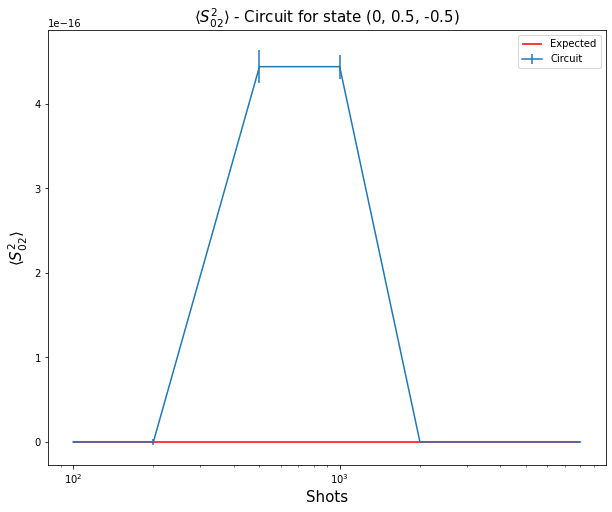

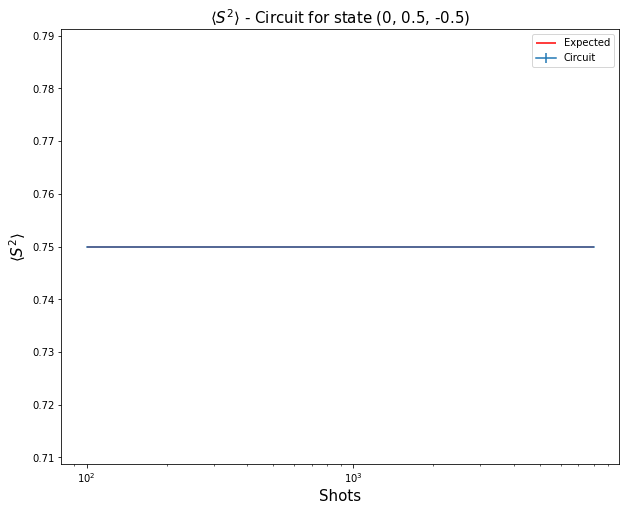

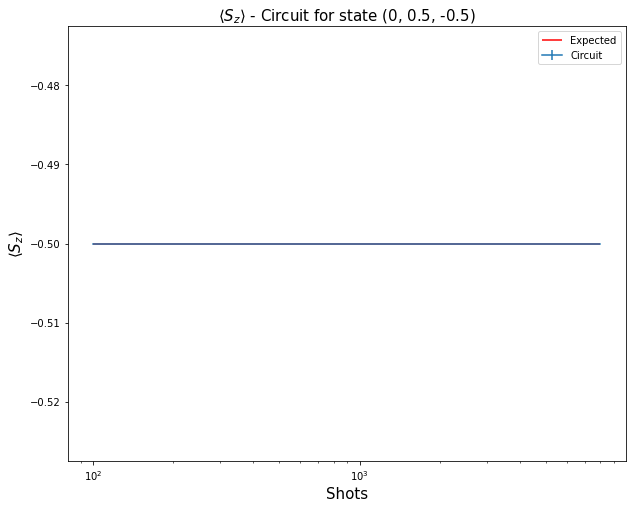

In [29]:
for idx,s in enumerate(shot_list):
    print("Shots: ",s)
    instance = QuantumInstance(backend = backend, shots = s)
            
    print("Operator | Mean | Standard deviation")
            
    mu,sigma   = measure_operator(op_I,circ,instance)
    print("I",mu,np.sqrt(sigma/s))
            
    mu1,sigma1 = measure_operator(op_s022,circ,instance) 
    print("S_{02}^2",mu1,np.sqrt(sigma1/s))         
    sl2_val[idx][0]=mu1
    sl2_val[idx][1]=np.sqrt(sigma1/s)
            
    mu2,sigma2 = measure_operator(op_s2,circ,instance)
    print("S^2",mu2,np.sqrt(sigma2/s))
    s2_val[idx][0]=mu2
    s2_val[idx][1]=np.sqrt(sigma2/s)
            
    mu3,sigma3 = measure_operator(op_sz,circ,instance)
    print("S_z",mu3,np.sqrt(sigma3/s))
    sz_val[idx][0]=mu3
    sz_val[idx][1]=np.sqrt(sigma3/s)
    
    print("\n")
    
# Plot of S_{02}^2
plt.figure(figsize=(10,8))
plt.errorbar(shot_list,sl2_val[:,0],yerr=sl2_val[:,1],label="Circuit")
plt.xscale("log")
plt.xlabel("Shots",size=15)
plt.ylabel(r"$\langle S_{02}^2 \rangle$",size=15)
plt.title(r"$\langle S_{02}^2 \rangle$ - Circuit for state "+str(l),size=15)
plt.hlines(y=l[0]*(l[0]+1), xmin=shot_list[0], xmax=shot_list[-1],colors="r",label="Expected")
plt.legend()
plt.show()
    
    
# Plot of S^2
plt.figure(figsize=(10,8))
plt.errorbar(shot_list,s2_val[:,0],yerr=s2_val[:,1],label="Circuit")    
plt.xscale("log")
plt.xlabel("Shots",size=15)
plt.ylabel(r"$\langle S^2 \rangle$",size=15)
plt.title(r"$\langle S^2 \rangle$ - Circuit for state "+str(l),size=15)
plt.hlines(y=l[1]*(l[1]+1), xmin=shot_list[0], xmax=shot_list[-1],colors="r",label="Expected")
plt.legend()
plt.show()
    
# Plot of S_z
plt.figure(figsize=(10,8))
plt.errorbar(shot_list,sz_val[:,0],yerr=sz_val[:,1],label="Circuit")
plt.xscale("log")
plt.xlabel("Shots",size=15)
plt.ylabel(r"$\langle S_z \rangle$",size=15)
plt.title(r"$\langle S_z \rangle$ - Circuit for state "+str(l),size=15)
plt.hlines(y=l[2], xmin=shot_list[0], xmax=shot_list[-1],colors="r",label="Expected")
plt.legend()
plt.show()

### - QASM simulation with noise model

#### IBM Hardware: *Athens*, *Yorktown*, *Melbourne*

- Number of shots $= 8092$
- Use of Circuit **B**

In [30]:
# The first time we have to use the save_account method
#IBMQ.save_account('b17f0c2b2b27662304ce5f60693d1c06c1df0b4612117d29920120162a6436684b214d48de8e86ce2f4b0ce3602f5c81a94f77b75373f72f029305efc3224e1f')
IBMQ.load_account()         

ibmqfactory.load_account:WARNING:2021-03-16 10:48:15,423: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

We are going to plot histograms with error bars of each expectation value of the previous defined operators.

QASM with noise model
State label:  (0, 0.5, -0.5)
Hardware: ATHENS
Operator | Mean | Standard deviation
I 0.9999999999999999 1.2341907659563458e-18
S_{02}^2 0.21193771626297547 0.004929514631893222
S^2 0.9519278299555116 0.006934987113087484
S_z -0.4225160652496293 0.003769494188483375


Hardware: YORKTOWN
Operator | Mean | Standard deviation
I 0.9999999999999999 1.2341907659563458e-18
S_{02}^2 0.6062778052397428 0.007728529782624432
S^2 1.3214285714285716 0.011283969774758028
S_z -0.37703905091448353 0.005590701756909541


Hardware: MELBOURNE
Operator | Mean | Standard deviation
I 0.9999999999999998 2.4683815319126912e-18
S_{02}^2 0.383341571922887 0.006417796651362883
S^2 1.100469599604548 0.008995001445176985
S_z -0.3615916955017301 0.004794130807932629




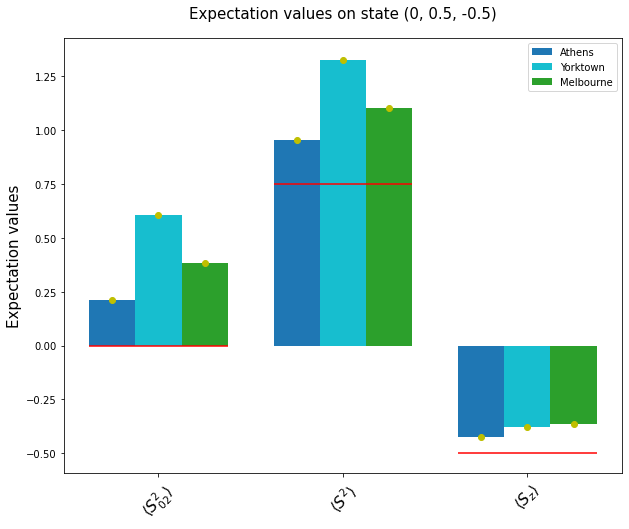

In [31]:
print("QASM with noise model")

# Mean values and standard deviation values for each hardware
values=[np.zeros((2,3)) for i in range(3)]

print("State label: ",l)
    
for count_hardware in range(3):
    #provider = IBMQ.get_provider(hub='ibm-q-internal',group='deployed') # CHOOSE THE GROUP OF HW (internal)
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    if count_hardware==0:
        device   = provider.get_backend('ibmq_athens')                        # 5 qubits, linear, good
        print("Hardware: ATHENS")
    elif count_hardware==1:
        device   = provider.get_backend('ibmq_5_yorktown')                    # 5 qubits, papillon, medium
        print("Hardware: YORKTOWN")
    else:
        device   = provider.get_backend('ibmq_16_melbourne')                  # 16 qubits, "ladder", bad
        print("Hardware: MELBOURNE")
    s=8092
    instance = QuantumInstance(backend                          = backend,
                               shots                            = s,
                               noise_model                      = NoiseModel.from_backend(device.properties()),
                               coupling_map                     = device.configuration().coupling_map,
                               optimization_level               = 3,
                               initial_layout                   = [0,1,2])

    print("Operator | Mean | Standard deviation")

    mu,sigma   = measure_operator(op_I,circ,instance)
    print("I",mu,np.sqrt(sigma/s))
        
    mu1,sigma1 = measure_operator(op_s022,circ,instance)
    print("S_{02}^2",mu1,np.sqrt(sigma1/s))
    values[count_hardware][0,0]=mu1
    values[count_hardware][1,0]=np.sqrt(sigma1/s)
        
    mu2,sigma2 = measure_operator(op_s2,circ,instance)
    print("S^2",mu2,np.sqrt(sigma2/s))
    values[count_hardware][0,1]=mu2
    values[count_hardware][1,1]=np.sqrt(sigma2/s)
        
    mu3,sigma3 = measure_operator(op_sz,circ,instance)
    print("S_z",mu3,np.sqrt(sigma3/s))
    values[count_hardware][0,2]=mu3
    values[count_hardware][1,2]=np.sqrt(sigma3/s)
        
    print("\n")
        
    
# Plot of S_{02}^2
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25
    
rects1 = ax.bar(x_lab - width, values[0][0], width, label='Athens',color='tab:blue')
ax.errorbar(x_lab - width,values[0][0],yerr=values[0][1],fmt='o',color='y')
ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
    
rects2 = ax.bar(x_lab, values[1][0], width, label='Yorktown',color='tab:cyan')
ax.errorbar(x_lab,values[1][0],yerr=values[1][1],fmt='o',color='y')
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
    
rects3 = ax.bar(x_lab + width, values[2][0], width, label='Melbourne',color='tab:green')
ax.errorbar(x_lab + width,values[2][0],yerr=values[2][1],fmt='o',color='y')
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r")
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values on state '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_{02}^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()
    

### - QASM simulation with noise model and (measurement) error mitigation

QASM with noise model
State label:  (0, 0.5, -0.5)
Hardware: ATHENS
Operator | Mean | Standard deviation
I 0.9999999999999998 2.4683815319126912e-18
S_{02}^2 0.15874483873307826 0.004306144386127085
S^2 0.8900466174015462 0.005805859764436805
S_z -0.4558576690749616 0.0028737022349857974


Hardware: YORKTOWN
Operator | Mean | Standard deviation
I 0.9999999999999998 2.4683815319126912e-18
S_{02}^2 0.26299842994008016 0.005441488903118496
S^2 0.9827216021730263 0.007405477560101888
S_z -0.48369848661035064 0.003023369992190362


Hardware: MELBOURNE
Operator | Mean | Standard deviation
I 1.0 0.0
S_{02}^2 0.18798185197130374 0.004664501578925392
S^2 0.9727012707601508 0.0072673234342072275
S_z -0.4253977076185861 0.0032959070911554754




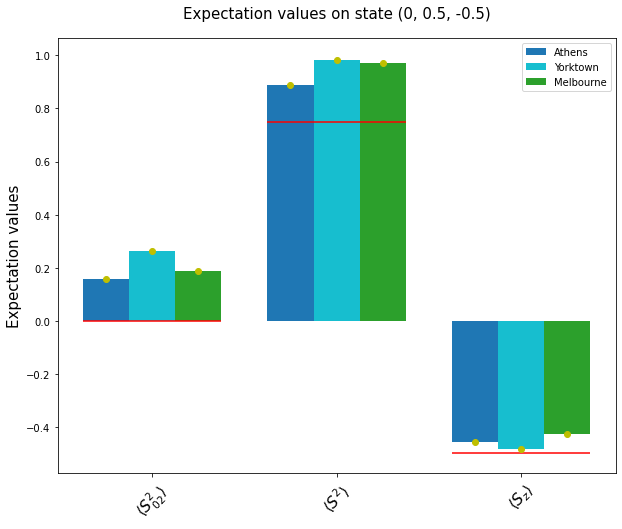

In [32]:
print("QASM with noise model")

# Mean values and standard deviation values for each hardware
values=[np.zeros((2,3)) for i in range(3)]

print("State label: ",l)
    
for count_hardware in range(3):
    #provider = IBMQ.get_provider(hub='ibm-q-internal',group='deployed') # CHOOSE THE GROUP OF HW (internal)
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    if count_hardware==0:
        device   = provider.get_backend('ibmq_athens')                        # 5 qubits, linear, good
        print("Hardware: ATHENS")
    elif count_hardware==1:
        device   = provider.get_backend('ibmq_5_yorktown')                    # 5 qubits, papillon, medium
        print("Hardware: YORKTOWN")
    else:
        device   = provider.get_backend('ibmq_16_melbourne')                  # 16 qubits, "ladder", bad
        print("Hardware: MELBOURNE")
    s=8092
    instance = QuantumInstance(backend                          = backend,
                               shots                            = s,
                               noise_model                      = NoiseModel.from_backend(device.properties()),
                               coupling_map                     = device.configuration().coupling_map,
                               measurement_error_mitigation_cls = CompleteMeasFitter,
                               optimization_level               = 3,
                               initial_layout                   = [0,1,2])

    print("Operator | Mean | Standard deviation")

    mu,sigma   = measure_operator(op_I,circ,instance)
    print("I",mu,np.sqrt(sigma/s))
        
    mu1,sigma1 = measure_operator(op_s022,circ,instance)
    print("S_{02}^2",mu1,np.sqrt(sigma1/s))
    values[count_hardware][0,0]=mu1
    values[count_hardware][1,0]=np.sqrt(sigma1/s)
        
    mu2,sigma2 = measure_operator(op_s2,circ,instance)
    print("S^2",mu2,np.sqrt(sigma2/s))
    values[count_hardware][0,1]=mu2
    values[count_hardware][1,1]=np.sqrt(sigma2/s)
        
    mu3,sigma3 = measure_operator(op_sz,circ,instance)
    print("S_z",mu3,np.sqrt(sigma3/s))
    values[count_hardware][0,2]=mu3
    values[count_hardware][1,2]=np.sqrt(sigma3/s)
        
    print("\n")
        
    
# Plot of expectation values
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25
    
rects1 = ax.bar(x_lab - width, values[0][0], width, label='Athens',color='tab:blue')
ax.errorbar(x_lab - width,values[0][0],yerr=values[0][1],fmt='o',color='y')
ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
    
rects2 = ax.bar(x_lab, values[1][0], width, label='Yorktown',color='tab:cyan')
ax.errorbar(x_lab,values[1][0],yerr=values[1][1],fmt='o',color='y')
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
    
rects3 = ax.bar(x_lab + width, values[2][0], width, label='Melbourne',color='tab:green')
ax.errorbar(x_lab + width,values[2][0],yerr=values[2][1],fmt='o',color='y')
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r")
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values on state '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_{02}^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()

Besides the use of the errore mitigation, the results don't seem promising.

Look at: https://qiskit.org/textbook/ch-applications/hhl_tutorial.html#B.-Running-HHL-on-a-real-quantum-device:-optimised-example. This mitigation error procedure is equal to the previous used.

## All CG circuits - QASM simulation with noise model, error mitigation and Richardson extrapolation

We know use the qasm simulation using a **fixed number of shots** ($8092$) with the noise model of the device **IBM Athens** and we add the error corrections. We start by adding only the (measurement) error mitigation and then the Richardson extrapolation to correct the errors on gates.

We notice again that we are considering the circuits of type **B** (swap between the second and third qubit). As a  consequence, we have that the last **CNOT** gate of the circuit is analyzed using $2$ **SWAP** gates in addition.

In [14]:
IBMQ.load_account()                                                  # connettersi a IBMQ

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device   = provider.get_backend('ibmq_athens')                        # 5 qubit, lineare, buono
#device   = provider.get_backend('ibmq_5_yorktown')                   # 5 qubit, papillon, medio
#device   = provider.get_backend('ibmq_16_melbourne')                 # 16 qubit, "ladder", cattivo
backend  = Aer.get_backend('qasm_simulator')                          # in verita' tutto sul tuo laptop!

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


We are going to plot the histogram with the expectation values on operators $\hat{S}_{02}^2$, $\hat{S}^2$ and $\hat{S}_z$. We are going to use the following abbreviations in the legend:

- **NM** : Noise Model
- **EM** : Error Mitigation (correction on measurement)
- **RE** : Richardson Extrapolation (correction on gates)

**Remarks**

- It's important to notice how the mean and the variance are computed inside the **Richardson extrapolation**. We use the method of **linear regression** to compute those two values. If $y=q+mx$ is the equation of the straight line which represent the model, $m$ is the slope of the line, $x$ is the number of **CNOT** gates and $y$ is the value of the expectation value, the mean at $x=0$ is exactly $q$. If $y_1$ is the mean with $1$ CNOT and $y_3$ is the mean with $3$ CNOTs, we have that:

  $$m=\frac{y_1-q}{1}=\frac{y_3-y_1}{2} \Rightarrow q=y_1 + \frac{y_1 - y_3}{2}$$

  The variance $\sigma_q$ on $q$ is given starting by the variances on $y_1$ and $y_3$. Indeed, using the rules of   variance:

  $$\sigma_q^2=\sigma_{y_1}^2 + \frac{1}{4}\sigma_{y_1}^2 + \frac{1}{4}\sigma_{y_3}^2$$

- We are going to transpile the circuits using different optimization levels and layouts in order to take the circuit with minimal depth. When we execute the measurement we give to the `measure_operator` function the untouched circuit, the operator to be evaluated and the `QuantumInstance` with best layout and optimization level.

####  Definition of the standard deviation for extrapolated value at $N_{CNOT} =0$

In [15]:
def extr_dev_std(x,sigma):
    s   = 0
    sx  = 0
    sx2 = 0
    for i in range(len(x)):
        sx  += x[i]
        sx2 += x[i]**2
    delta = len(x)*sx2 - sx**2
    
    for j,xj in enumerate(x):
        s += (sx2**2 + -2*xj*sx*sx2 + (sx**2)*(xj**2))*(sigma[j]**2)
    return np.sqrt(s/(delta**2))

def straight_line(x,m,q):
    return m*x+q

CIRCUIT of  (0, 0.5, -0.5)
              ┌───┐┌───┐          ┌───┐┌───┐               
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──
     ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  
q_1: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──
     └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐
q_2: ───────────────────┤ X ├───────────────┤ X ├─────┤ X ├
                        └───┘               └───┘     └───┘
BEFORE TRANSPILATION - Operations =  OrderedDict([('cx', 5), ('ch', 2), ('x', 2), ('ry', 1)])  , Depth =  9
AFTER TRANSPILATION - Operations =  OrderedDict([('cx', 10), ('rz', 7), ('sx', 6), ('x', 2)])  , Depth =  20
CIRCUIT of  (0, 0.5, 0.5)
              ┌───┐┌───┐          ┌───┐┌───┐               
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├────────────■──
     ┌───────┐└─┬─┘└─┬─┘     ┌───┐└─┬─┘└─┬─┘     ┌───┐  │  
q_1: ┤ RY(0) ├──■────■────■──┤ X ├──■────■────■──┤ X ├──┼──
     └───────┘          ┌─┴─┐└───┘          ┌─┴─┐└───┘┌─┴─┐
q_2: ─────

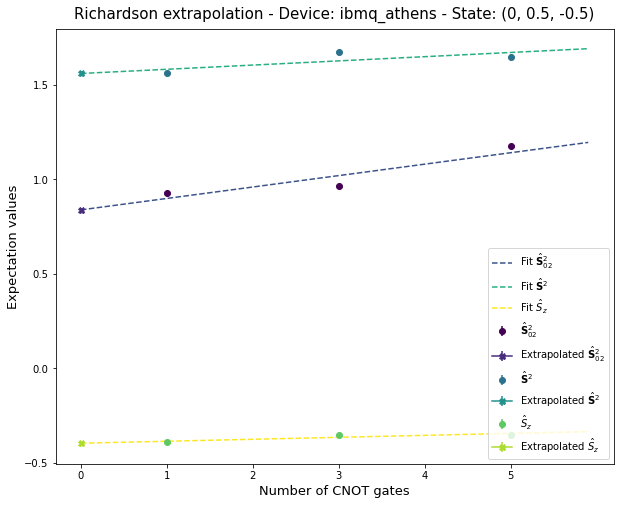

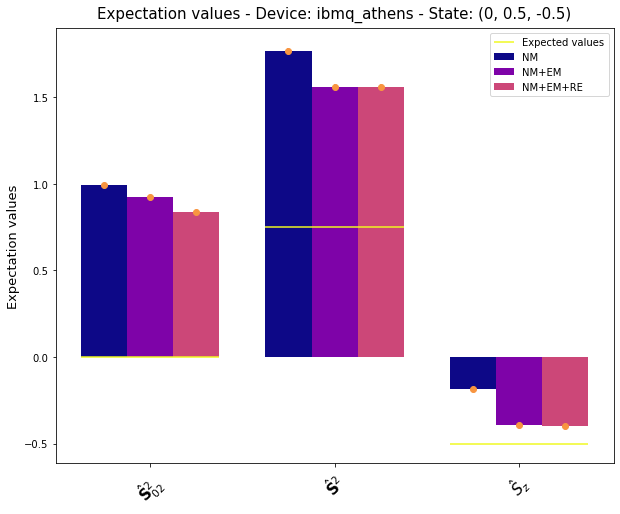

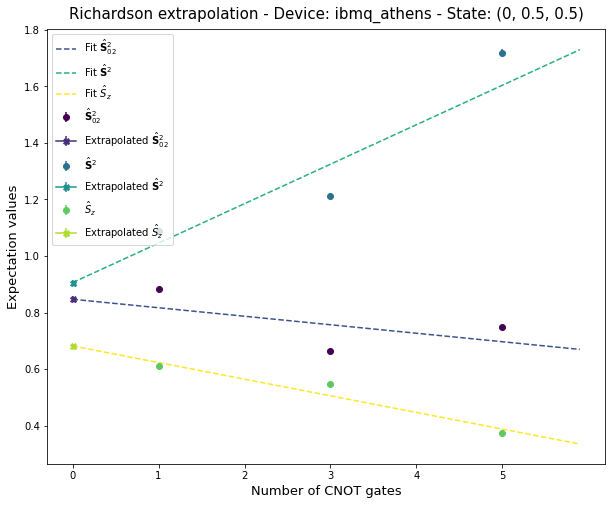

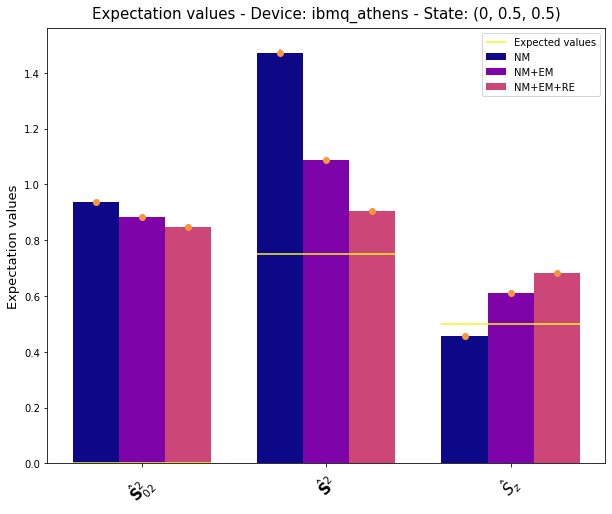

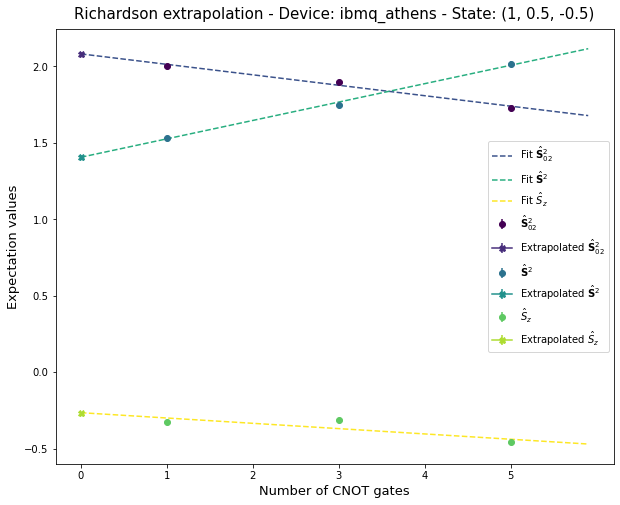

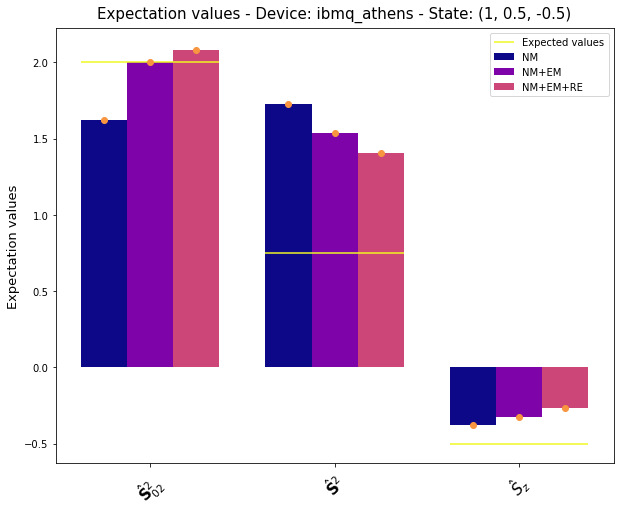

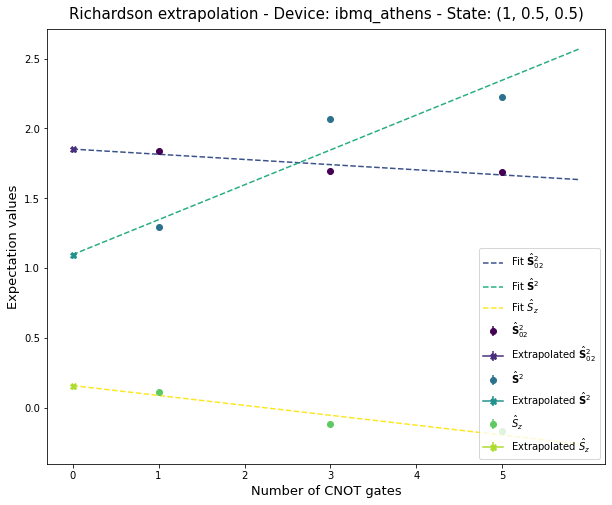

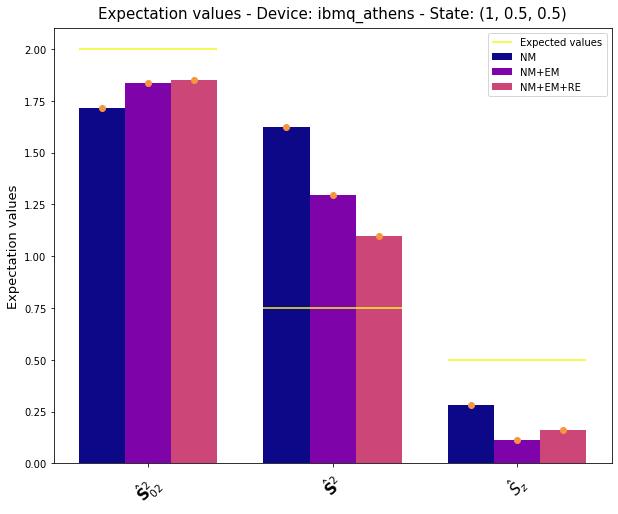

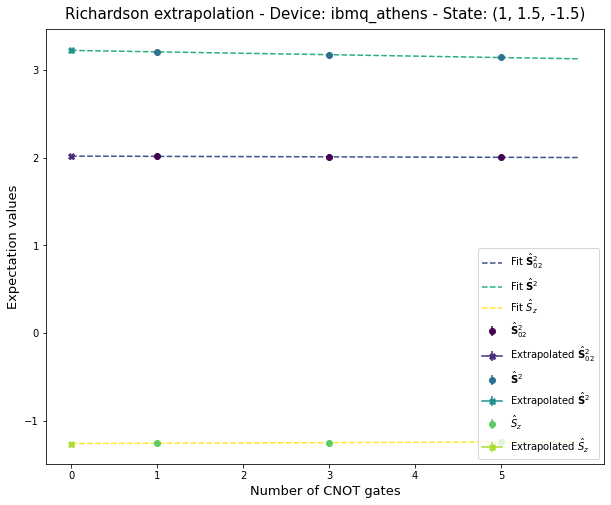

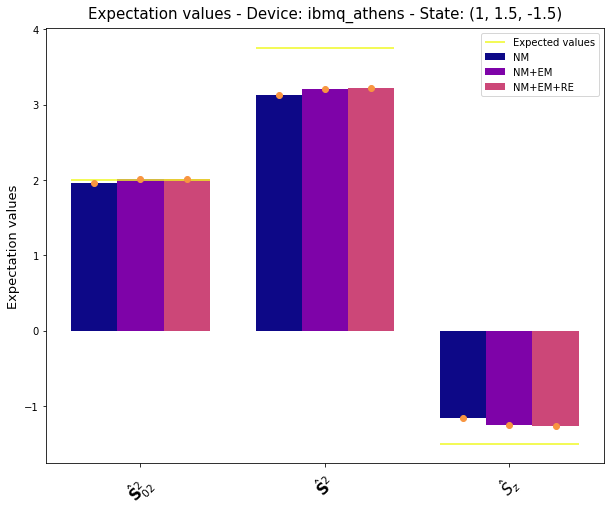

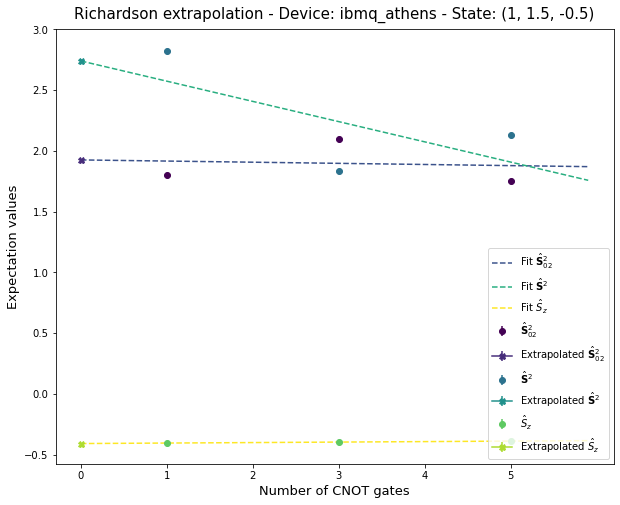

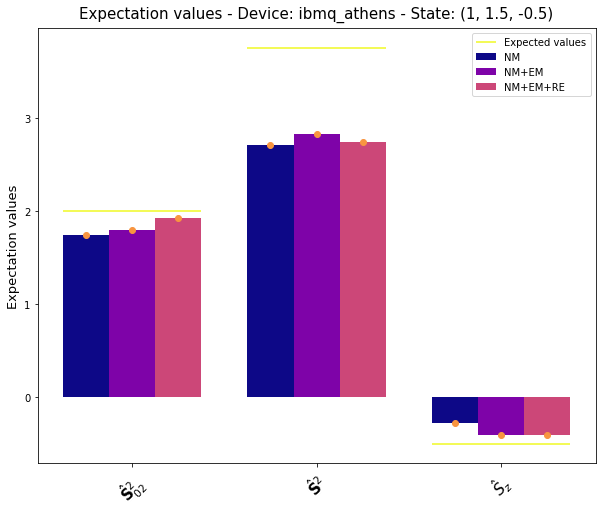

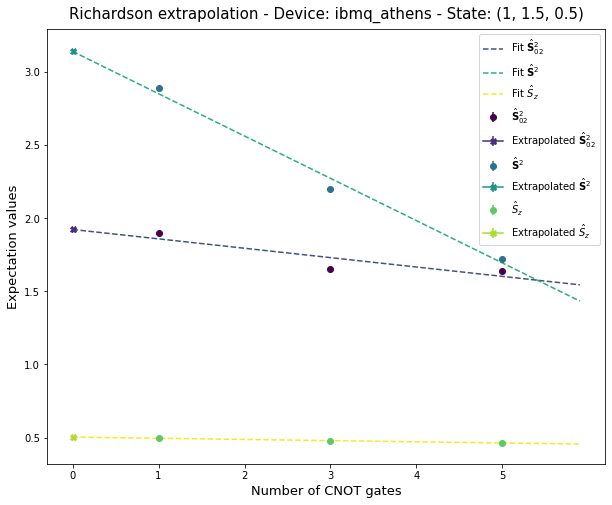

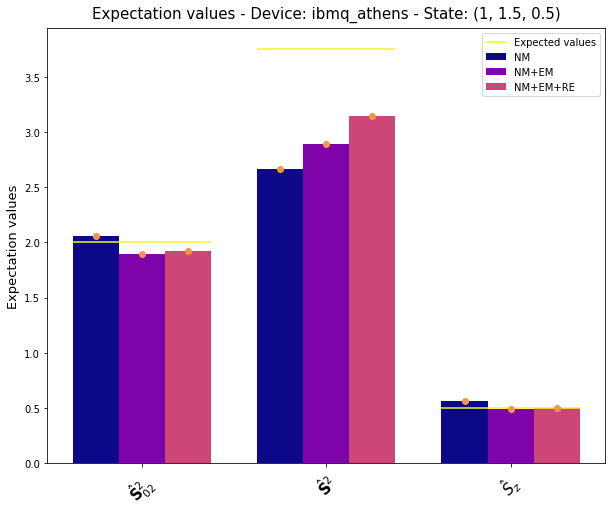

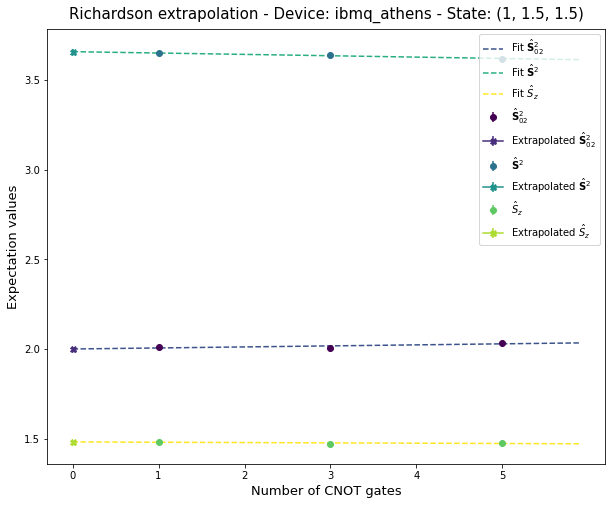

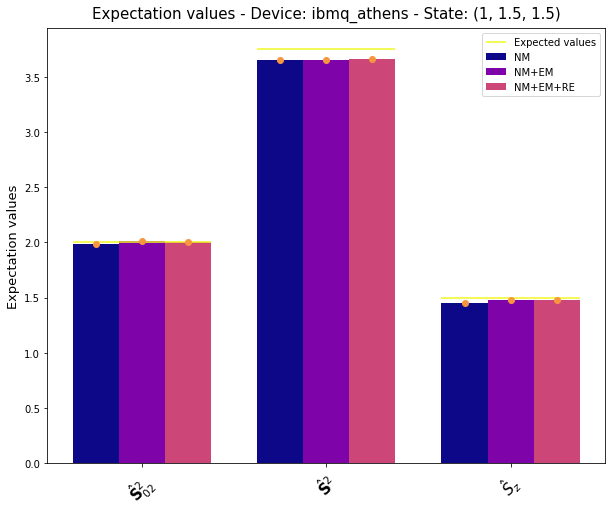

In [21]:
s=8092
nqubits = 3
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

for il,l in enumerate(lab_list):
    qr      = QuantumRegister(nqubits,'q')
    circ    = QuantumCircuit(qr)

    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

    circ.ry(2*theta,1)                                            # Remember that we need to insert 2*theta

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        # Alternative way to create a controlled-Hadamard
        #c_gate = HGate().control(1)
        #circ.append(c_gate,[1,0])
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]+0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]+0.5==-1:
            circ.cx(1,0)

    circ.x(1)

    if l[0]==0:
        circ.cx(1,0)
        circ.ch(1,0)
        circ.cx(1,2)

    elif l[0]==1:
        if l[2]-0.5==0:
            circ.ch(1,0)
            circ.cx(1,2)
        elif l[2]-0.5==-1:
            circ.cx(1,0)

    circ.x(1)
    circ.cx(0,2)
    print("CIRCUIT of ",l)
    print(circ.draw())
    print("BEFORE TRANSPILATION - Operations = ",circ.count_ops()," , Depth = ",circ.depth())
    
    optimal_circuit = circ
    optimal_perm    = [0,1,2]
    min_depth       = 1000
    optimal_level   = 3

    for level in [0,1,2,3]:
        if np.all(l==lab_list[2]) or np.all(l==lab_list[5]):
            print("Circuit equal after transpilation")
            break
        for idx in itertools.permutations([0,1,2]):
            from qiskit.compiler import transpile
            qc_transpiled = transpile(circ,device,optimization_level=level,initial_layout=list(idx))
            #print("With order  ",idx," and level ",level)
            #print("OPERATIONS: ",qc_transpiled.count_ops())
            #print("DEPTH:      ",qc_transpiled.depth(),"\n")
            if(qc_transpiled.depth()<min_depth):
                min_depth       = qc_transpiled.depth()
                optimal_perm    = list(idx)
                optimal_level   = level
                optimal_circuit = qc_transpiled
    
    #print(optimal_circuit.draw())
    print("AFTER TRANSPILATION - Operations = ",optimal_circuit.count_ops()," , Depth = ",optimal_circuit.depth())
    
    # Noise model
    instance = QuantumInstance(backend                          = backend,
                               shots                            = s,
                               noise_model                      = NoiseModel.from_backend(device.properties()),
                               coupling_map                     = device.configuration().coupling_map,
                               optimization_level               = optimal_level,
                               initial_layout                   = optimal_perm)
    res_raw=[]
    res_raw.append(measure_operator(op_s022,circ,instance))
    res_raw.append(measure_operator(op_s2,circ,instance))
    res_raw.append(measure_operator(op_sz,circ,instance))
    
    '''
    print("QASM, noise model raw ")
    print("Operator | Mean | Standard Deviation")
    for i in range(len(res_raw)):
        if i==0:
            print("S_{02}^2 ",res_raw[i][0],np.sqrt(res_raw[i][1]/s))
        elif i==1:
            print("S^2 ",res_raw[i][0],np.sqrt(res_raw[i][1]/s))
        else:
            print("S_z ",res_raw[i][0],np.sqrt(res_raw[i][1]/s))
    '''
    
    # Noise model + measurement error mitigation
    instance = QuantumInstance(backend                          = backend,
                               shots                            = 8092,
                               noise_model                      = NoiseModel.from_backend(device.properties()),
                               coupling_map                     = device.configuration().coupling_map,
                               measurement_error_mitigation_cls = CompleteMeasFitter, # <=====
                               optimization_level               = optimal_level,
                               initial_layout                   = optimal_perm)
    res_1=[]
    res_1.append(measure_operator(op_s022,circ,instance))
    res_1.append(measure_operator(op_s2,circ,instance))
    res_1.append(measure_operator(op_sz,circ,instance))
    
    '''
    print("QASM, noise model RO error mitigation ")
    print("Operator | Mean | Standard Deviation")
    for i in range(len(res_1)):
        if i==0:
            print("S_{02}^2 ",res_1[i][0],np.sqrt(res_1[i][1]/s))
        elif i==1:
            print("S^2 ",res_1[i][0],np.sqrt(res_1[i][1]/s))
        else:
            print("S_z ",res_1[i][0],np.sqrt(res_1[i][1]/s),"\n")
    '''
    # Noise model + measurement error mitigation + Richardson extrapolation
    # RE WITH 3 CNOTs
    qr      = QuantumRegister(nqubits,'q')
    circ_R  = QuantumCircuit(qr)

    for g in circ: # loop over gates in circ
        instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
        #print(instruction.name)
        if(instruction.name=='cx'): # if cnot, replicate
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
        elif(instruction.name=='u3'): # if u3, copy and paste
            t1,t2,t3 = instruction.params
            circ_R.u3(t1,t2,t3,qubits[0])
        elif(instruction.name=='x'):
            circ_R.x(qubits[0])
        elif(instruction.name=='ry'): # if ry, copy and paste
            t1 = instruction.params[0]
            circ_R.ry(t1,qubits[0])
        elif(instruction.name=='ch'):
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
        else:
            print("!!! ",instruction)

    #print(circ_R.draw())

    res_3=[]
    res_3.append(measure_operator(op_s022,circ_R,instance))
    res_3.append(measure_operator(op_s2,circ_R,instance))
    res_3.append(measure_operator(op_sz,circ_R,instance))
    
    '''
    print("QASM, noise model R-3, RO error mitigation ")
    print("Operator | Mean | Standard Deviation")
    for i in range(len(res_3)):
        if i==0:
            print("S_{02}^2 ",res_3[i][0],np.sqrt(res_3[i][1]/s))
        elif i==1:
            print("S^2 ",res_3[i][0],np.sqrt(res_3[i][1]/s))
        else:
            print("S_z ",res_3[i][0],np.sqrt(res_3[i][1]/s),"\n")
    '''
    
    # RE WITH 5 CNOTs
    qr      = QuantumRegister(nqubits,'q')
    circ_R  = QuantumCircuit(qr)

    for g in circ: # loop over gates in circ
        instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
        #print(instruction.name)
        if(instruction.name=='cx'): # if cnot, replicate
            for k in range(5):
                circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
        elif(instruction.name=='u3'): # if u3, copy and paste
            t1,t2,t3 = instruction.params
            circ_R.u3(t1,t2,t3,qubits[0])
        elif(instruction.name=='x'):
            circ_R.x(qubits[0])
        elif(instruction.name=='ry'): # if ry, copy and paste
            t1 = instruction.params[0]
            circ_R.ry(t1,qubits[0])
        elif(instruction.name=='ch'):
            for k in range(5):
                circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
        else:
            print("!!! ",instruction)

    #print(circ_R.draw())

    res_5=[]
    res_5.append(measure_operator(op_s022,circ_R,instance))
    res_5.append(measure_operator(op_s2,circ_R,instance))
    res_5.append(measure_operator(op_sz,circ_R,instance))
    
    res_richardson =[] 
    # In the case of RE only with multiplication by 3 CNOTs
    #for i in range(len(res_1)):
    #    res_richardson.append( (res_1[i][0]+(res_1[i][0]-res_3[i][0])/2.0 , res_1[i][1]+(res_1[i][1]+res_3[i][1])/4.0 ))
    
    # Richardson extrapolation analysis
    jet = plt.get_cmap('viridis')
    colors = iter(jet(np.linspace(0,1,9)))
    
    plt.figure(figsize=(10,8))
    op_labels=[r"$\hat{\mathbf{S}}_{02}^2$",r"$\hat{\mathbf{S}}^2$",r"$\hat{S}_z$"]
    
    for j in range(3):
        # Data
        plt.errorbar([1,3,5],[res_1[j][0],res_3[j][0],res_5[j][0]],yerr=[np.sqrt(res_1[j][1]/s),np.sqrt(res_3[j][1]/s),np.sqrt(res_5[j][1]/s)],marker='o',ls="none",label=op_labels[j],color=next(colors))
        # Extrapolated data
        p_ave,p_cov = curve_fit(straight_line,[1,3,5],[res_1[j][0],res_3[j][0],res_5[j][0]],sigma=[np.sqrt(res_1[j][1]/s),np.sqrt(res_3[j][1]/s),np.sqrt(res_5[j][1]/s)],absolute_sigma=True)                                                                                    
        plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j], color=next(colors))
        res_richardson.append((p_ave[1],np.sqrt(p_cov[1,1])))
        # Fit
        u = list(np.arange(0,6,0.1))
        v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
        plt.plot(u,v,'--',label='Fit '+op_labels[j], color=next(colors))
        
    plt.title("Richardson extrapolation - Device: ibmq_athens - State: "+str(l),size=15,pad=10)
    plt.xlabel("Number of CNOT gates",size=13)
    plt.xticks(np.arange(6))
    plt.ylabel("Expectation values",size=13)
    plt.legend()
    if il==0 or il==5:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/CG_qasm_3_RE_"+str(il)+".pdf")
    
    # The histograms - Plot of expectation values
    jet = plt.get_cmap('plasma')
    colors = jet(np.linspace(0,1,5))
    
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    data=[]
    err_data=[]
    for el in res_raw:
        data.append(el[0])
        err_data.append(np.sqrt(el[1]/s))

    rects1 = ax.bar(x_lab - width, data, width, label='NM',color=colors[0])
    ax.errorbar(x_lab - width,data,yerr=err_data,fmt='o',color=colors[3])
    
    data=[]
    err_data=[]
    for el in res_1:
        data.append(el[0])
        err_data.append(np.sqrt(el[1]/s))

    rects2 = ax.bar(x_lab, data, width, label='NM+EM',color=colors[1])
    ax.errorbar(x_lab,data,yerr=err_data,fmt='o',color=colors[3])
    
    data=[]
    err_data=[]
    for el in res_richardson:
        data.append(el[0])
        err_data.append(el[1])        # Already standard deviation from extr_dev_std

    rects3 = ax.bar(x_lab + width, data, width, label='NM+EM+RE',color=colors[2])    
    ax.errorbar(x_lab + width,data,yerr=err_data,fmt='o',color=colors[3])
    
    c = colors[4]
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors=c)
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors=c)
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors=c,label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=13)
    ax.set_title(r'Expectation values - Device: ibmq_athens - State: '+str(l),fontsize=15,pad=10)
    ax.set_xticks(x_lab)
    ax.set_xticklabels(op_labels,rotation=45,size=15)
    ax.legend()
    if il==0 or il==5:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/CG_qasm_3_"+str(il)+".pdf")
    

### Overall considerations on CG circuits

- The first circuits are the ones with bigger depth and they give worse results even in the case of all corrections.

- The use of the transpilation with the best parameters for the optimization level and layout show a significant lowering of the depth of the circuit.


# Analysis of gradients for VQE

Working on the gradient is an important aspect of the VQE simulation. By default each optimizer called by the VQE algorithm works on **finite differences**. In the following we are going to use the `Gradient` class of *Qiskit* ( https://qiskit.org/documentation/tutorials/operators/02_gradients_framework.html#grad_state ), which allows to work with the following methods: 

- *linear combination* $\rightarrow$ **analytical**
- *parameter shift* $\rightarrow$ **analytical**
- *finite differences* $\rightarrow$ **non analytical**

For more information look at: */Tesi/Scripts/Gradients/gradients.py*.

### Cost function and corresponding gradient for total spin selection

We want to use the `find_minimum` algorithm of **VQE** function to find the eigenstates of total spin $\hat{S}$ by using the following cost function:

$$C(s_L,s,s_z) = \biggl( \langle \hat{S}_L^2 \rangle - s_L(s_L+1) \biggl)^2 + \biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl)^2 + \biggl( \langle \hat{S}_z \rangle - s_z \biggl)^2$$

where the values inside the brackets are parameters which are used to select the total spin state we are looking for and the expectation values refer to the variational state $\psi(\vec{\theta})$, which is created step by step during the optimization. $\vec{\theta} = (\theta_1, ...,\theta_n)^T$ is the vector of parameters on which the variational state $\psi(\vec{\theta})$ depends. If $\hat{O}$ is a generic operator:

$$\langle \hat{O} \rangle = \langle \psi(\vec{\theta})| \hat{O} |\psi(\vec{\theta}) \rangle$$

The gradient of the cost function is a vector composed by the derivatives of the cost function with respect to each parameter $\theta_i$ ($i=1,...,n$):

$$\frac{\partial{C(s_L,s,s_z)}}{\partial{\theta_i}} = 2 \biggl( \langle \hat{S}_L^2 \rangle - s_L(s_L+1) \biggl) \frac{\partial{\langle \hat{S}_L^2 \rangle}}{\partial{\theta_i}} + 2 \biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl) \frac{\partial{\langle \hat{S}^2 \rangle}}{\partial{\theta_i}} + 2 \biggl( \langle \hat{S}_z \rangle - s_z \biggl) \frac{\partial{\langle \hat{S}_z \rangle}}{\partial{\theta_i}}$$

The following functions evaluate the cost function and the corresponding gradient by using the measurement operation. It's important to notice that the following functions take as argument only the values of the parameters, but they consider inside that the `QuantumInstance`, the `SummedOp` operators ($S_L^2$, $S^2$ and $S_z$), the `List` label $l$ (`lab_list[i]` with $i=0,...,7$) and the `Gradient` function are already defined. 

**Important consideration** I think that the use of the class `Gradient` on the cost function `spin_cost` doesn't really give the analytical derivative because the VQE cost function is given in terms of a numerical value, instead of the `OperatorBase` class. In the following I will give an example.

In [92]:
def spin_cost(x):
    # QASM - Expectation values
    circ=var_form.assign_parameters(x)

    braket1=StateFn(op_sl2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket1)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f1=sampled_op.eval().real                                        # Get expectation value

    braket2=StateFn(op_s2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket2)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f2=sampled_op.eval().real                                        # Get expectation value

    braket3=StateFn(op_sz,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket3)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f3=sampled_op.eval().real                                        # Get expectation value

    return (f1-l[0]*(l[0]+1))**2 + (f2-l[1]*(l[1]+1))**2 + (f3-l[2])**2

def grad_spin_cost(x):
    
    # Here we create the dictionary which associates at each Parameter the corresponding value
    pv=var_form.ordered_parameters
    par={pv[i] : x[i] for i in range(len(pv))}
    
    # QASM
    # Expectation values
    circ=var_form.assign_parameters(x)

    braket1=StateFn(op_sl2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket1)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f1=sampled_op.eval().real                                        # Get expectation value

    braket2=StateFn(op_s2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket2)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f2=sampled_op.eval().real                                        # Get expectation value

    braket3=StateFn(op_sz,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket3)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f3=sampled_op.eval().real                                        # Get expectation value
    
    # Gradients
    state_grad1=grad.convert(operator=~StateFn(op_sl2) @ CircuitStateFn(primitive=var_form),params=pv)
    state_grad2=grad.convert(operator=~StateFn(op_s2) @ CircuitStateFn(primitive=var_form),params=pv)
    state_grad3=grad.convert(operator=~StateFn(op_sz) @ CircuitStateFn(primitive=var_form),params=pv)

    g1=[np.real(el) for el in state_grad1.assign_parameters(par).eval()]
    g2=[np.real(el) for el in state_grad2.assign_parameters(par).eval()]
    g3=[np.real(el) for el in state_grad3.assign_parameters(par).eval()]

    grad_val=[]
    for i in range(len(g1)):
        grad_val.append(2*(f1-l[0]*(l[0]+1))*g1[i] + 2*(f2-l[1]*(l[1]+1))*g2[i] + 2*(f3-l[2])*g3[i])

    return grad_val

### Comparison of  the $3$ `Gradient` methods inside `grad_spin_cost`: gradient results and running time

In [94]:
#Example case
l=lab_list[0]

x=np.arange(var_form.num_parameters)
t0 = time.time()
cost_val=spin_cost(x)
#print(type(cost_val))
t1 = time.time()

print("Cost function value: ", cost_val)
print(" Time [s] = ",t1-t0,"\n")

print("---------------------------------")
print("Gradient cost function 'handmade'")
print("---------------------------------")


grad=Gradient("fin_diff")
t0 = time.time()
grad_val=grad_spin_cost(x)
t1 = time.time()

print("FINITE DIFFERENCE gradient value: ", grad_val)
print(" Time [s] = ",t1-t0,"\n")

grad=Gradient("param_shift")
t0 = time.time()
grad_val=grad_spin_cost(x)
t1 = time.time()

print("PARAMETER SHIFT gradient value: ", grad_val)
print(" Time [s] = ",t1-t0,"\n")

grad=Gradient("lin_comb")
t0 = time.time()
grad_val=grad_spin_cost(x)
t1 = time.time()

print("LINEAR COMBINATION gradient value: ", grad_val)
print(" Time [s] = ",t1-t0)

Cost function value:  7.631709765625002
 Time [s] =  20.917622804641724 

---------------------------------
Gradient cost function 'handmade'
---------------------------------
FINITE DIFFERENCE gradient value:  [0.43836247470442347, -4.617812620810747, 0.2249446087880604, -0.66325944530965, -5.991755612955162, -3.503579390696946, 1.425475016869863, 3.7319226132632584, 1.8392516272176622, -2.3061360853805466, -0.44017549940120104, 4.547490893039075]
 Time [s] =  26.98094081878662 

PARAMETER SHIFT gradient value:  [0.45701477250717226, -4.670182020976067, 0.2094308973810996, -0.6602663371801272, -6.066843478151008, -3.567504253589794, 1.4326344291597453, 3.7671230301271628, 1.8596045519723037, -2.3396136838933566, -0.4678742625450263, 4.6150116710033435]
 Time [s] =  26.99471616744995 

LINEAR COMBINATION gradient value:  [0.477260340872659, -4.706849689341608, 0.18579742243623573, -0.6484963137202131, -6.121104901577951, -3.6225740298420677, 1.4263751032904937, 3.782762213807846, 1.867

The differences between the values are a consequence of the use of the **QASM** simulation.

### Example of QASM simulation with `spin_cost` and `grad_spin_cost` (with `Gradient("lin_comb")`)

Now we want to analyze the results of a **QASM simulation with noise model** ($8000$ shots and hardware *Athens*) when we use the 'handmade' gradient function (`grad_spin_cost`) .

We use as example the case in which we want to find the state $|s_L=0,s=1/2,s_z=-1/2 \rangle$ and we start by showing the evaluation time of the cost function.

#### Definition of ansatz and hardware device 

Number of parameters:  12
Variational form - RY Circuit


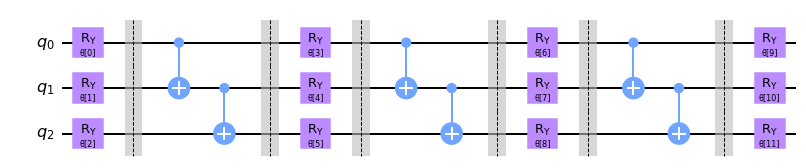

In [12]:
psi_1= Zero(3)
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
print("Number of parameters: ",var_form.num_parameters)
print("Variational form - RY Circuit")
var_form.draw(output='mpl')

In [9]:
# QASM simulation with IBM device
IBMQ.load_account()
backend  = Aer.get_backend('qasm_simulator')  
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device   = provider.get_backend('ibmq_athens')                        # 5 qubits, linear, good
instance = QuantumInstance( backend                          = backend,
                            shots                            = 8000,
                            noise_model                      = NoiseModel.from_backend(device.properties()),
                            coupling_map                     = device.configuration().coupling_map,
                            optimization_level               = 3,
                            initial_layout                   = [0,1,2])

ibmqfactory.load_account:WARNING:2021-04-21 18:20:45,155: Credentials are already in use. The existing account in the session will be replaced.


#### The simulation

In [95]:
shot_list=[100,200,500,1000,2000,4000,8000]

# Definition of the gradient function 
grad = Gradient(grad_method='lin_comb')

# Here we store the convergence outcomes coming from each state label
cost_conv=[[] for i in range(len(lab_list))]

# State label 
l=lab_list[0]
    
# Definition of instance and VQE
instance = QuantumInstance(backend = backend, shots = 100)
algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07),quantum_instance=instance)
min_val=algo.find_minimum(cost_fn=spin_cost,optimizer=CG(maxiter=70,gtol=1e-10),gradient_fn=grad_spin_cost)

In [96]:
print("QASM simulation with 100 shots")
print("Cost function: ",min_val["optimal_value"])

QASM simulation with 100 shots
Cost function:  7.703719777548943e-32


# $3$-spin case - VQE with spin-based cost function

We are going to start a simulation which uses the following variational parameters:

- **RY** variational form with depth $3$
- Initial state $|0 \rangle^{\otimes 3}$
- **CG** (Conjugate Gradient) optimizer

## VQE - QASM simulation with noise model, error mitigation and Richardson extrapolation

**Remarks**

- In the following sections there will be a table which shows the values of fidelities and cost function. It's important to notice that those values belong on the particular simulation we have run and they cannot be used for a statistical inference of the behavior of the hardware devices.

### (A) `cost_fn=spin_cost_mat` working on matrices, `grad_fn=Gradient("lin_comb")`

### Supposed to be a STATEVECTOR simulation with  `Gradient("lin_comb")`

We use the `spin_cost_mat` function which works on **matrices** and `Gradient("lin_comb")` as gradient function.

We know use the **QASM** simulation with noise model using:
- **fixed number of shots** ($8092$) 
- hardware device **IBM Athens** 

#### Definition of cost function working on matrices

In [ ]:
def spin_cost_mat(v,l,J,M):
    l2=l*(l+1)
    J2=J*(J+1)
    op1=(np.dot(np.dot(np.conjugate(v),mat_sl2),v)-l2)**2
    op2=(np.dot(np.dot(np.conjugate(v),mat_s2),v)-J2)**2
    op3=(np.dot(np.dot(np.conjugate(v),mat_sz),v)-M)**2
    return op1+op2+op3

#### VQE algorithm

In [36]:
from qiskit.aqua.operators.gradients import Gradient

# Here we store the outcomes coming from each state label
values=[[] for i in range(len(lab_list))]
grad = Gradient(grad_method='lin_comb')


for il,l in enumerate(lab_list):
    print("State - ",l)
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost_mat(circ_v,l[0],l[1],l[2])
        return val
    
    # Noise model
    instance = QuantumInstance(backend                          = backend,
                               shots                            = s,
                               noise_model                      = NoiseModel.from_backend(device.properties()),
                               coupling_map                     = device.configuration().coupling_map,
                               optimization_level               = 3,
                               initial_layout                   = [0,1,2])
    
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07),quantum_instance=instance)
    values[il].append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10),gradient_fn=grad))
    
    # Noise model + measurement error mitigation
    instance = QuantumInstance(backend                          = backend,
                               shots                            = 8092,
                               noise_model                      = NoiseModel.from_backend(device.properties()),
                               coupling_map                     = device.configuration().coupling_map,
                               measurement_error_mitigation_cls = CompleteMeasFitter, # <=====
                               optimization_level               = 3,
                               initial_layout                   = [0,1,2])
    
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07),quantum_instance=instance)
    values[il].append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10),gradient_fn=grad))

State -  (0, 0.5, -0.5)
State -  (0, 0.5, 0.5)
State -  (1, 0.5, -0.5)
State -  (1, 0.5, 0.5)
State -  (1, 1.5, -1.5)


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


State -  (1, 1.5, -0.5)
State -  (1, 1.5, 0.5)


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary 

State -  (1, 1.5, 1.5)


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


#### Histograms of expectation values

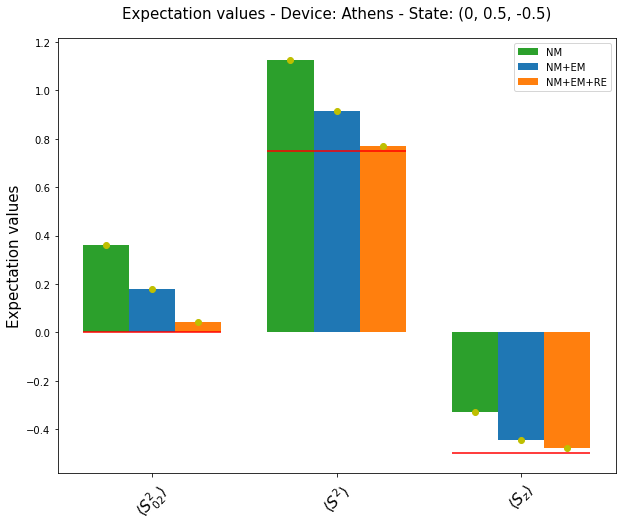

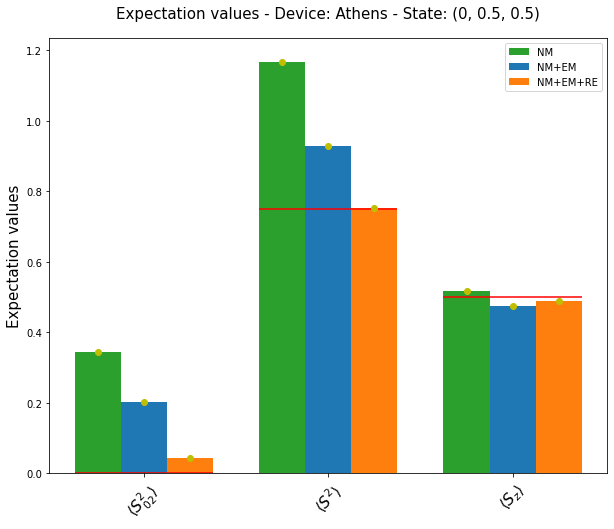

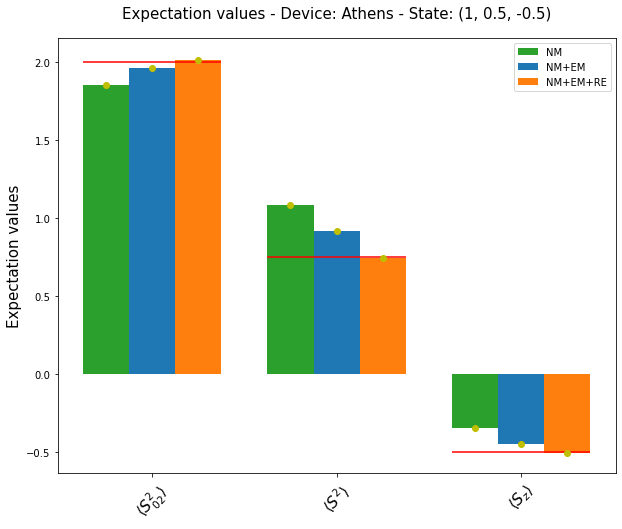

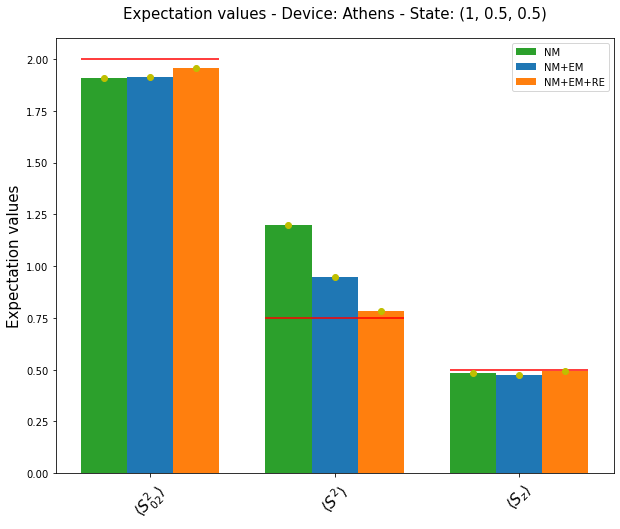

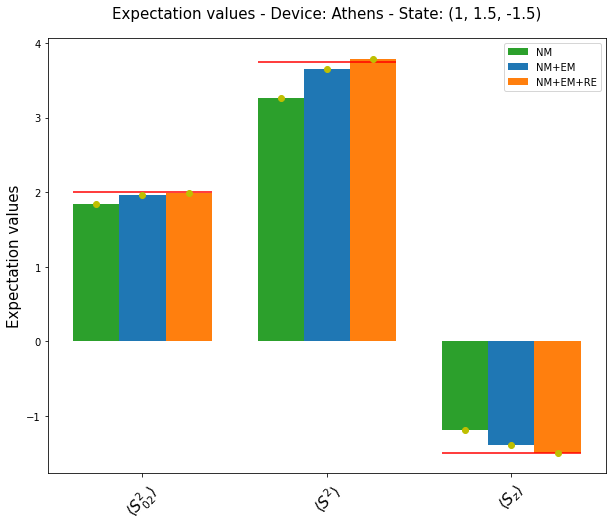

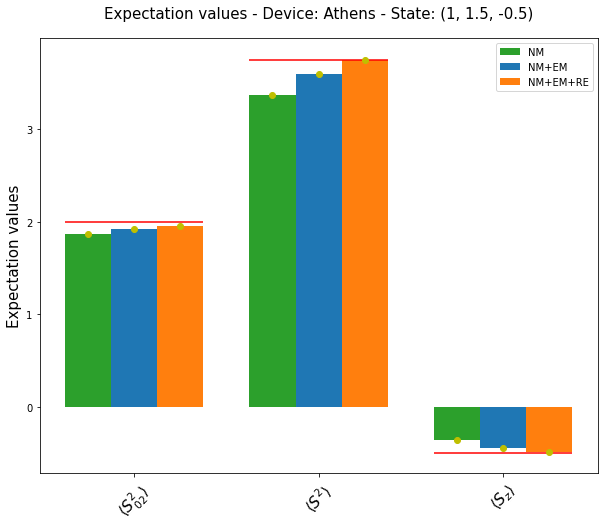

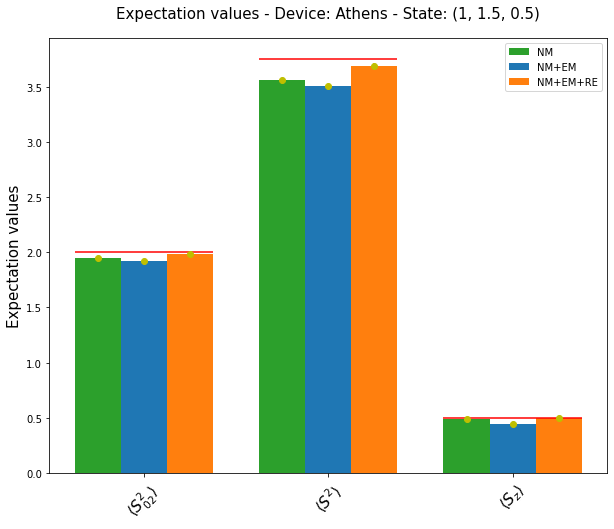

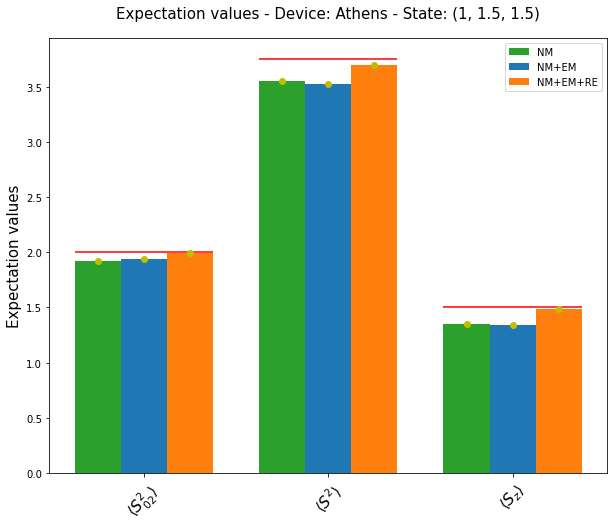

In [38]:
nqubits=3
for il,l in enumerate(lab_list):   
    # Noise model
    instance = QuantumInstance(backend                          = backend,
                               shots                            = s,
                               noise_model                      = NoiseModel.from_backend(device.properties()),
                               coupling_map                     = device.configuration().coupling_map,
                               optimization_level               = 3,
                               initial_layout                   = [0,1,2])
    
    circ=var_form.assign_parameters(np.real(values[il][0]['optimal_point'])) 
    
    res_raw=[]
    res_raw.append(measure_operator(op_sl2,circ,instance))
    res_raw.append(measure_operator(op_s2,circ,instance))
    res_raw.append(measure_operator(op_sz,circ,instance))
    
    '''
    print("QASM, noise model raw ")
    print("Operator | Mean | Standard Deviation")
    for i in range(len(res_raw)):
        if i==0:
            print("S_{L}^2 ",res_raw[i][0],np.sqrt(res_raw[i][1]/s))
        elif i==1:
            print("S^2 ",res_raw[i][0],np.sqrt(res_raw[i][1]/s))
        else:
            print("S_z ",res_raw[i][0],np.sqrt(res_raw[i][1]/s))
    '''
    
    # Noise model + measurement error mitigation
    instance = QuantumInstance(backend                          = backend,
                               shots                            = 8092,
                               noise_model                      = NoiseModel.from_backend(device.properties()),
                               coupling_map                     = device.configuration().coupling_map,
                               measurement_error_mitigation_cls = CompleteMeasFitter, # <=====
                               optimization_level               = 3,
                               initial_layout                   = [0,1,2])
    
    circ=var_form.assign_parameters(np.real(values[il][1]['optimal_point']))
    
    res_1=[]
    res_1.append(measure_operator(op_sl2,circ,instance))
    res_1.append(measure_operator(op_s2,circ,instance))
    res_1.append(measure_operator(op_sz,circ,instance))
    
    '''
    print("QASM, noise model RO error mitigation ")
    print("Operator | Mean | Standard Deviation")
    for i in range(len(res_1)):
        if i==0:
            print("S_{L}^2 ",res_1[i][0],np.sqrt(res_1[i][1]/s))
        elif i==1:
            print("S^2 ",res_1[i][0],np.sqrt(res_1[i][1]/s))
        else:
            print("S_z ",res_1[i][0],np.sqrt(res_1[i][1]/s),"\n")
    '''
    # Noise model + measurement error mitigation + Richardson extrapolation
    qr      = QuantumRegister(nqubits,'q')
    circ_R  = QuantumCircuit(qr)

    for g in circ: # loop over gates in circ
        instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
        #print(instruction.name)
        if(instruction.name=='cx'): # if cnot, replicate
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
        elif(instruction.name=='u3'): # if u3, copy and paste
            t1,t2,t3 = instruction.params
            circ_R.u3(t1,t2,t3,qubits[0])
        elif(instruction.name=='x'):
            circ_R.x(qubits[0])
        elif(instruction.name=='ry'): # if ry, copy and paste
            t1 = instruction.params[0]
            circ_R.ry(t1,qubits[0])
        elif(instruction.name=='ch'):
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
        #else:
        #    print("!!! ",instruction.name)

    #print(circ_R.draw())

    res_3=[]
    res_3.append(measure_operator(op_sl2,circ_R,instance))
    res_3.append(measure_operator(op_s2,circ_R,instance))
    res_3.append(measure_operator(op_sz,circ_R,instance))
    
    '''
    print("QASM, noise model R-3, RO error mitigation ")
    print("Operator | Mean | Standard Deviation")
    for i in range(len(res_3)):
        if i==0:
            print("S_{L}^2 ",res_3[i][0],np.sqrt(res_3[i][1]/s))
        elif i==1:
            print("S^2 ",res_3[i][0],np.sqrt(res_3[i][1]/s))
        else:
            print("S_z ",res_3[i][0],np.sqrt(res_3[i][1]/s),"\n")
    '''
    
    res_richardson =[] 
    for i in range(len(res_1)):
        res_richardson.append( (res_1[i][0]+(res_1[i][0]-res_3[i][0])/2.0 , res_1[i][1]+(res_1[i][1]+res_3[i][1])/4.0 ))
    '''
    print("QASM, noise model R-ext, RO error mitigation ")
    print("Operator | Mean | Standard Deviation")
    for i in range(len(res_richardson)):
        if i==0:
            print("S_{L}^2 ",res_richardson[i][0],np.sqrt(res_richardson[i][1]/s))
        elif i==1:
            print("S^2 ",res_richardson[i][0],np.sqrt(res_richardson[i][1]/s))
        else:
            print("S_z ",res_richardson[i][0],np.sqrt(res_richardson[i][1]/s))
    '''
    
    # The histograms - Plot of expectation values
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    data=[]
    err_data=[]
    for el in res_raw:
        data.append(el[0])
        err_data.append(np.sqrt(el[1]/s))

    rects1 = ax.bar(x_lab - width, data, width, label='NM',color='tab:green')
    ax.errorbar(x_lab - width,data,yerr=err_data,fmt='o',color='y')
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")

    data=[]
    err_data=[]
    for el in res_1:
        data.append(el[0])
        err_data.append(np.sqrt(el[1]/s))

    rects2 = ax.bar(x_lab, data, width, label='NM+EM',color='tab:blue')
    ax.errorbar(x_lab,data,yerr=err_data,fmt='o',color='y')
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")

    data=[]
    err_data=[]
    for el in res_richardson:
        data.append(el[0])
        err_data.append(np.sqrt(el[1]/s))

    rects3 = ax.bar(x_lab + width, data, width, label='NM+EM+RE',color='tab:orange')
    ax.errorbar(x_lab + width,data,yerr=err_data,fmt='o',color='y')
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=15)
    ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
    ax.set_xticks(x_lab)
    ax.set_xticklabels([r"$\langle S_{02}^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
    ax.legend()
    plt.show()

In [39]:
for i in range(len(lab_list)):
    print("State label: ",lab_list[i])
    # Noise model
    print("   Noise model results")
    print("      C(s_L,s_s_z) = ",values[i][0]['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(values[i][0]['optimal_point']))        # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()
    # The best state
    print("      | optimal > = ",to_ket(best_psi))
    int_prod=np.dot(np.conjugate(eig_3spins[i]),to_state(np.real(best_psi)))
    fid=np.conjugate(int_prod)*int_prod
    print("      |< ideal | optimal >|^2 = ",fid,"\n")
    
    # Noise model + error mitigation
    print("   Noise model + error mitigation results")
    print("      C(s_L,s_s_z) = ",values[i][1]['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(values[i][1]['optimal_point']))        # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()
    # The best state
    print("      | optimal > = ",to_ket(best_psi))
    int_prod=np.dot(np.conjugate(eig_3spins[i]),to_state(np.real(best_psi)))
    fid=np.conjugate(int_prod)*int_prod
    print("      |< ideal | optimal >|^2 = ",fid,"\n")

State label:  (0, 0.5, -0.5)
   Noise model results
      C(s_L,s_s_z) =  6.931224564211614e-14
      | optimal > =   + (0.707+0.000j) |101⟩ + (-0.707+0.000j) |011⟩
      |< ideal | optimal >|^2 =  0.9999998667072885 

   Noise model + error mitigation results
      C(s_L,s_s_z) =  1.6951382281721118e-14
      | optimal > =   + (0.707+0.000j) |101⟩ + (-0.707+0.000j) |011⟩
      |< ideal | optimal >|^2 =  0.9999998697397794 

State label:  (0, 0.5, 0.5)
   Noise model results
      C(s_L,s_s_z) =  9.508090836009527e-14
      | optimal > =   + (-0.707+0.000j) |100⟩ + (0.707+0.000j) |010⟩
      |< ideal | optimal >|^2 =  0.9999998344783931 

   Noise model + error mitigation results
      C(s_L,s_s_z) =  2.304631082863366e-14
      | optimal > =   + (-0.707+0.000j) |100⟩ + (0.707+0.000j) |010⟩
      |< ideal | optimal >|^2 =  0.9999999234300764 

State label:  (1, 0.5, -0.5)
   Noise model results
      C(s_L,s_s_z) =  9.347903685013667e-15
      | optimal > =   + (0.817+0.000j) |110⟩ + (

All states except the Dicke states have fidelity above $99.99$% and cost function value with precision higher than $10^{-10}$.

**Summary table for Dicke states**

| Label $(s_{L},s,s_z)$| NM cost function |NM Fidelity| NM + EM cost function |NM + EM Fidelity |
| :-: | :-: | :-: |:-: | :-: |
|<img width=100/>|<img width=150/>|<img width=100/>|<img width=150/>|<img width=100/>| 
|$(1,3/2,-1/2)$ | $3.065 \cdot 10^{-15}$ |$0.9991$ |$3.000 \cdot 10^{-10}$|$0.3071$| 
|$(1,3/2,1/2)$ | $9.420 \cdot 10^{-13}$ | $0.4085$|$9.501 \cdot 10^{-13}$|$0.5616$|   

**Question**

- Why is the error mitigation failing?

### (B) `cost_fn=spin_cost`, `grad_fn=Gradient("lin_comb")`

We use a cost function which exactly works on the expectation values and the class `Gradient` as gradient function inside the `find_minimum` method.

We know use the **QASM** simulation with noise model using:
- **fixed number of shots** ($8092$) 
- hardware device **IBM Athens**  

We start by adding only the (measurement) error mitigation and then the Richardson extrapolation to correct the errors on gates.

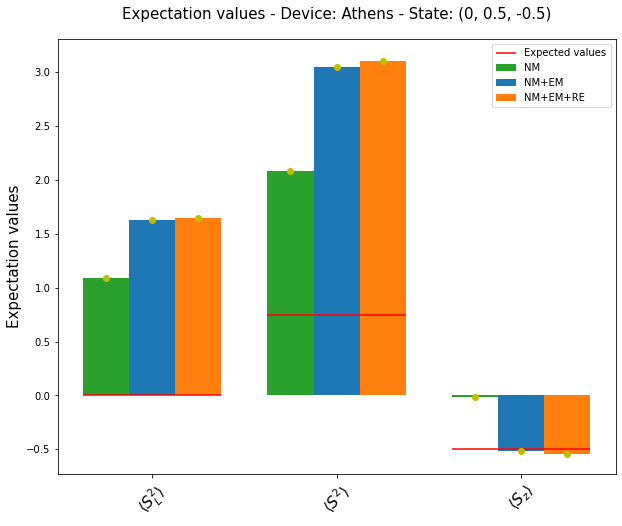

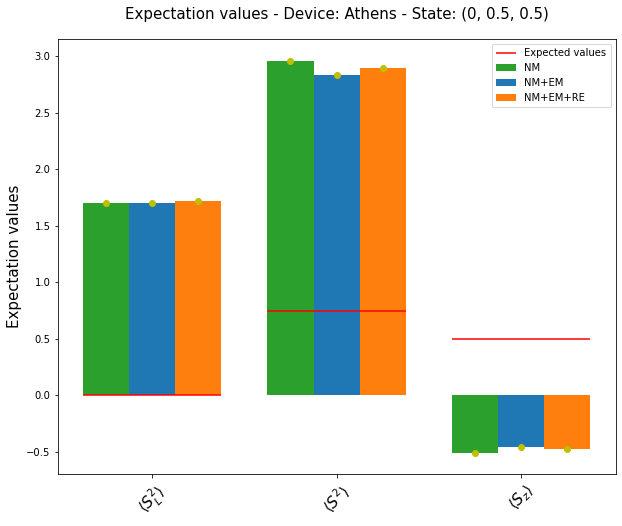

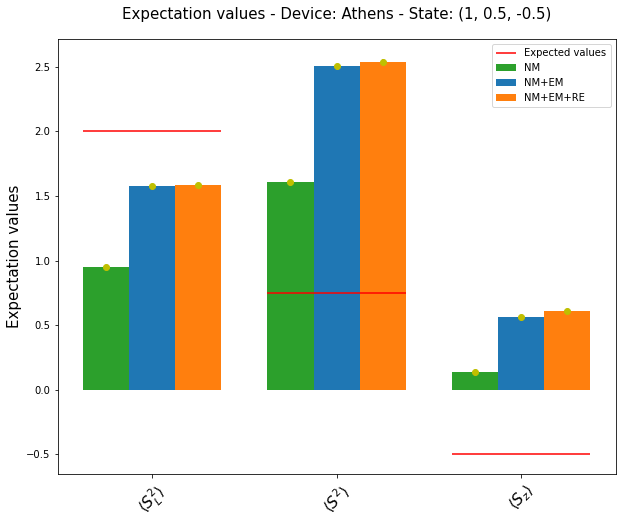

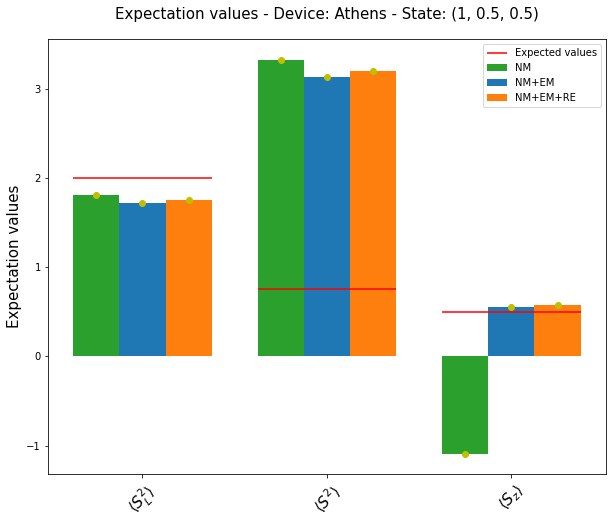

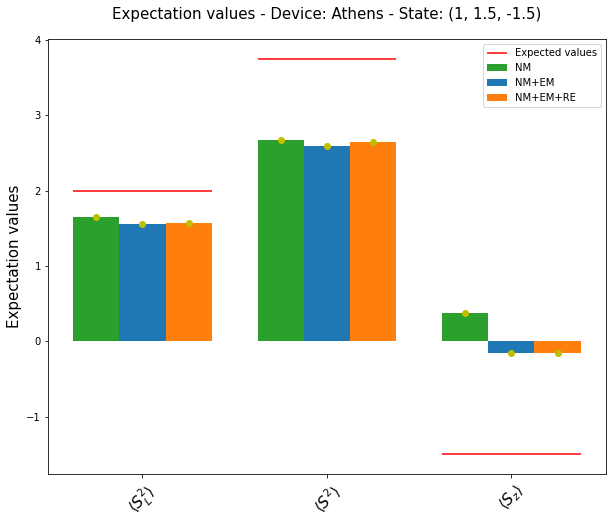

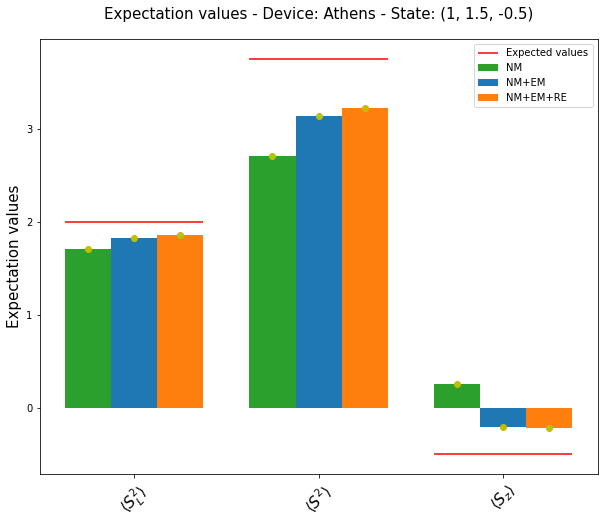

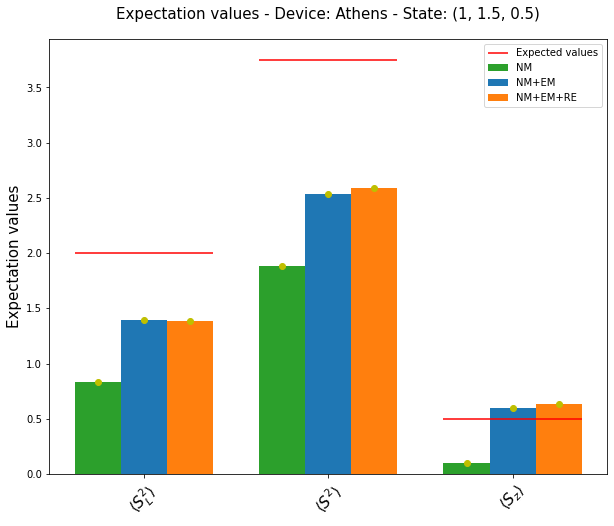

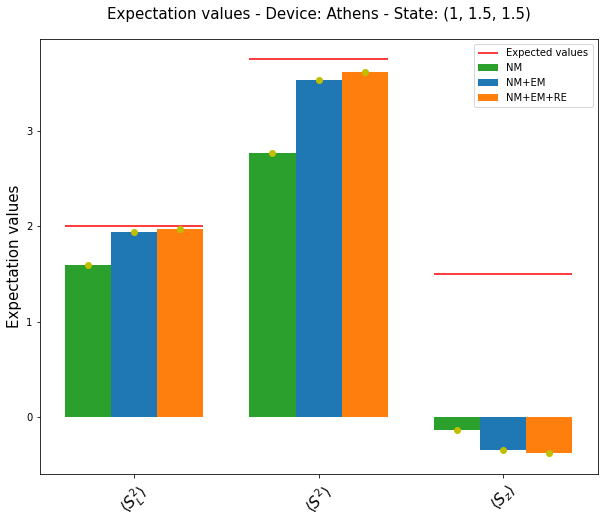

In [15]:
file=open("Results/VQE_spin_qasm.out")
line=file.readlines()

s= 8092     # Number of shots
cl=0        # Count lines
for i in range(len(lab_list)):
    data1,err_data1=[],[]
    data2,err_data2=[],[]
    data3,err_data3=[],[]
    for j in range(9):
        val=line[cl].split()
        if j<3:
            data1.append(float(val[0]))
            err_data1.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=3 and j<6:
            data2.append(float(val[0]))
            err_data2.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=6 and j<9:
            data3.append(float(val[0]))
            err_data3.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        cl+=1
    
    # The histograms - Plot of expectation values
    l=lab_list[i]
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    rects1 = ax.bar(x_lab - width, data1, width, label='NM',color='tab:green')
    ax.errorbar(x_lab - width,data1,yerr=err_data1,fmt='o',color='y')
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")

    rects2 = ax.bar(x_lab, data2, width, label='NM+EM',color='tab:blue')
    ax.errorbar(x_lab,data2,yerr=err_data2,fmt='o',color='y')
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")

    rects3 = ax.bar(x_lab + width, data3, width, label='NM+EM+RE',color='tab:orange')
    ax.errorbar(x_lab + width,data3,yerr=err_data3,fmt='o',color='y')
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=15)
    ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
    ax.set_xticks(x_lab)
    ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
    ax.legend()
    plt.show()

In [16]:
cl2=0
count_lab=0
for i in range(72,len(line)):
    val=line[i].split()
    if len(val)==1:
        if cl2%2==0:
            print("State label: ",lab_list[count_lab])
            count_lab+=1
            print("   Noise model results")
        else:
            print("   Noise model + error mitigation results")
        print("      C(s_L,s_s_z) = ",val[0],"\n")
        cl2+=1

State label:  (0, 0.5, -0.5)
   Noise model results
      C(s_L,s_s_z) =  3.084916456914538 

   Noise model + error mitigation results
      C(s_L,s_s_z) =  7.949612568481133 

State label:  (0, 0.5, 0.5)
   Noise model results
      C(s_L,s_s_z) =  8.661441708782023 

   Noise model + error mitigation results
      C(s_L,s_s_z) =  8.102572523993235 

State label:  (1, 0.5, -0.5)
   Noise model results
      C(s_L,s_s_z) =  2.254548119878931 

   Noise model + error mitigation results
      C(s_L,s_s_z) =  4.210727459970867 

State label:  (1, 0.5, 0.5)
   Noise model results
      C(s_L,s_s_z) =  8.92042385344123 

   Noise model + error mitigation results
      C(s_L,s_s_z) =  5.744691097218172 

State label:  (1, 1.5, -1.5)
   Noise model results
      C(s_L,s_s_z) =  4.63855216419969 

   Noise model + error mitigation results
      C(s_L,s_s_z) =  3.294682243114373 

State label:  (1, 1.5, -0.5)
   Noise model results
      C(s_L,s_s_z) =  1.6804317238802713 

   Noise model + er

**Summary table : cost function values**

| Label $(s_{L},s,s_z)$| NM cost function | NM + EM cost function | 
| :-: | :-: | :-: |
|<img width=100/>|<img width=150/>| <img width=150/>|  
|$(0,1/2,-1/2)$ | $3.08$ | $7.95$ |   
|$(0,1/2,1/2)$ | $8.66$ | $8.10$ |  
|$(1,1/2,-1/2)$ | $2.25$ | $4.21$ |   
|$(1,1/2,1/2)$ | $8.92$ | $5.74$ |  
|$(1,3/2,-3/2)$ | $4.64$ | $3.29$ |   
|$(1,3/2,-1/2)$ | $1.68$ |$0.43$ |  
|$(1,3/2,1/2)$ | $4.96$ | $1.84$|   
|$(1,3/2,3/2)$ | $3.78$ |$3.72$ |  

As we can see, it's really important to give the exact gradient function to the VQE minimization.

### (C) `cost_fn=spin_cost`, `grad_fn=grad_spin_cost` working on `Gradient("lin_comb")`

We use as cost function and gradient function `spin_cost` and `grad_spin_cost`, respectively. `grad_spin_cost` uses `Gradient("lin_comb")` inside.

We know use the **QASM** simulation with noise model using:
- **fixed number of shots** ($8092$) 
- hardware device **IBM Athens**  

#### Expectation values and Richardson extrapolation analysis

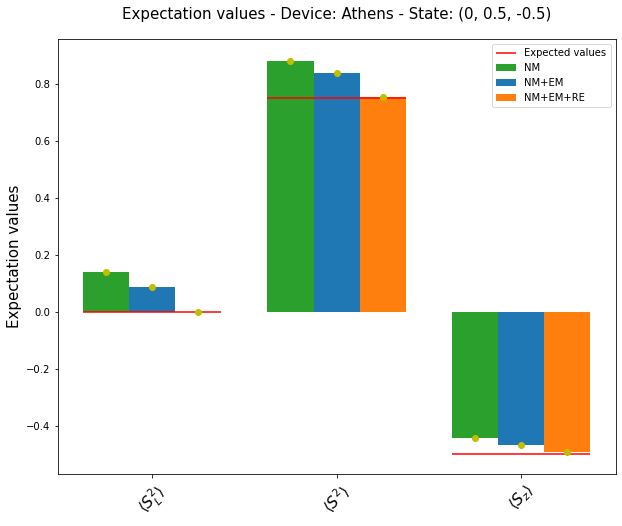

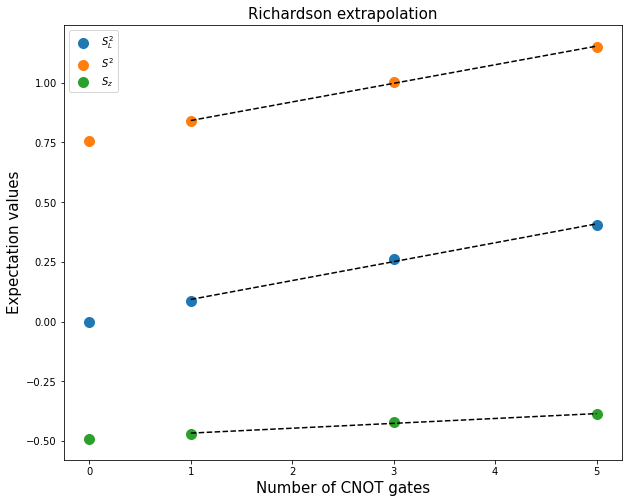

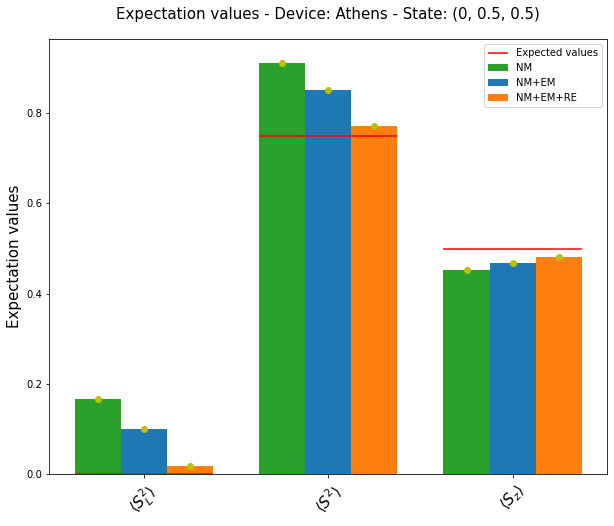

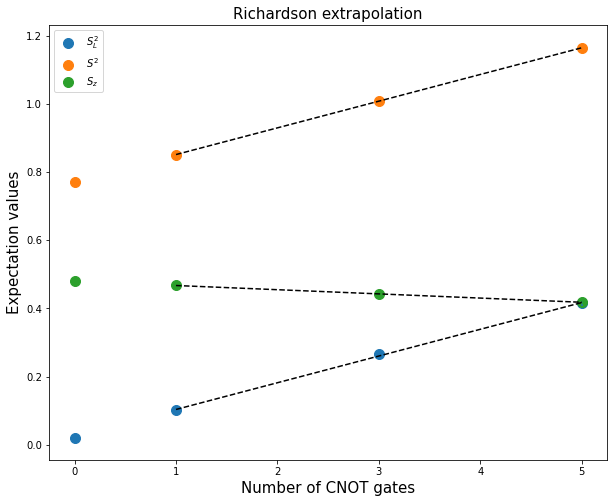

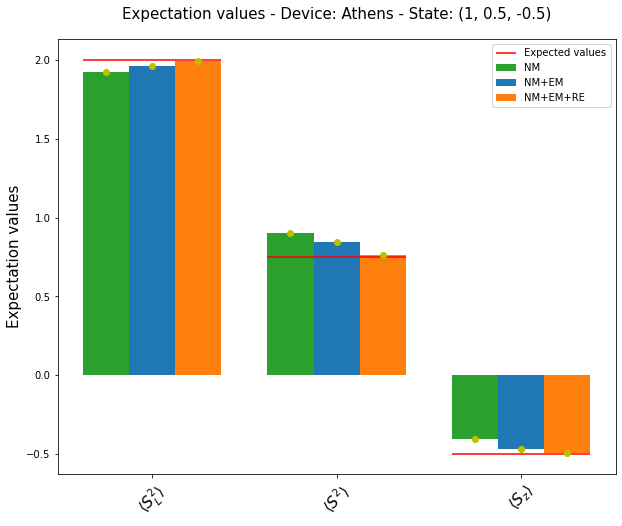

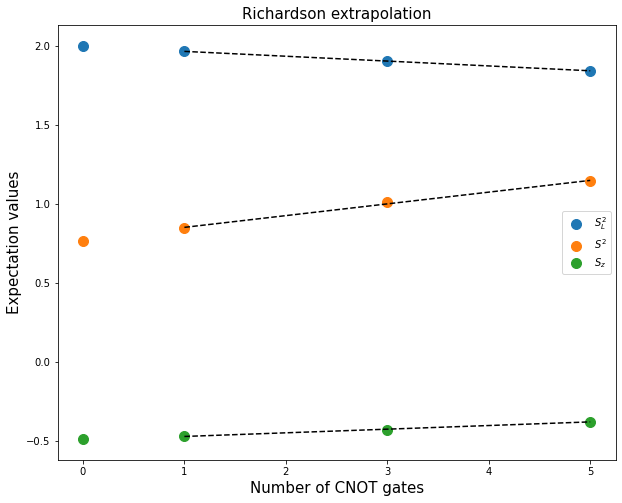

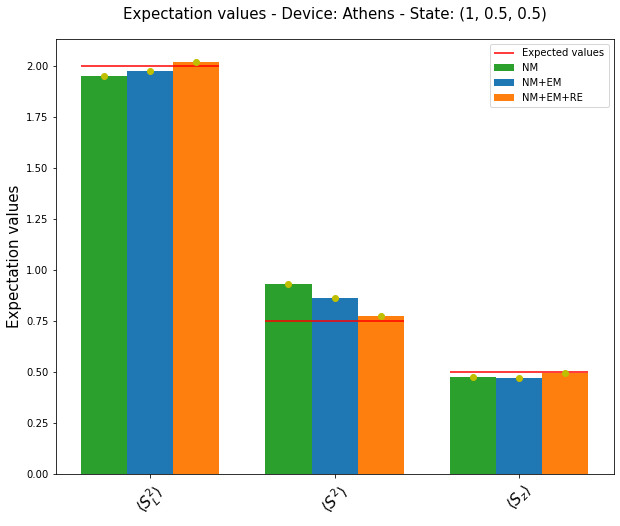

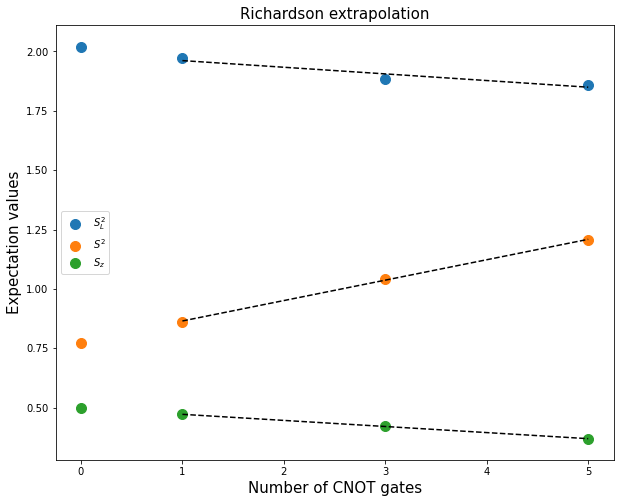

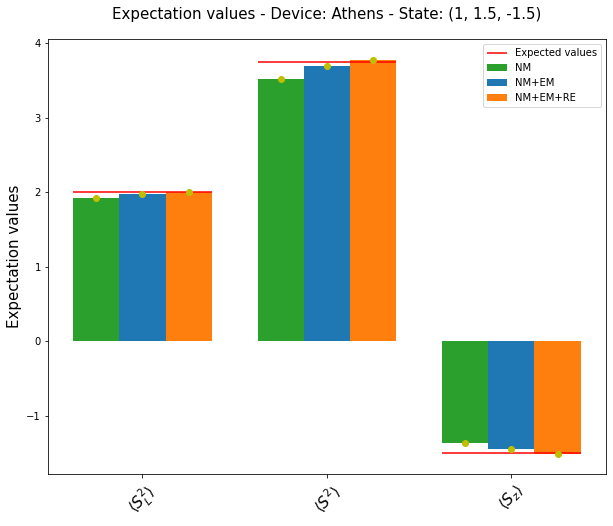

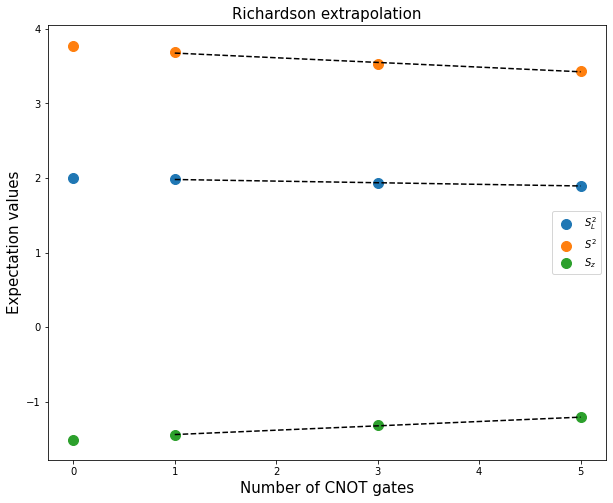

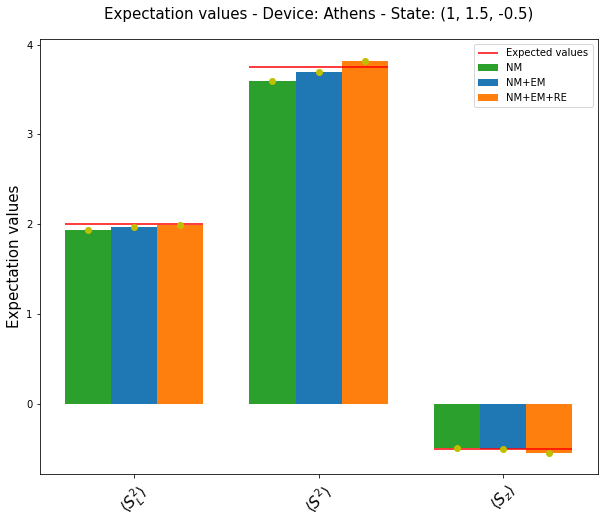

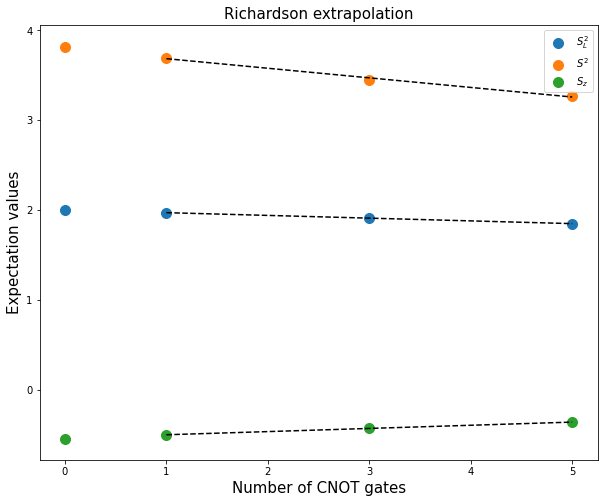

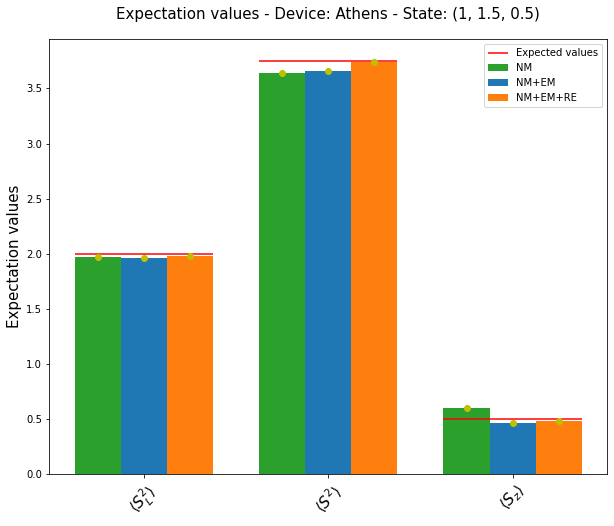

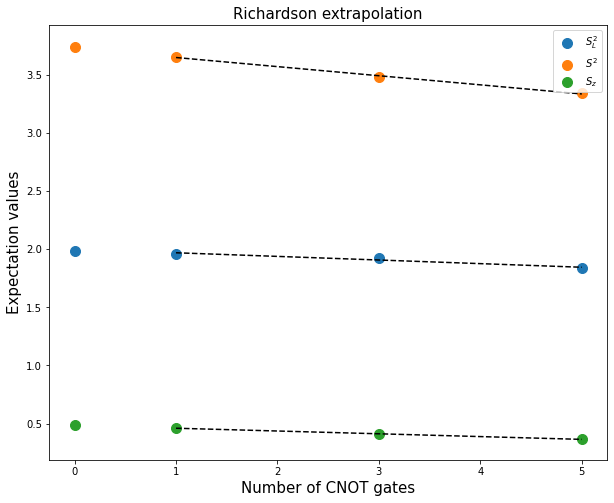

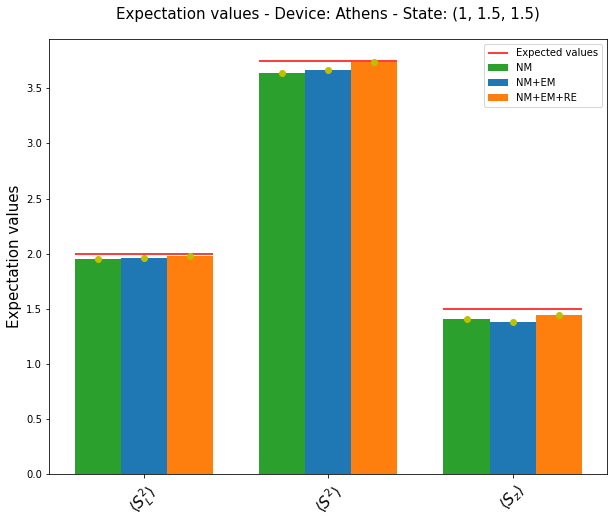

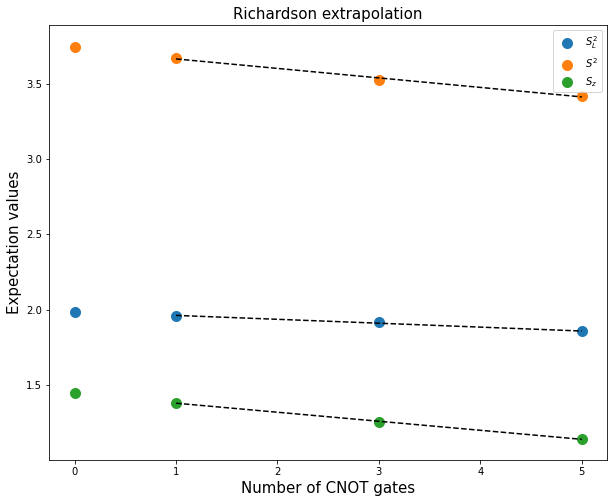

In [27]:
file=open("Results/VQE_spin_qasm_lin_comb.out")      # Before: VQE_spin_qasm_2.out
line=file.readlines()

s= 8092     # Number of shots
cl=0        # Count lines
for i in range(len(lab_list)):
    data_raw,err_raw=[],[]
    data_1,err_1=[],[]
    data_3,err_3=[],[]
    data_5,err_5=[],[]
    data_re,err_re=[],[]
    for j in range(15):
        val=line[cl].split()
        if j<3:
            data_raw.append(float(val[0]))
            err_raw.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=3 and j<6:
            data_1.append(float(val[0]))
            err_1.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=6 and j<9:
            data_3.append(float(val[0]))
            err_3.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=9 and j<12:
            data_5.append(float(val[0]))
            err_5.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=12 and j<15:
            data_re.append(float(val[0]))
            err_re.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        cl+=1
    
    # The histograms - Plot of expectation values
    l=lab_list[i]
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
    ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')
    
    rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
    ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')
    
    rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
    ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')
    
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=15)
    ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
    ax.set_xticks(x_lab)
    ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
    ax.legend()
    plt.show()
    
    
    # Richardson extrapolation analysis
    plt.figure(figsize=(10,8))
    op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]
    x_re=[]
    y_re=[]
    for j in range(3):
        plt.errorbar([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],yerr=[err_re[j],err_1[j],err_3[j],err_5[j]],ls="none")
        
        coeff = np.polyfit([1,3,5],[data_1[j],data_3[j],data_5[j]],1)
        poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
        plt.scatter([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],s=100,label=op_labels[j])
        plt.plot([1,3,5], poly1d_fn([1,3,5]), '--k')
    plt.title("Richardson extrapolation",size=15)
    plt.xlabel("Number of CNOT gates",size=15)
    plt.xticks(np.arange(6))
    plt.ylabel("Expectation values",size=15)
    plt.legend()
    

#### Fidelities (no statistical information)

In [33]:
cl=120

psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

for i in range(len(lab_list)):
    print("State label: ",lab_list[i])
    for j in range(2):
        param=[]
        if j==0:
            print("       Noise model results")
        if j==1:
            print("       Noise model + error mitigation results")
        for k in range(13):
            val=line[cl].split()
            if k==0:
                print("          C(s_L,s_s_z) = ",val[0])
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ=var_form.assign_parameters(param)          # With RealAmplitudes/TwoLocal
        #best_circ=var_form.construct_circuit(param)         # With VariationalForm
        best_psi=CircuitStateFn(best_circ).to_matrix()
        # The best state
        print("          | optimal > = ",to_ket(best_psi))
        int_prod=np.dot(np.conjugate(eig_3spins[i]),to_state(np.real(best_psi)))
        fid=np.conjugate(int_prod)*int_prod
        print("          |< ideal | optimal >|^2 = ",fid,"\n")

State label:  (0, 0.5, -0.5)
       Noise model results
          C(s_L,s_s_z) =  0.03993082578034288
          | optimal > =  (0.001+0.000j) |000⟩ + (0.050+0.000j) |100⟩ + (-0.067+0.000j) |010⟩ + (-0.013+0.000j) |110⟩ + (0.001+0.000j) |001⟩ + (0.710+0.000j) |101⟩ + (-0.699+0.000j) |011⟩
          |< ideal | optimal >|^2 =  0.9928666692440338 

       Noise model + error mitigation results
          C(s_L,s_s_z) =  0.014752859686288394
          | optimal > =  (0.010+0.000j) |000⟩ + (0.007+0.000j) |100⟩ + (-0.015+0.000j) |010⟩ + (0.005+0.000j) |110⟩ + (-0.007+0.000j) |001⟩ + (-0.703+0.000j) |101⟩ + (0.710+0.000j) |011⟩ + (0.014+0.000j) |111⟩
          |< ideal | optimal >|^2 =  0.9992996953115738 

State label:  (0, 0.5, 0.5)
       Noise model results
          C(s_L,s_s_z) =  0.05715025171477105
          | optimal > =  (-0.010+0.000j) |000⟩ + (0.712+0.000j) |100⟩ + (-0.678+0.000j) |010⟩ + (-0.008+0.000j) |110⟩ + (-0.049+0.000j) |001⟩ + (-0.120+0.000j) |101⟩ + (0.129+0.000j) |011⟩ + 

### (D) `cost_fn=spin_cost`, `grad_fn=grad_spin_cost` working on `Gradient("param_shift")`

We use as cost function and gradient function `spin_cost` and `grad_spin_cost`, respectively. `grad_spin_cost` uses `Gradient("param_shift")` inside.

We know use the **QASM** simulation with noise model using:
- **fixed number of shots** ($8092$) 
- hardware device **IBM Athens**  

#### Expectation values and Richardson extrapolation analysis

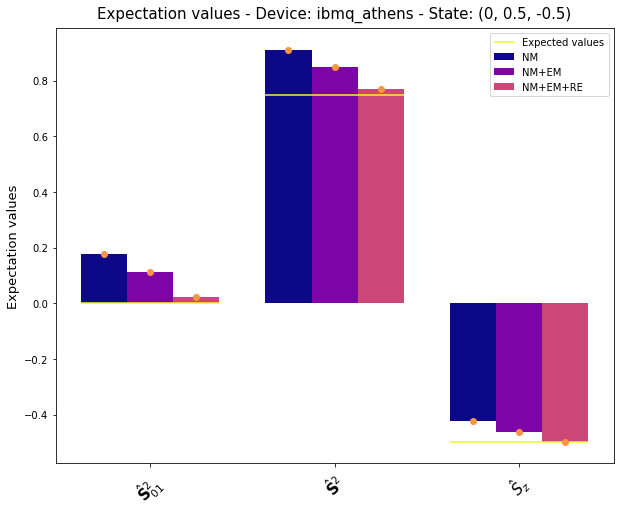

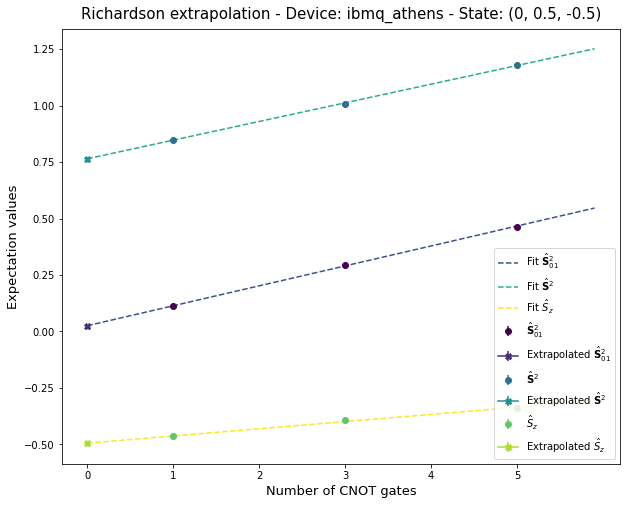

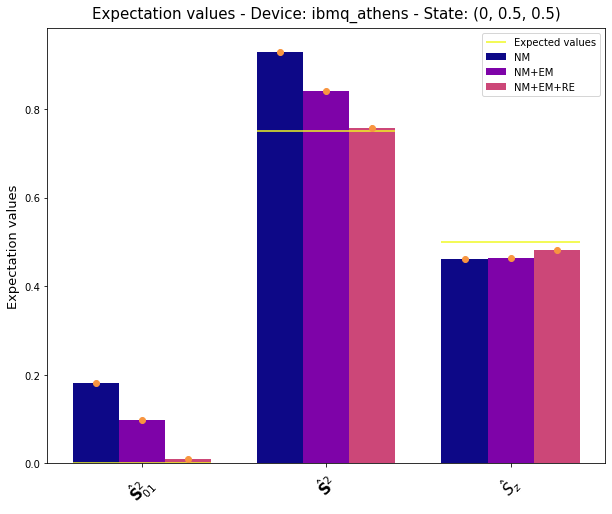

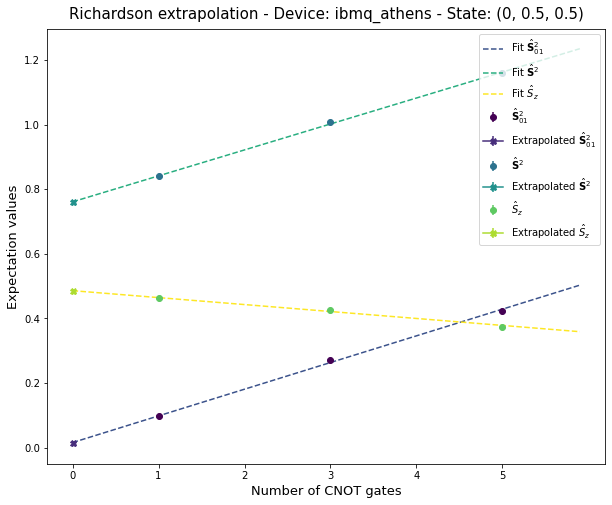

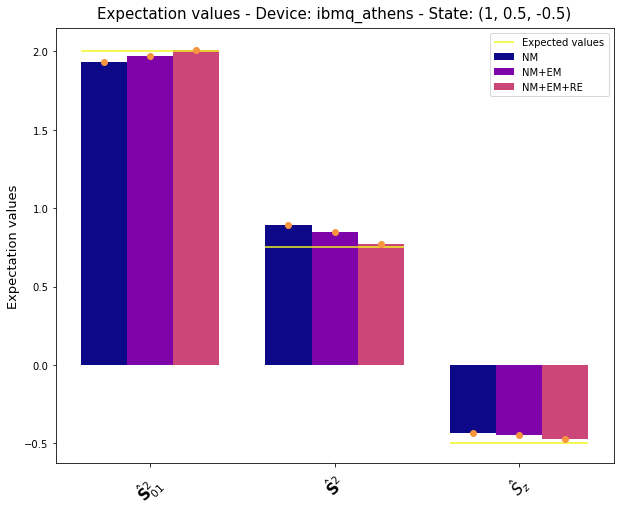

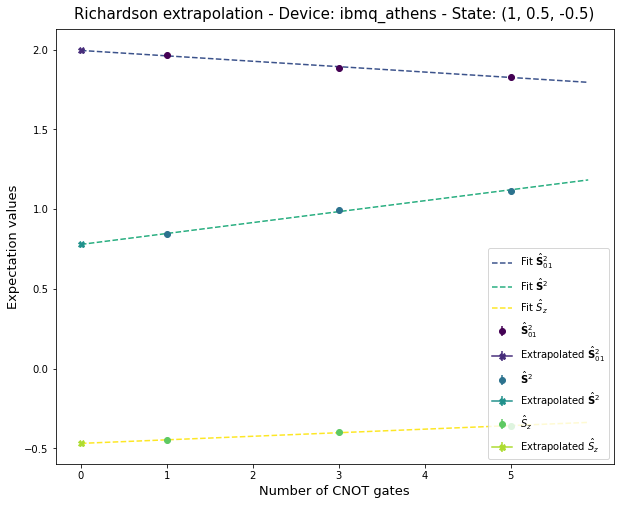

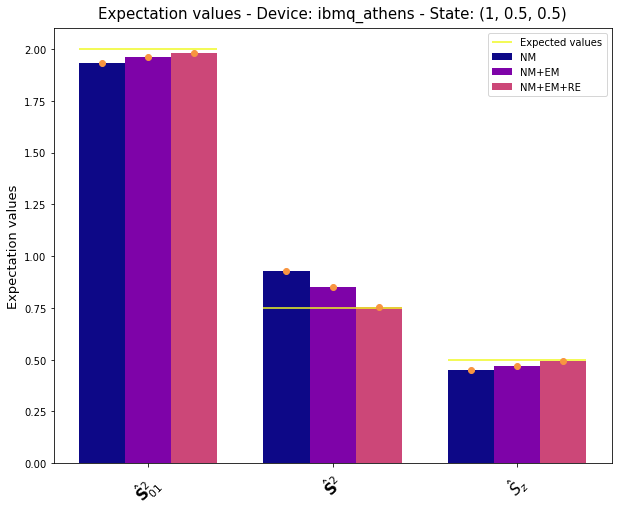

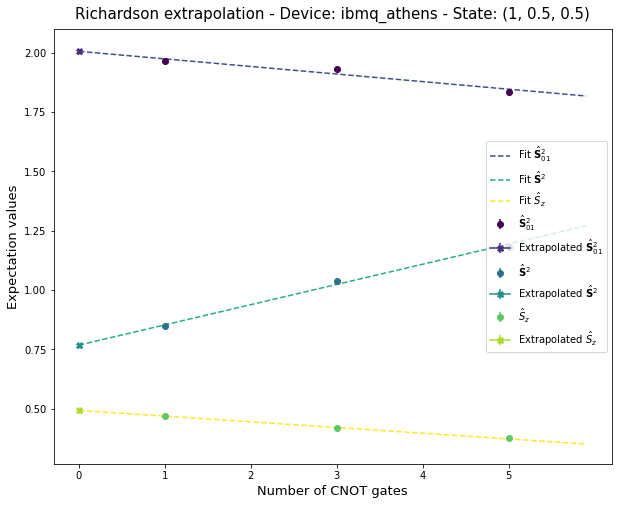

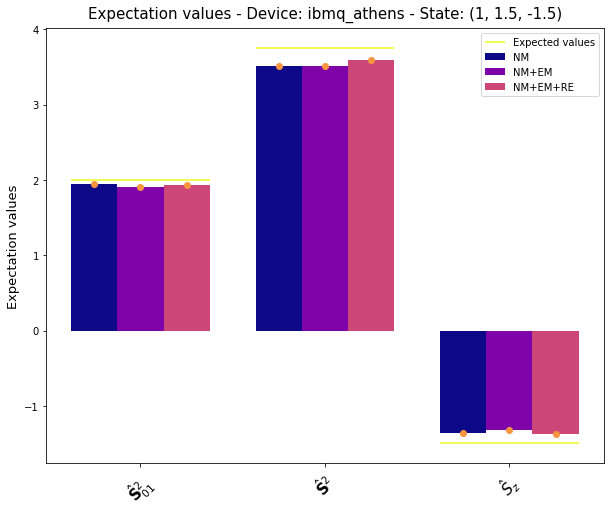

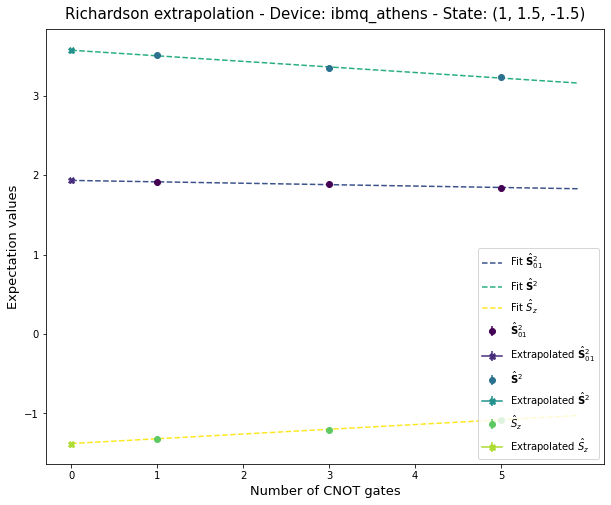

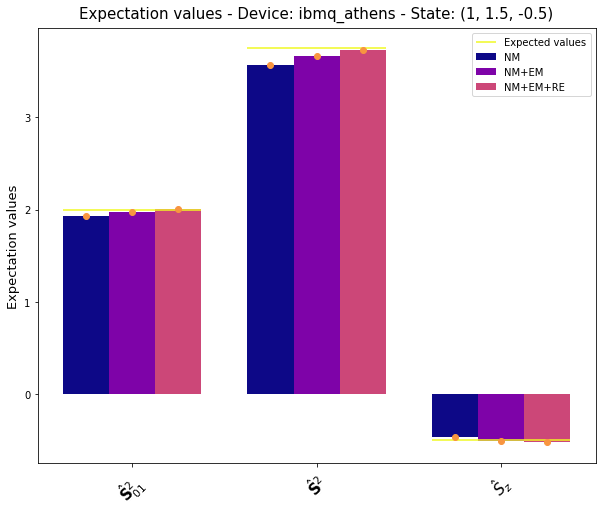

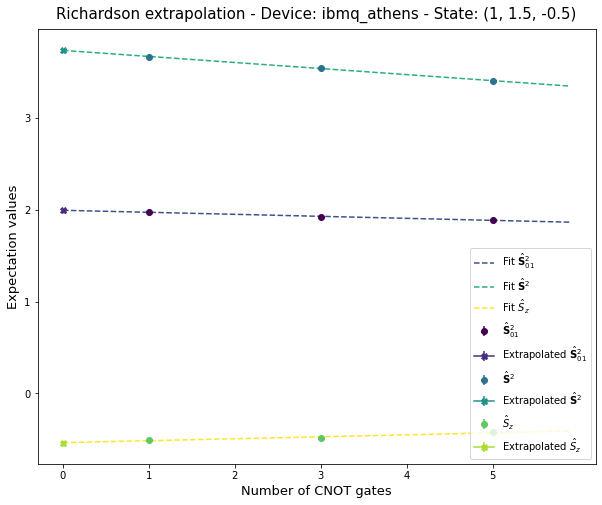

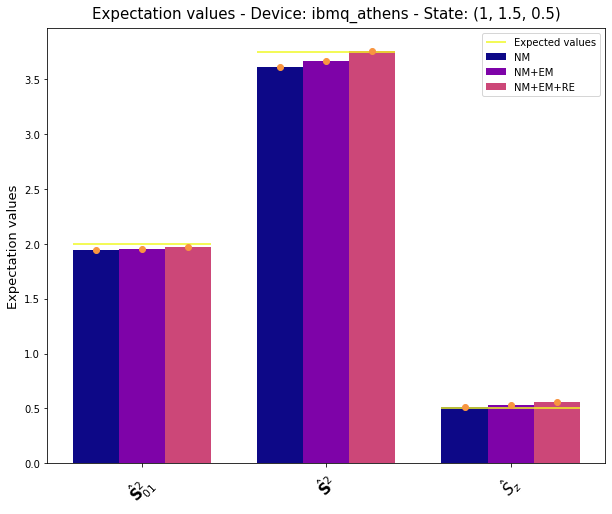

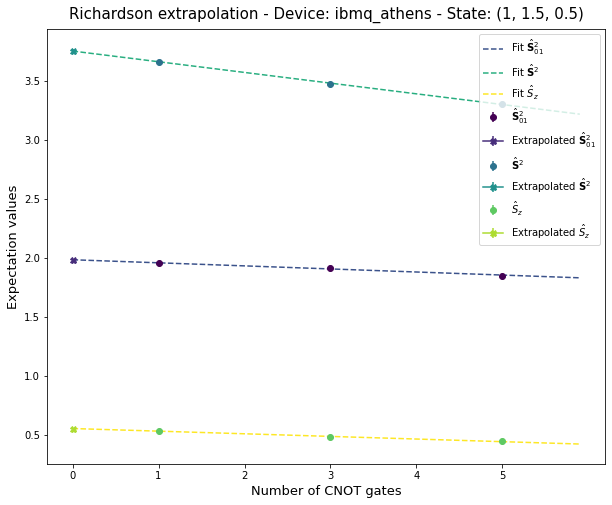

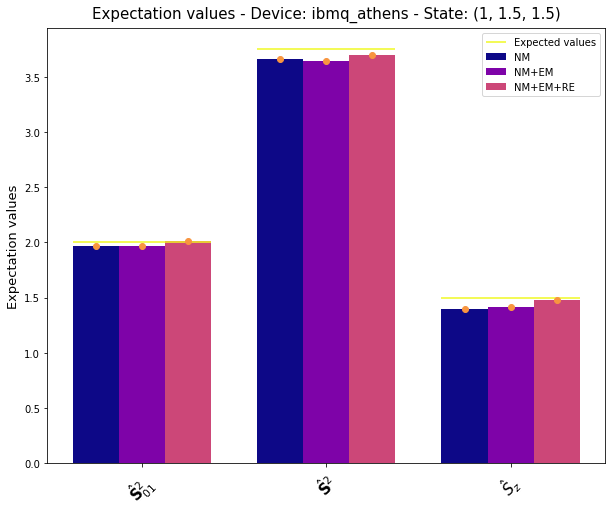

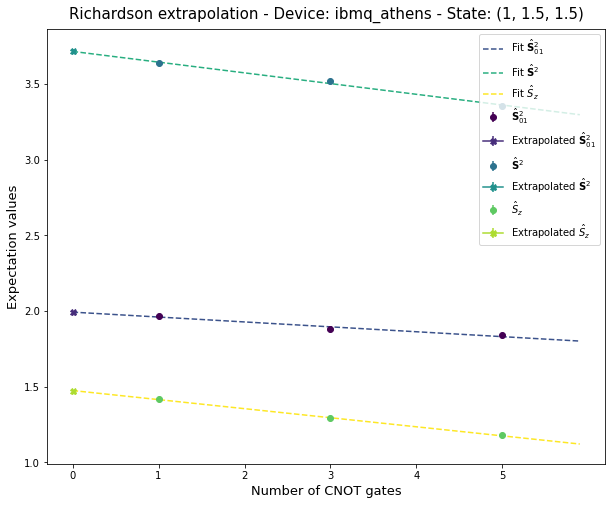

In [16]:
def straight_line(x,m,q):
    return m*x+q

file=open("Results/VQE_spin_qasm_param_shift.out")      # Before: VQE_spin_qasm_2.out
line=file.readlines()

s= 8092     # Number of shots
cl=0        # Count lines
for i in range(len(lab_list)):
    data_raw,err_raw=[],[]
    data_1,err_1=[],[]
    data_3,err_3=[],[]
    data_5,err_5=[],[]
    data_re,err_re=[],[]
    for j in range(15):
        val=line[cl].split()
        if j<3:
            data_raw.append(float(val[0]))
            err_raw.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=3 and j<6:
            data_1.append(float(val[0]))
            err_1.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=6 and j<9:
            data_3.append(float(val[0]))
            err_3.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=9 and j<12:
            data_5.append(float(val[0]))
            err_5.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=12 and j<15:
            data_re.append(float(val[0]))
            err_re.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        cl+=1
    
    op_labels=[r"$\hat{\mathbf{S}}_{01}^2$",r"$\hat{\mathbf{S}}^2$",r"$\hat{S}_z$"]
    # The histograms - Plot of expectation values
    jet = plt.get_cmap('plasma')
    colors = iter(jet(np.linspace(0,1,5)))
    
    l = lab_list[i]
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color=next(colors))
    rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color=next(colors))
    rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color=next(colors))
    
    c = next(colors)
    ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color=c)
    ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color=c)
    ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color=c)
    
    c = next(colors)
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors=c)
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors=c)
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors=c,label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=13)
    ax.set_title(r'Expectation values - Device: ibmq_athens - State: '+str(l),fontsize=15,pad=10)
    ax.set_xticks(x_lab)
    ax.set_xticklabels(op_labels,rotation=45,size=15)
    ax.legend()
    if i==0 or i==2:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/RY_qasm_3_"+str(i)+".pdf")
    
    
    # Richardson extrapolation analysis
    jet = plt.get_cmap('viridis')
    colors = iter(jet(np.linspace(0,1,9)))
    
    plt.figure(figsize=(10,8))
    for j in range(3):
        # Data
        plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],marker='o',ls="none",label=op_labels[j],color=next(colors))
        # Extrapolated data
        p_ave,p_cov = curve_fit(straight_line,[1,3,5],[data_1[j],data_3[j],data_5[j]],sigma=[err_1[j],err_3[j],err_5[j]],absolute_sigma=True)                                                                                    
        plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j],color=next(colors))
        # Fit
        u = list(np.arange(0,6,0.1))
        v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
        plt.plot(u,v,'--',label='Fit '+op_labels[j], color=next(colors))                                                                                    
    
    plt.title("Richardson extrapolation - Device: ibmq_athens - State: "+str(l),size=15,pad=10)
    plt.xlabel("Number of CNOT gates",size=13)
    plt.xticks(np.arange(6))
    plt.ylabel("Expectation values",size=13)
    plt.legend()
    if i==0 or i==2:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/RY_qasm_3_RE_"+str(i)+".pdf")
    

#### Fidelities (no statistical information)

In [36]:
cl=120

psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

for i in range(len(lab_list)):
    print("State label: ",lab_list[i])
    for j in range(2):
        param=[]
        if j==0:
            print("       Noise model results")
        if j==1:
            print("       Noise model + error mitigation results")
        for k in range(13):
            val=line[cl].split()
            if k==0:
                print("          C(s_L,s_s_z) = ",val[0])
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ=var_form.assign_parameters(param)          # With RealAmplitudes/TwoLocal
        #best_circ=var_form.construct_circuit(param)         # With VariationalForm
        best_psi=CircuitStateFn(best_circ).to_matrix()
        # The best state
        print("          | optimal > = ",to_ket(best_psi))
        int_prod=np.dot(np.conjugate(eig_3spins[i]),to_state(np.real(best_psi)))
        fid=np.conjugate(int_prod)*int_prod
        print("          |< ideal | optimal >|^2 = ",fid,"\n")

State label:  (0, 0.5, -0.5)
       Noise model results
          C(s_L,s_s_z) =  0.0552303661134714
          | optimal > =  (0.002+0.000j) |000⟩ + (-0.037+0.000j) |100⟩ + (0.061+0.000j) |010⟩ + (-0.004+0.000j) |110⟩ + (-0.005+0.000j) |001⟩ + (0.704+0.000j) |101⟩ + (-0.707+0.000j) |011⟩ + (-0.001+0.000j) |111⟩
          |< ideal | optimal >|^2 =  0.9948339227041265 

       Noise model + error mitigation results
          C(s_L,s_s_z) =  0.02191493354276245
          | optimal > =  (0.006+0.000j) |000⟩ + (-0.062+0.000j) |100⟩ + (0.054+0.000j) |010⟩ + (-0.035+0.000j) |110⟩ + (0.001+0.000j) |001⟩ + (-0.687+0.000j) |101⟩ + (0.721+0.000j) |011⟩ + (-0.004+0.000j) |111⟩
          |< ideal | optimal >|^2 =  0.991306690656194 

State label:  (0, 0.5, 0.5)
       Noise model results
          C(s_L,s_s_z) =  0.05893724271715601
          | optimal > =  (0.012+0.000j) |000⟩ + (-0.671+0.000j) |100⟩ + (0.728+0.000j) |010⟩ + (-0.039+0.000j) |110⟩ + (-0.087+0.000j) |001⟩ + (0.089+0.000j) |101⟩ + (-

### Definition of new cost function and gradient 

Cost function depending from spin operators eigenvalues, $\{s_L,s,s_z\}$, and variance values, $\{\sigma^2(\hat{S}_L^2),\sigma^2(\hat{S}^2),\sigma^2(\hat{S}_z)\}$. 

$$C(s_L,s,s_z,\sigma^2(\hat{S}_L^2),\sigma^2(\hat{S}^2),\sigma^2(\hat{S}_z)) = \biggl( \langle \hat{S}_L^2 \rangle - s_L(s_L+1) \biggl)^2 + \biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl)^2 + \biggl( \langle \hat{S}_z \rangle - s_z \biggl)^2 + \biggl( \langle \hat{S}_L^4 \rangle - \langle \hat{S}_L^2 \rangle^2 - \sigma^2(\hat{S}_L^2)\biggl)^2 + \biggl( \langle \hat{S}^4 \rangle - \langle \hat{S}^2 \rangle^2 - \sigma^2(\hat{S}^2)\biggl)^2 + \biggl( \langle \hat{S}_z^2 \rangle - \langle \hat{S}_z \rangle^2 - \sigma^2(\hat{S}_z)\biggl)^2$$

And the $i$-th component of the gradient $\nabla C(s_L,s,s_z,\sigma^2(\hat{S}_L^2),\sigma^2(\hat{S}^2),\sigma^2(\hat{S}_z))$ is:

$$\frac{\partial{C(s_L,s,s_z)}}{\partial{\theta_i}} = 2 \biggl( \langle \hat{S}_L^2 \rangle - s_L(s_L+1) \biggl) \frac{\partial{\langle \hat{S}_L^2 \rangle}}{\partial{\theta_i}} + 2 \biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl) \frac{\partial{\langle \hat{S}^2 \rangle}}{\partial{\theta_i}} + 2 \biggl( \langle \hat{S}_z \rangle - s_z \biggl) \frac{\partial{\langle \hat{S}_z \rangle}}{\partial{\theta_i}} + 2 \biggl( \langle \hat{S}_L^4 \rangle - \langle \hat{S}_L^2 \rangle^2 - \sigma^2(\hat{S}_L^2)\biggl) \biggl( \frac{\partial \langle \hat{S}_L^4 \rangle}{\partial \theta_i} + 2 \langle \hat{S}_L^2 \rangle \frac{\partial \langle \hat{S}_L^2 \rangle}{\partial \theta_i}\biggr) + 2 \biggl( \langle \hat{S}^4 \rangle - \langle \hat{S}^2 \rangle^2 - \sigma^2(\hat{S}^2)\biggl) \biggl( \frac{\partial \langle \hat{S}^4 \rangle}{\partial \theta_i} + 2 \langle \hat{S}^2 \rangle \frac{\partial \langle \hat{S}^2 \rangle}{\partial \theta_i}\biggr) + 2 \biggl( \langle \hat{S}_z^2 \rangle - \langle \hat{S}_z \rangle^2 - \sigma^2(\hat{S}_z)\biggl) \biggl( \frac{\partial \langle \hat{S}_z^2 \rangle}{\partial \theta_i} + 2 \langle \hat{S}_z \rangle \frac{\partial \langle \hat{S}_z \rangle}{\partial \theta_i}\biggr)$$

We will call those two functions: `spin_cost2` and `grad_spin_cost2`.

In [34]:
def spin_cost2(x):
    # QASM - Expectation values
    circ=var_form.assign_parameters(x)
    
    # Definition of list of operators
    op_list = [op_sl2,op_s2,op_sz]
    op2_list = []
    for op in op_list:
        op2_list.append((op@op).to_pauli_op())
    
    # Expectation values
    f    = []
    cost = 0
    for i in range(3):
        braket     = StateFn(op_list[i],is_measurement=True)@CircuitStateFn(primitive=circ)
        grouped    = PauliExpectation().convert(braket)                            # Convert to expectation value
        sampled_op = CircuitSampler(instance).convert(grouped)                     # Get state sampler (you can also pass the backend directly)
        f.append(sampled_op.eval().real)                                           # Get expectation value
        cost      += (f[i]-l[i]*(l[i]+1))**2
    for i in range(3):
        braket     = StateFn(op2_list[i],is_measurement=True)@CircuitStateFn(primitive=circ)
        grouped    = PauliExpectation().convert(braket)                            # Convert to expectation value
        sampled_op = CircuitSampler(instance).convert(grouped)                     # Get state sampler (you can also pass the backend directly)
        f.append(sampled_op.eval().real)                                           # Get expectation value
        cost      += (f[3+i]-f[i]**2-lv[i])**2
    return cost


def grad_spin_cost2(x):
    # Definition of list of operators
    op_list = [op_sl2,op_s2,op_sz]
    op2_list = []
    for op in op_list:
        op2_list.append((op@op).to_pauli_op())
    
    # Here we create the dictionary which associates at each Parameter the corresponding value
    pv  = var_form.ordered_parameters
    par = {pv[i] : x[i] for i in range(len(pv))}
    
    # QASM
    # Expectation values
    circ = var_form.assign_parameters(x)

    # Expectation values
    f = []
    for i in range(3):
        braket     = StateFn(op_list[i],is_measurement=True)@CircuitStateFn(primitive=circ)
        grouped    = PauliExpectation().convert(braket)                            # Convert to expectation value
        sampled_op = CircuitSampler(instance).convert(grouped)                     # Get state sampler (you can also pass the backend directly)
        f.append(sampled_op.eval().real)                                           # Get expectation value
    for i in range(3):
        braket     = StateFn(op2_list[i],is_measurement=True)@CircuitStateFn(primitive=circ)
        grouped    = PauliExpectation().convert(braket)                            # Convert to expectation value
        sampled_op = CircuitSampler(instance).convert(grouped)                     # Get state sampler (you can also pass the backend directly)
        f.append(sampled_op.eval().real)                                           # Get expectation value sampled_op.eval().real                                        # Get expectation value
    
    # Gradients
    g = []
    for i in range(3):
        state_grad = grad.convert(operator=~StateFn(op_list[i]) @ CircuitStateFn(primitive=var_form),params=pv)
        g.append([np.real(el) for el in state_grad.assign_parameters(par).eval()])
    for i in range(3):
        state_grad = grad.convert(operator=~StateFn(op2_list[i]) @ CircuitStateFn(primitive=var_form),params=pv)
        g.append([np.real(el) for el in state_grad.assign_parameters(par).eval()])
    
    grad_vec=[]
    for i in range(len(g[0])):
        grad_comp = 0
        for j in range(3):
            grad_comp += 2*(f[j]-l[j]*(l[j]+1))*g[j][i] + 2*(f[3+j]-f[j]**2-lv[j])*(g[3+j][i] + 2*f[j]*g[j][i])
        grad_vec.append(grad_comp)

    return grad_vec

In [32]:
'''
    ALternative for definition of spin_cost
    op_sl4 = (op_sl2@op_sl2).to_pauli_op()
    op_s4  = (op_s2@op_s2).to_pauli_op()
    op_sz2 = (op_sz@op_sz).to_pauli_op()
    
    braket1    = StateFn(op_sl2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped    = PauliExpectation().convert(braket1)                           # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)                     # Get state sampler (you can also pass the backend directly)
    f1         = sampled_op.eval().real                                        # Get expectation value

    braket2    = StateFn(op_s2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped    = PauliExpectation().convert(braket2)                           # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)                     # Get state sampler (you can also pass the backend directly)
    f2         = sampled_op.eval().real                                        # Get expectation value

    braket3    = StateFn(op_sz,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped    = PauliExpectation().convert(braket3)                           # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)                     # Get state sampler (you can also pass the backend directly)
    f3         = sampled_op.eval().real                                        # Get expectation value
    
    braket4    = StateFn(op_sl4,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped    = PauliExpectation().convert(braket4)                           # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)                     # Get state sampler (you can also pass the backend directly)
    f4         = sampled_op.eval().real                                        # Get expectation value
    
    braket5    = StateFn(op_s4,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped    = PauliExpectation().convert(braket5)                           # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)                     # Get state sampler (you can also pass the backend directly)
    f5         = sampled_op.eval().real                                        # Get expectation value
    
    braket6    = StateFn(op_sz2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped    = PauliExpectation().convert(braket6)                           # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)                     # Get state sampler (you can also pass the backend directly)
    f6         = sampled_op.eval().real                                        # Get expectation value
    '''
print(" ")

### Analysis of the ideal variance on spin operators

Given an operator $\hat{O}$ in $\{\hat{S}_L^2,\hat{S}^2,\hat{S}_z\}$, we compute the corresponding variance on a given state $|\psi \rangle$ as:

$$\sigma^2(\hat{O},\psi) = \langle \psi |\hat{O}^2 | \psi \rangle - \langle \psi |\hat{O} | \psi \rangle^2 $$

First we define the matrices associate with $\hat{O}^2$, namely: $\{\hat{S}_L^4,\hat{S}^4,\hat{S}_z^2\}$.

In [33]:
mat_op = []
mat_op.append(op_sl2.to_matrix())
mat_op.append(op_s2.to_matrix())
mat_op.append(op_sz.to_matrix())

mat_op2 = []
mat_op2.append(np.dot(mat_sl2,mat_sl2))
mat_op2.append(np.dot(mat_s2,mat_s2))
mat_op2.append(np.dot(mat_sz,mat_sz))

op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]
var_list = [[] for i in range(len(lab_list))]
for il,l in enumerate(lab_list):
    print("State: ",l)
    for j in range(3):
        var_list[il].append(np.dot(np.conj(eig_3spins[il]),np.dot(mat_op2[j],eig_3spins[il])) - np.dot(np.conj(eig_3spins[il]),np.dot(mat_op[j],eig_3spins[il]))**2)
        print("    ",op_labels[j]," - Variance: ",np.real(np.round(var_list[il][j],3)))
        

State:  (0, 0.5, -0.5)
     $S_L^2$  - Variance:  0.75
     $S^2$  - Variance:  -0.0
     $S_z$  - Variance:  -0.0
State:  (0, 0.5, 0.5)
     $S_L^2$  - Variance:  0.75
     $S^2$  - Variance:  -0.0
     $S_z$  - Variance:  -0.0
State:  (1, 0.5, -0.5)
     $S_L^2$  - Variance:  0.75
     $S^2$  - Variance:  -0.0
     $S_z$  - Variance:  0.0
State:  (1, 0.5, 0.5)
     $S_L^2$  - Variance:  0.75
     $S^2$  - Variance:  -0.0
     $S_z$  - Variance:  0.0
State:  (1, 1.5, -1.5)
     $S_L^2$  - Variance:  0.0
     $S^2$  - Variance:  0.0
     $S_z$  - Variance:  0.0
State:  (1, 1.5, -0.5)
     $S_L^2$  - Variance:  0.0
     $S^2$  - Variance:  0.0
     $S_z$  - Variance:  -0.0
State:  (1, 1.5, 0.5)
     $S_L^2$  - Variance:  0.0
     $S^2$  - Variance:  0.0
     $S_z$  - Variance:  -0.0
State:  (1, 1.5, 1.5)
     $S_L^2$  - Variance:  0.0
     $S^2$  - Variance:  0.0
     $S_z$  - Variance:  0.0


### (E) `cost_fn=spin_cost2`, `grad_fn=grad_spin_cost2` working on `Gradient("param_shift")`

We use as cost function and gradient function `spin_cost2` and `grad_spin_cost2`, respectively. `grad_spin_cost2` uses `Gradient("param_shift")` inside, but with respect to `grad_spin_cost` it keeps in consideration the **variance of the spin operators**.

Now we use the **QASM** simulation with noise model using:
- **fixed number of shots** ($8192$) 
- hardware device **IBM Athens**  

#### Expectation values and Richardson extrapolation analysis

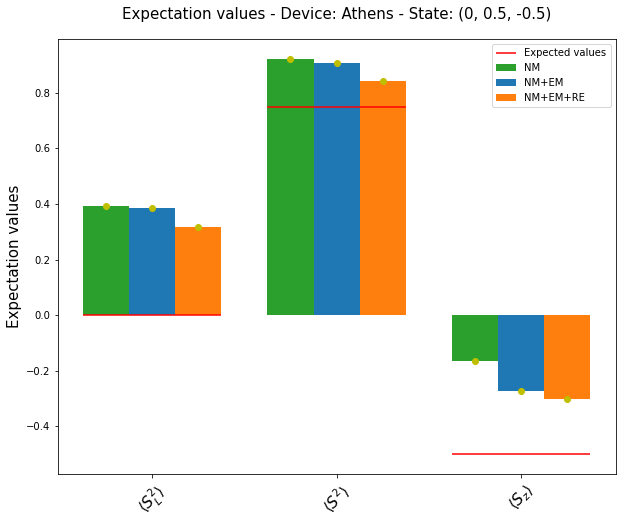

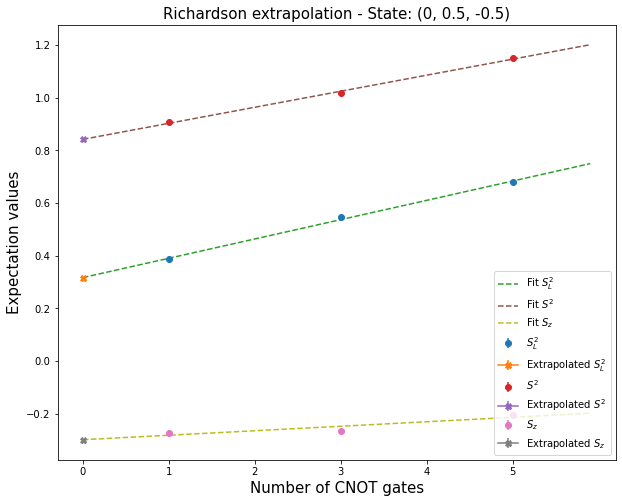

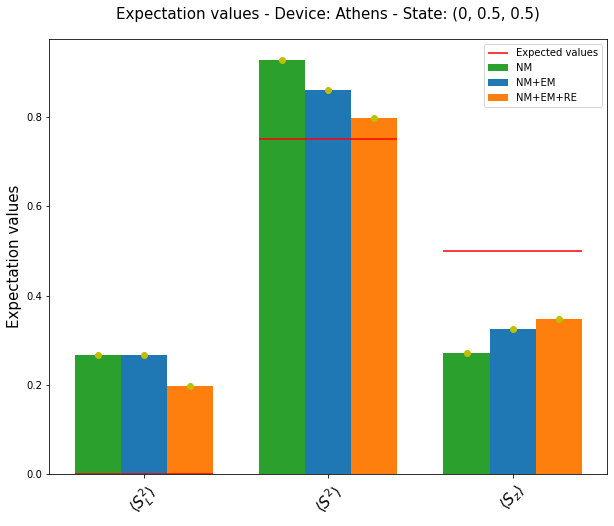

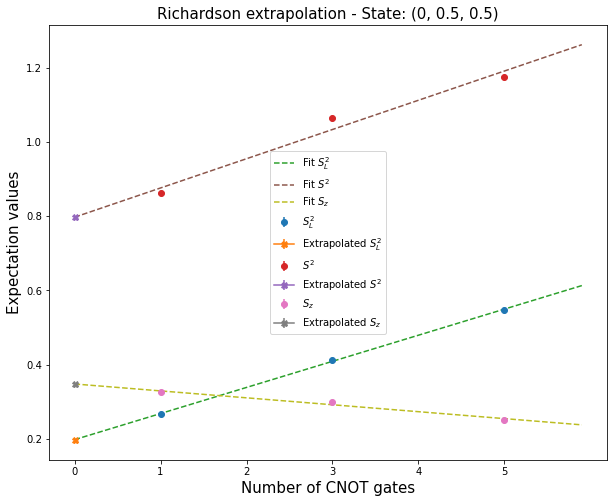

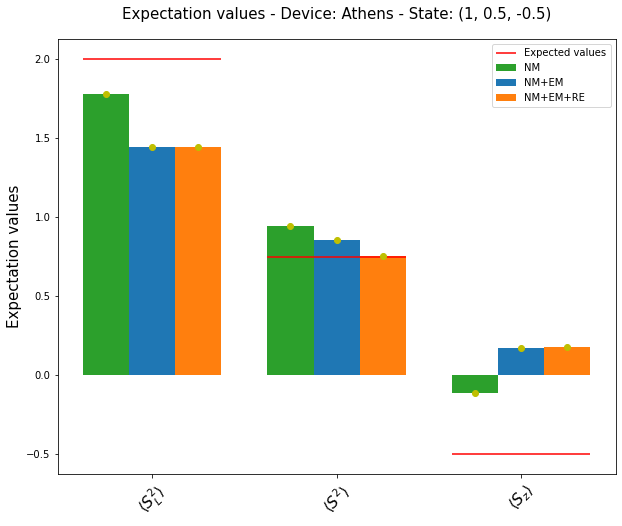

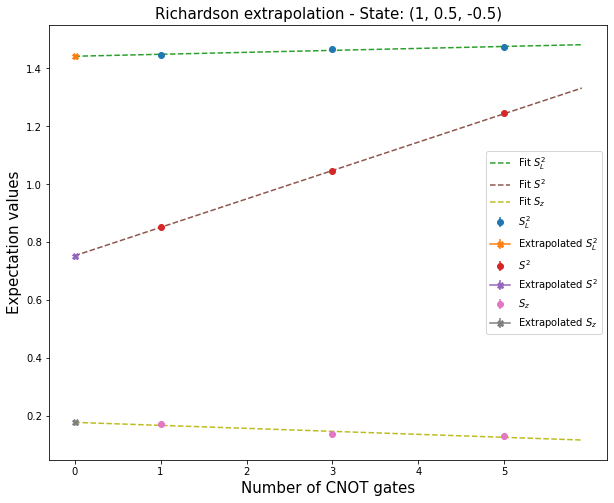

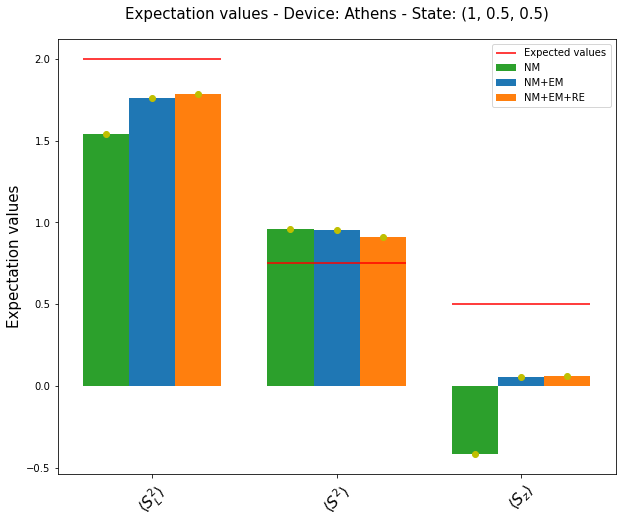

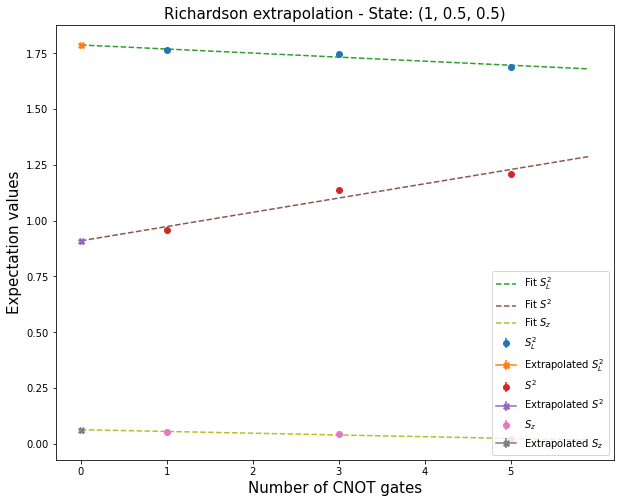

In [26]:
# Definition of straight line
def straight_line(x,m,q):
    return m*x+q

file=open("Results/VQE_spin_qasm_ry1_with_variance.out")      # Before: VQE_spin_qasm_2.out
line=file.readlines()
line_val = []
for el in line:
    el2 = el.split()
    if el2[0]!="Job":
        line_val.append(el2)
        
s= 8192     # Number of shots
cl=0        # Count lines
for i in range(4):
    data_raw,err_raw=[],[]
    data_1,err_1=[],[]
    data_3,err_3=[],[]
    data_5,err_5=[],[]
    data_re,err_re=[],[]
    for j in range(12):
        val = line_val[cl]
        if j<3:
            data_raw.append(float(val[0]))
            err_raw.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=3 and j<6:
            data_1.append(float(val[0]))
            err_1.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=6 and j<9:
            data_3.append(float(val[0]))
            err_3.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        elif j>=9 and j<12:
            data_5.append(float(val[0]))
            err_5.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        cl+=1
    
    for k in range(len(data_1)):
        #print([data_1[k],data_3[k],data_5[k]])
        p_ave, p_cov = curve_fit(straight_line,[1,3,5],[data_1[k],data_3[k],data_5[k]],sigma=[err_1[k],err_3[k],err_5[k]],absolute_sigma=True)
        data_re.append(p_ave[1])
        err_re.append(np.sqrt(p_cov[1,1]))
    
    # The histograms - Plot of expectation values
    l=lab_list[i]
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
    ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')
    
    rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
    ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')
    
    rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
    ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')
    
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=15)
    ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
    ax.set_xticks(x_lab)
    ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
    ax.legend()
    plt.show()
    
    
    # Richardson extrapolation analysis
    plt.figure(figsize=(10,8))
    op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]
    for j in range(3):
        # Data
        plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],marker='o',ls="none",label=op_labels[j])
        # Extrapolated data
        p_ave,p_cov = curve_fit(straight_line,[1,3,5],[data_1[j],data_3[j],data_5[j]],sigma=[err_1[j],err_3[j],err_5[j]],absolute_sigma=True)                                                                                    
        plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j])
        # Fit
        u = list(np.arange(0,6,0.1))
        v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
        plt.plot(u,v,'--',label='Fit '+op_labels[j])                                                                                    
    
    plt.title("Richardson extrapolation - State: "+str(l),size=15)
    plt.xlabel("Number of CNOT gates",size=15)
    plt.xticks(np.arange(6))
    plt.ylabel("Expectation values",size=15)
    plt.legend()

#### Fidelities (no statistical information)

In [28]:
cl = 48

psi_1 = Zero(3)
#Here we define the circuit upon initial state assumption
var_form = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

for i in range(4):
    print("State label: ",lab_list[i])
    for j in range(2):
        param=[]
        if j==0:
            print("       Noise model results")
        if j==1:
            print("       Noise model + error mitigation results")
        for k in range(13):
            val = line_val[cl]
            if k==0:
                print("          C(s_L,s,s_z) = ",val[0])
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ = var_form.assign_parameters(param)          # With RealAmplitudes/TwoLocal
        #best_circ=var_form.construct_circuit(param)         # With VariationalForm
        best_psi = CircuitStateFn(best_circ).to_matrix()
        # The best state
        #print("          | optimal > = ",to_ket(best_psi))
        # Fidelity
        int_prod = np.dot(np.conjugate(eig_3spins[i]),to_state(np.real(best_psi)))
        fid = np.conjugate(int_prod)*int_prod
        print("          |< ideal | optimal >|^2 = ",fid,"\n")

State label:  (0, 0.5, -0.5)
       Noise model results
          C(s_L,s,s_z) =  0.48021446575397075
          |< ideal | optimal >|^2 =  0.6806192653745453 

       Noise model + error mitigation results
          C(s_L,s,s_z) =  0.2744181282587183
          |< ideal | optimal >|^2 =  0.7860439306583317 

State label:  (0, 0.5, 0.5)
       Noise model results
          C(s_L,s,s_z) =  0.6821366263730511
          |< ideal | optimal >|^2 =  0.7829930881893217 

       Noise model + error mitigation results
          C(s_L,s,s_z) =  0.4941207409884618
          |< ideal | optimal >|^2 =  0.8133788241198866 

State label:  (1, 0.5, -0.5)
       Noise model results
          C(s_L,s,s_z) =  0.6665347698075597
          |< ideal | optimal >|^2 =  0.5599432356256898 

       Noise model + error mitigation results
          C(s_L,s,s_z) =  0.7206238993798146
          |< ideal | optimal >|^2 =  0.29790761151867795 

State label:  (1, 0.5, 0.5)
       Noise model results
          C(s_L,s,s_

# Time evolution with $H=\sum_{i<j} \mathbf{\hat{S}}_i  \cdot\mathbf{\hat{S}}_j$ - Analysis of the Dicke states

# $|s_L=1,s=3/2,s_z=-1/2\rangle$ ($1$st Dicke state)

We start from the initial state $|\psi(0) \rangle = |\downarrow \downarrow \uparrow \rangle = |110 \rangle = |s=1,s_z=-1 \rangle_{01} |s=1/2,s_z=1/2 \rangle_2$.

$$|\psi(t) \rangle = c_1(t) |s_L=1,s=3/2,s_z=-1/2 \rangle + c_2(t) |s_L=1,s=1/2,s_z=1/2 \rangle$$

We want to find the first of the two states above, therefore we need $t$  such $c_1(t)=1$ and $c_0(t)=0$. 

$$\begin{cases}
& c_1(t)= e^{-iE_1t} c_1(0) = e^{-iE_1t} A \\
& c_2(t)= e^{-iE_2t} c_2(0) = - e^{-iE_2t} B 
\end{cases}
\Rightarrow
\begin{cases}
& 1 = e^{-i\frac{3}{4}t} \sqrt{\frac{s+s_z+1}{2s+1}} \\
& 0 = e^{i\frac{3}{4}t} \sqrt{\frac{s-s_z}{2s+1}}
\end{cases}
$$

$$t=\frac{4}{3}\arccos{\biggl( \frac{1}{2}\sqrt{\frac{2s+1}{s+s_z+1}} \biggr)}$$

We want to measure the operators $\hat{S}_{L}^2$, $\hat{S}^2$ and $\hat{S}_z$ on the final state $|\psi(t) \rangle$. If we call $\hat{O}$ the generic operator, we have that:

$$\langle \psi(t) | \hat{O} | \psi(t) \rangle = \langle e^{-i\hat{H}t} \psi(0) | \hat{O} | e^{-i\hat{H}t} \psi(0) \rangle$$

In particular we are going to use the **Trotter decomposition** of $e^{-i\hat{H}t}$ to describe the evolution with a precise circuit.

## QASM simulation with noise model and error correction

- Fixed number of shots: $8000$
- Different hardware devices: *Athens*, *Yorktown*, *Melbourne*

In [14]:
# Evolution time
t=(4/3)*np.arccos(0.5*np.sqrt(3))
print("Evolution time: ",t)

# We use the gate because we want to create the initial state
def two_spin(J,M):                      # Two spin 1/2
    qr = QuantumRegister(2,'q')                 
    qc = QuantumCircuit(qr)
    if J==0:
        qc.x(0)
        qc.h(0)
        qc.x(1)
    else:
        if M==0:
            qc.h(0)
            qc.x(1)
        elif M==-1:
            qc.x(0)
    qc.cx(0,1)
    #print(qc.draw())
    #two_spin=qc.to_instruction()          # Another possible way to deal with the construction of the gate
    two_spin=qc.to_gate(label="2-spin")
    return two_spin

Evolution time:  0.6981317007977319


In [100]:
sl2_val=[np.zeros((3,2)) for i in range(1,21)]
s2_val=[np.zeros((3,2)) for i in range(1,21)]
sz_val=[np.zeros((3,2)) for i in range(1,21)]

for N in range(1,21):
    # Parameter time/N inside Trotter 
    th=t/N

    qr=QuantumRegister(3,'q')
    Tc=QuantumCircuit(qr)
    # Factor 2 because inside Rxx, Ryy and Rzz the parameter is divided by 2
    Tc.rxx(2*th,0,1)
    Tc.ryy(2*th,0,1)
    Tc.rzz(2*th,0,1)
    Tc.rxx(2*th,1,2)
    Tc.ryy(2*th,1,2)
    Tc.rzz(2*th,1,2)
    Tc.rxx(2*th,0,2)
    Tc.ryy(2*th,0,2)
    Tc.rzz(2*th,0,2)
    TrotterGate=Tc.to_gate(label="Trotter/N")
    if N==1:
        display(Markdown(r"Quantum circuit associate with $e^{-i\frac{t}{N}H}$"))
        print(Tc.draw())
      
    # Here we create the circuit exp^{-iHt} psi(0)
    qc=QuantumCircuit(qr)
    # Initial state psi(0)= | 110 >
    qc.append(two_spin(1,-1),[0,1])
    for i in range(N):
        qc.append(TrotterGate,[0,1,2])
    
    print("N = ",N)
    for count_hardware in range(3):
        #provider = IBMQ.get_provider(hub='ibm-q-internal',group='deployed') # CHOOSE THE GROUP OF HW (internal)
        provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
        if count_hardware==0:
            device   = provider.get_backend('ibmq_athens')                        # 5 qubits, linear, good
            print("Hardware: ATHENS")
        elif count_hardware==1:
            device   = provider.get_backend('ibmq_5_yorktown')                    # 5 qubits, papillon, medium
            print("Hardware: YORKTOWN")
        else:
            device   = provider.get_backend('ibmq_16_melbourne')                  # 16 qubits, "ladder", bad
            print("Hardware: MELBOURNE")
        
        # Definition of instance 
        s=8092
        instance = QuantumInstance(backend                      = backend,
                               shots                            = s,
                               noise_model                      = NoiseModel.from_backend(device.properties()),
                               coupling_map                     = device.configuration().coupling_map,
                               measurement_error_mitigation_cls = CompleteMeasFitter, # <=====
                               optimization_level               = 3,
                               initial_layout                   = [0,1,2])
        
        print("Operator | Mean | Standard deviation")

        mu,sigma   = measure_operator(op_I,qc,instance)
        print("I",mu,np.sqrt(sigma/s))

        mu1,sigma1 = measure_operator(op_sl2,qc,instance)  # Here the difference
        print("S_L^2",mu1,np.sqrt(sigma1/s))
        sl2_val[N-1][count_hardware,0]=mu1
        sl2_val[N-1][count_hardware,1]=np.sqrt(sigma1/s)

        mu2,sigma2 = measure_operator(op_s2,qc,instance)
        print("S^2",mu2,np.sqrt(sigma2/s))
        s2_val[N-1][count_hardware,0]=mu2
        s2_val[N-1][count_hardware,1]=np.sqrt(sigma2/s)

        mu3,sigma3 = measure_operator(op_sz,qc,instance)
        print("S_z",mu3,np.sqrt(sigma3/s))
        sz_val[N-1][count_hardware,0]=mu3
        sz_val[N-1][count_hardware,1]=np.sqrt(sigma3/s)
        print("\n")

Quantum circuit associate with $e^{-i\frac{t}{N}H}$

     ┌────────────┐┌────────────┐                                       »
q_0: ┤0           ├┤0           ├─■─────────────────────────────────────»
     │  RXX(4π/9) ││  RYY(4π/9) │ │zz(4π/9) ┌────────────┐┌────────────┐»
q_1: ┤1           ├┤1           ├─■─────────┤0           ├┤0           ├»
     └────────────┘└────────────┘           │  RXX(4π/9) ││  RYY(4π/9) │»
q_2: ───────────────────────────────────────┤1           ├┤1           ├»
                                            └────────────┘└────────────┘»
«                ┌────────────┐┌────────────┐           
«q_0: ───────────┤0           ├┤0           ├─■─────────
«                │            ││            │ │         
«q_1: ─■─────────┤  RXX(4π/9) ├┤  RYY(4π/9) ├─┼─────────
«      │zz(4π/9) │            ││            │ │zz(4π/9) 
«q_2: ─■─────────┤1           ├┤1           ├─■─────────
«                └────────────┘└────────────┘           
N =  1
Hardware: ATHENS
Operator | Mean | Standard deviation
I 1.000000000000093 1.

I 0.9999999999999999 1.2341907659563458e-18
S_L^2 1.9441754609480917 0.008039440460565225
S^2 1.774407727426334 0.013761392005653525
S_z -0.47215018801862846 0.0020853175824347312


Hardware: MELBOURNE
Operator | Mean | Standard deviation
I 1.000000000000235 2.6115476607639353e-15
S_L^2 1.9593607979223544 0.008098326812830016
S^2 1.7357459309816 0.013505014269778967
S_z -0.4481582990110834 0.002464632151997739


N =  12
Hardware: ATHENS
Operator | Mean | Standard deviation
I 1.0 0.0
S_L^2 1.9748455844388908 0.00806539555487597
S^2 1.7797352966752795 0.013758634170323589
S_z -0.4867282778803232 0.001527362651552483


Hardware: YORKTOWN
Operator | Mean | Standard deviation
I 1.0 0.0
S_L^2 1.958136688201227 0.008128779079753711
S^2 1.7524025253423745 0.013646421544650698
S_z -0.46765762913986214 0.0023593261161835776


Hardware: MELBOURNE
Operator | Mean | Standard deviation
I 1.000000000000119 1.3230525011052815e-15
S_L^2 1.870255096325085 0.008303977606943834
S^2 1.8828874897169574 0.01

#### Expectation values with increasing number of repetitions (depth)

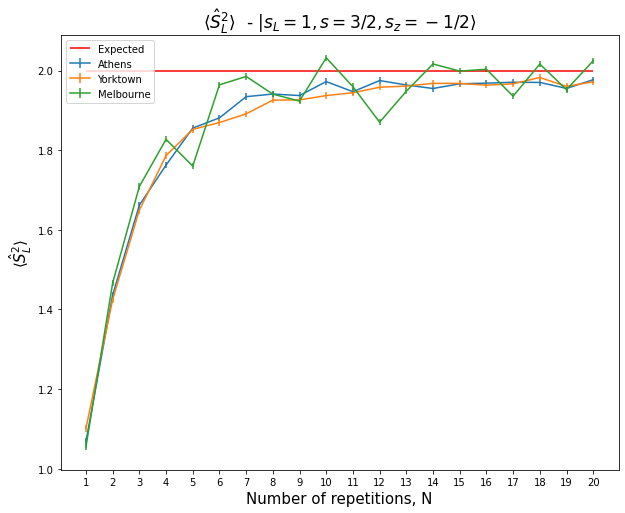

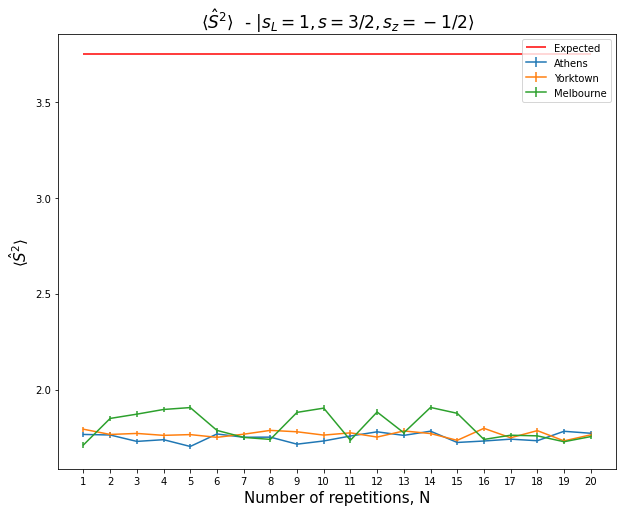

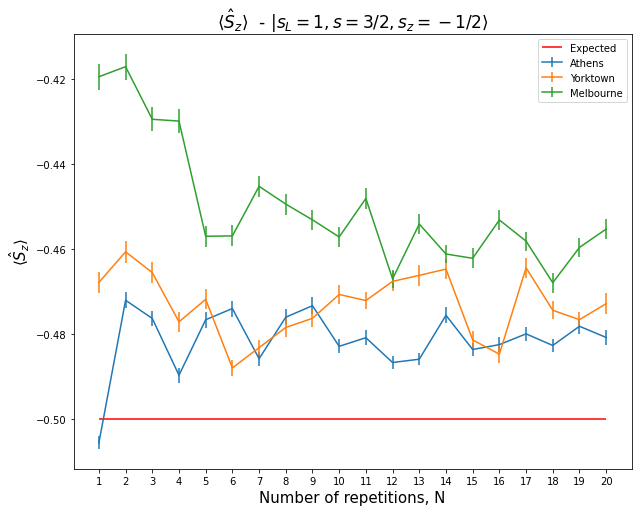

In [101]:
hardware_names=["Athens","Yorktown","Melbourne"]
# Plot of S_L^2
plt.figure(figsize=(10,8))

for h in range(3):
    data=[]
    err_data=[]
    for i in range(len(sl2_val)):
        data.append(sl2_val[i][h,0])
        err_data.append(sl2_val[i][h,1])
    plt.errorbar(np.arange(1,21),data,yerr=err_data,label=hardware_names[h])

plt.title(r'$\langle \hat{S}_L^2 \rangle$  - $|s_L=1,s=3/2,s_z=-1/2\rangle$',fontsize=17)
plt.xlabel('Number of repetitions, N',fontsize=15)
plt.ylabel(r'$\langle \hat{S}_L^2 \rangle$',fontsize=15)
plt.hlines(y=2,xmin=1,xmax=20,color='r',label="Expected")
plt.xticks(np.arange(1,21))
plt.legend()
plt.show()

# Plot of S^2
plt.figure(figsize=(10,8))

for h in range(3):
    data=[]
    err_data=[]
    for i in range(len(s2_val)):
        data.append(s2_val[i][h,0])
        err_data.append(s2_val[i][h,1])
    plt.errorbar(np.arange(1,21),data,yerr=err_data,label=hardware_names[h])

plt.title(r'$\langle \hat{S}^2 \rangle$  - $|s_L=1,s=3/2,s_z=-1/2\rangle$',fontsize=17)
plt.xlabel('Number of repetitions, N',fontsize=15)
plt.ylabel(r'$\langle \hat{S}^2 \rangle$',fontsize=15)
plt.hlines(y=3.75,xmin=1,xmax=20,color='r',label="Expected")
plt.xticks(np.arange(1,21))
plt.legend()
plt.show()

# Plot of S_z
plt.figure(figsize=(10,8))

for h in range(3):
    data=[]
    err_data=[]
    for i in range(len(sz_val)):
        data.append(sz_val[i][h,0])
        err_data.append(sz_val[i][h,1])
    plt.errorbar(np.arange(1,21),data,yerr=err_data,label=hardware_names[h])

plt.title(r'$\langle \hat{S}_z \rangle$  - $|s_L=1,s=3/2,s_z=-1/2\rangle$',fontsize=17)
plt.xlabel('Number of repetitions, N',fontsize=15)
plt.ylabel(r'$\langle \hat{S}_z \rangle$',fontsize=15)
plt.hlines(y=-0.5,xmin=1,xmax=20,color='r',label="Expected")
plt.xticks(np.arange(1,21))
plt.legend()
plt.show()

It seems that we are looking at a state which is not the expected one.

# VQE based on time evolution - Analysis of the Dicke states

We want to start a **QASM** simulation using the VQE circuit based on time evolution, where we have **1 parameter for each gate**. In particular we will fix the number of repetitions of the circuit to $2$ because in tha case of the statevector simulation it was enough to find an optimal state with fidelity above $99,99$% w.r.t. the expected spin eigenstate.

#### Definition of the "time evolution" variational form

In [15]:
from  typing import List, Optional, Union
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.components.initial_states import InitialState

# 1 parameter for each gate    
class EvolVarForm3(VariationalForm): # definizione di un Ansatz variazionale 
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        
        if(connections=='full'):
            self._connections = [(i,j) for i in range(num_qubits) for j in range(num_qubits) if j>i]
        elif(connections=='linear'):
            self._connections = [(i,i+1) for i in range(num_qubits-1)]
        else:
            self._connections = connections
        
        # Here the difference 
        if reps==1:
            self._num_parameters = 6  
        else:
            self._num_parameters = 6  + (self._reps-1)*3*len(self._connections)
        
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    # dati parametri theta, costruire un circuito che restituisce Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        
        # In the following cycle the differences w.r.t. the previous EvolVarForm
        # c counts blocks of 3 gates
        c=0
        for l in range(self._reps):
            if(l==0): # Special structure for 1st layer (no e^{-i epsilon H_0})
                for [i,j] in  self._connections:
                    if i==(self._num_qubits-1) or j==(self._num_qubits-1):
                        circuit.rxx(2*parameters[3*c+0],i,j)
                        circuit.ryy(2*parameters[3*c+1],i,j)
                        circuit.rzz(2*parameters[3*c+2],i,j)
                        c+=1
            else:
                for [i,j] in self._connections:
                    circuit.rxx(2*parameters[3*c+0],i,j)
                    circuit.ryy(2*parameters[3*c+1],i,j)
                    circuit.rzz(2*parameters[3*c+2],i,j)
                    c+=1
        return circuit
    
# 1 parameter for R_xx gates, 1 for R_yy and 1 for R_zz 
class EvolVarForm5(VariationalForm): # definizione di un Ansatz variazionale 
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        
        if(connections=='full'):
            self._connections = [(i,j) for i in range(num_qubits) for j in range(num_qubits) if j>i]
        elif(connections=='linear'):
            self._connections = [(i,i+1) for i in range(num_qubits-1)]
        else:
            self._connections = connections
        
        # Here the difference 
        self._num_parameters = self._reps*3
        
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    # dati parametri theta, costruire un circuito che restituisce Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        
        # In the following cycle the differences w.r.t. the previous EvolVarForm
        # c count the repetitions
        c=0
        for l in range(self._reps):
            if(l==0): # Special structure for 1st layer (no e^{-i epsilon H_0})
                for [i,j] in  self._connections:
                    if i==(self._num_qubits-1) or j==(self._num_qubits-1):
                        circuit.rxx(2*parameters[3*c+0],i,j)
                        circuit.ryy(2*parameters[3*c+1],i,j)
                        circuit.rzz(2*parameters[3*c+2],i,j)
                c+=1
            else:
                for [i,j] in self._connections:
                    circuit.rxx(2*parameters[3*c+0],i,j)
                    circuit.ryy(2*parameters[3*c+1],i,j)
                    circuit.rzz(2*parameters[3*c+2],i,j)
                c+=1
        return circuit

#### Definition of cost function and its corresponding gradient
The following functions are equal to the previous used functions, but they work when we deal with `VariationalForm`, instead of `RealAmplitudes`.

In [16]:
def spin_cost(x):
    # QASM - Expectation values
    #circ=var_form.assign_parameters(x)                              # To use with RealAmplitude/TwoLocal
    circ=var_form.construct_circuit(x)                               # To use with VariationalForm
    
    braket1=StateFn(op_sl2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket1)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f1=sampled_op.eval().real                                        # Get expectation value

    braket2=StateFn(op_s2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket2)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f2=sampled_op.eval().real                                        # Get expectation value

    braket3=StateFn(op_sz,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket3)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f3=sampled_op.eval().real                                        # Get expectation value

    return (f1-l[0]*(l[0]+1))**2 + (f2-l[1]*(l[1]+1))**2 + (f3-l[2])**2

def grad_spin_cost(x):
    # QASM
    # Expectation values
    #circ=var_form.assign_parameters(x)                              # To use with RealAmplitude/TwoLocal
    circ=var_form.construct_circuit(x)                               # To use with VariationalForm

    braket1=StateFn(op_sl2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket1)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f1=sampled_op.eval().real                                        # Get expectation value

    braket2=StateFn(op_s2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket2)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f2=sampled_op.eval().real                                        # Get expectation value

    braket3=StateFn(op_sz,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket3)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f3=sampled_op.eval().real                                        # Get expectation value
    
    # Here we create the dictionary which associates at each Parameter the corresponding value
    #pv=var_form.ordered_parameters
    pv=ParameterVector("th",var_form.num_parameters)
    par={pv[i] : x[i] for i in range(len(pv))}
    var_form2=var_form.construct_circuit(pv)
    
    # Gradients
    state_grad1=grad.convert(operator=~StateFn(op_sl2) @ CircuitStateFn(primitive=var_form2),params=pv)
    state_grad2=grad.convert(operator=~StateFn(op_s2) @ CircuitStateFn(primitive=var_form2),params=pv)
    state_grad3=grad.convert(operator=~StateFn(op_sz) @ CircuitStateFn(primitive=var_form2),params=pv)

    g1=[np.real(el) for el in state_grad1.assign_parameters(par).eval()]
    g2=[np.real(el) for el in state_grad2.assign_parameters(par).eval()]
    g3=[np.real(el) for el in state_grad3.assign_parameters(par).eval()]

    grad_val=[]
    for i in range(len(g1)):
        grad_val.append(2*(f1-l[0]*(l[0]+1))*g1[i] + 2*(f2-l[1]*(l[1]+1))*g2[i] + 2*(f3-l[2])*g3[i])

    return grad_val

# $|s_L=1,s=3/2,s_z=-1/2\rangle$ ($1$st Dicke state)

We start from the initial state $|\psi(0) \rangle = |\downarrow \downarrow \uparrow \rangle = |110 \rangle = |s=1,s_z=-1 \rangle_{01} |s=1/2,s_z=1/2 \rangle_2$ because using the time evolution we can get:

$$|\psi(t) \rangle = c_1(t) |s_L=1,s=3/2,s_z=-1/2 \rangle + c_2(t) |s_L=1,s=1/2,s_z=1/2 \rangle$$

## `EvolVarForm3` ($1$ parameter for each gate)

#### Definition of the ansatz

We are going to use the "time evolution" variational form with:
- $|\psi(0) \rangle = |\downarrow \downarrow \uparrow \rangle = |110 \rangle = |s=1,s_z=-1 \rangle_{01} |s=1/2,s_z=1/2 \rangle_2$
- Depth equal to $2$

In [68]:
def two_spin(J,M):                      # Two spin 1/2
    qr = QuantumRegister(2,'q')                 
    qc = QuantumCircuit(qr)
    if J==0:
        qc.x(0)
        qc.h(0)
        qc.x(1)
    else:
        if M==0:
            qc.h(0)
            qc.x(1)
        elif M==-1:
            qc.x(0)
    qc.cx(0,1)
    #print(qc.draw())
    #two_spin=qc.to_instruction()          # Another possible way to deal with the construction of the gate
    two_spin=qc.to_gate(label="2-spin")
    return two_spin

# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,-1)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm3(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of circuit with generic parameters"))
circ=var_form.construct_circuit(ParameterVector('θ',var_form.num_parameters)) 
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0. 0. 0. 1. 0. 0. 0. 0.]


Example of circuit with generic parameters

     ┌────────────┐                        ┌───┐┌─────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(-π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└─────────────┘└─┬─┘»
q_1: ┤ U(π/2,0,0) ├┤ X ├┤ U(π/2,0,0) ├┤ X ├──■───────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                      │  »
q_2: ────────────────■──────────────────■────────────────────────■──»
                                                                    »
«     ┌─────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └─────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ─────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[1]) ├»
«                                         │  │              ││              │»
«q_2: ────────────────────────────────────■──┤1             ├┤1             ├»
«                                   

## QASM simulation - Noise model, (measurement) error correction and Richardson extrapolation

### Histograms of expectation values and Richardson extrapolation

**Remark** When we use the method of the multiplication of gates to reduce the number of errors on gates $R_{xx}$, $R_{yy}$ and $R_{zz}$, we transpile those gates into simpler gates and then we use the method on them. 

In [20]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# Definition of the device
device   = provider.get_backend('ibmq_athens')

# Before using Richardson extrapolation in the script, we transpile the R_{xx}, R_{yy} and R_{zz} gates
circ2   = QuantumCircuit(QuantumRegister(nqubits,'q'))
for g in circ:
    instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
    #print(instruction.name)
    if(instruction.name=='cx'): 
        circ2.cx(qubits[0],qubits[1])
    elif(instruction.name=='x'):
        circ2.x(qubits[0])
    elif(instruction.name=='rz'):
        t1 = instruction.params[0]
        circ.rz(t1,qubits[0].index)
    elif(instruction.name=='ry'):
        t1 = instruction.params[0]
        circ2.ry(t1,qubits[0])
    elif(instruction.name=='ch'):
        circ2.ch(qubits[0],qubits[1])
    elif(instruction.name=='u'):
        t1,t2,t3 = instruction.params
        circ2.u(t1,t2,t3,qubits[0])
    elif (instruction.name=='rxx') or (instruction.name=='ryy') or (instruction.name=='rzz'):
        qc = QuantumCircuit(QuantumRegister(nqubits,'q'))
        
        if (instruction.name=='rxx'):
            qc.rxx(instruction.params[0],qubits[0],qubits[1])
        elif (instruction.name=='ryy'):
            qc.ryy(instruction.params[0],qubits[0],qubits[1])
        elif (instruction.name=='rzz'):
            qc.rzz(instruction.params[0],qubits[0],qubits[1])
            
        trans_g = transpile(qc,device,optimization_level=1,initial_layout=[0,1,2])
        # Inserting in circ2 the gates of the transpiled R_xx, R_yy and R_zz
        for g2 in trans_g:
            instruction2,qubits2,_ = g2 # extract gate info (domain: q1,q2 -- instruction)
            if(instruction2.name=='cx'):
                circ2.cx(qubits2[0].index,qubits2[1].index)
            elif(instruction2.name=='rz'):
                t1 = instruction2.params[0]
                circ2.rz(t1,qubits2[0].index)
            elif(instruction2.name=='sx'):
                circ2.sx(qubits2[0].index)
            elif(instruction2.name=='u'):
                t1,t2,t3 = instruction2.params[0]
                circ2.u(t1,t2,t3,qubits2[0].index)
    #else:
    #    print(instruction.name)
    
print("Ansatz with R_{xx}, R_{yy} and R_{zz} replaced by their transpiled gates")
print(circ2.draw())

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Ansatz with R_{xx}, R_{yy} and R_{zz} replaced by their transpiled gates
     ┌────────────┐                        ┌───┐┌─────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(-π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└─────────────┘└─┬─┘»
q_1: ┤ U(π/2,0,0) ├┤ X ├┤ U(π/2,0,0) ├┤ X ├──■───────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                      │  »
q_2: ────────────────■──────────────────■────────────────────────■──»
                                                                    »
«     ┌─────────────┐┌───┐┌────────────┐┌───┐┌─────────┐┌────┐┌─────────┐»
«q_0: ┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├»
«     └─────────────┘└─┬─┘└────────────┘└─┬─┘└─────────┘├───┬┘└─────────┘»
«q_1: ─────────────────■──────────────────┼───────■─────┤ X ├──────■─────»
«                                         │     ┌─┴─┐   └─┬─┘    ┌─┴─┐   »
«q_2: ────────────────────────────────────■─────┤ X ├─────■───

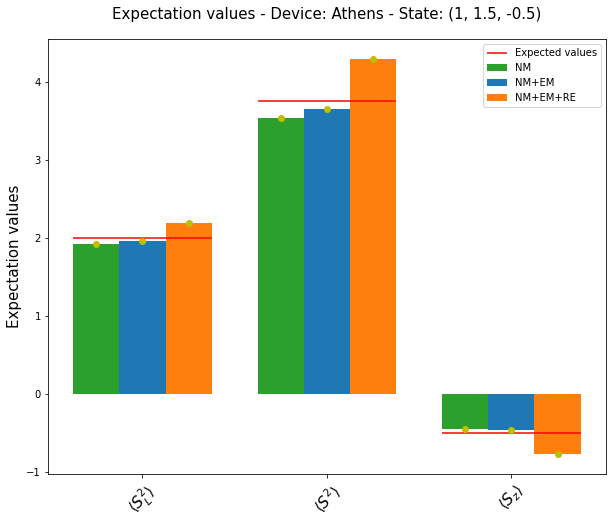

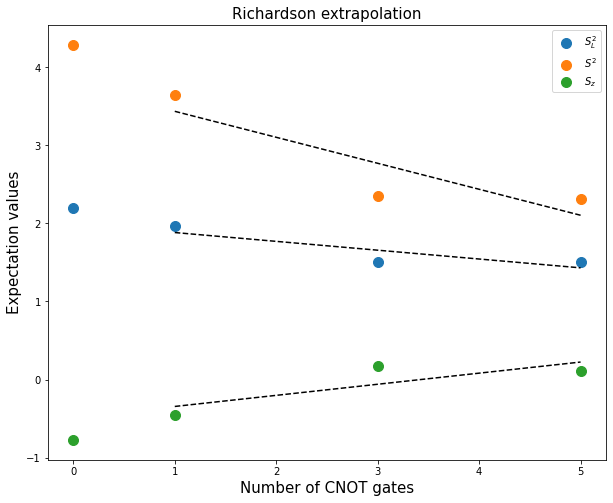

In [33]:
file=open("Results/VQE_spin_qasm_evolvarform3_lab5.out")      # Before: VQE_spin_qasm_2.out
line=file.readlines()

s= 8092     # Number of shots
cl=0        # Count lines

data_raw,err_raw=[],[]
data_1,err_1=[],[]
data_3,err_3=[],[]
data_5,err_5=[],[]
data_re,err_re=[],[]

for j in range(12):
    val=line[cl].split()
    if j<3:
        data_raw.append(float(val[0]))
        err_raw.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=3 and j<6:
        data_1.append(float(val[0]))
        err_1.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=6 and j<9:
        data_3.append(float(val[0]))
        err_3.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=9 and j<12:
        data_5.append(float(val[0]))
        err_5.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    cl+=1
    
for i in range(len(data_1)):
    data_re.append( data_1[i]+(data_1[i]-data_3[i])/2.0 )
    err_re.append(np.sqrt((err_1[i]**2+(err_1[i]**2+err_3[i]**2)/4.0)/s))
    
# The histograms - Plot of expectation values
l=lab_list[5]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')

rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')

rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')

ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()


# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
from matplotlib.pyplot import cm
color=cm.rainbow(np.linspace(0,1,100))

op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]

for j in range(3):
    plt.errorbar([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],yerr=[err_re[j],err_1[j],err_3[j],err_5[j]],ls="none")

    coeff = np.polyfit([1,3,5],[data_1[j],data_3[j],data_5[j]],1)
    poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.scatter([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],s=100,label=op_labels[j])
    plt.plot([1,3,5], poly1d_fn([1,3,5]), '--k')
plt.title("Richardson extrapolation",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=15)
plt.legend()


**Observations/Questions**

- Are the assumptions of Richardson extrapolation true yet? Should we use the linear regression method on all those data or should we use another method?

- Should we consider more data to evaluate the linear regression?

### Histogram of expectation values with RE on values with $1$,$3$ and $5$ CNOTs

#### Variance on extrapolated expectation value with $0$-noise error

Reference: *Cannelli, Metodologie sperimentali in Fisica* (page 158-159-160)

We use linear regression on results associated with $1$,$3$ and $5$ **CNOT**s. If we call the line coming from regression $y = A + Bx$:

$$A = \frac{\sum x_i^2 \sum y_i - \sum x_i \sum x_i y_i}{\underbrace{N \sum x_i^2 - \Bigl( \sum x_i \Bigr)^2}_{\Delta} }$$

Then we can use the following formula to calculate the variance of the extrapolated value with $x=0$.

$$\sigma_{extr}^2(x=0) = \sigma_A^2 = \sum_{j=1}^N \biggl( \frac{\partial A}{\partial y_j} \biggr)^2 \sigma_{y_j}^2 = \sum_{j=1}^N \biggl[ \biggl( \sum x_i^2 \biggr)^2 - 2 x_j \biggl( \sum x_i \biggr) \biggl( \sum x_i^2 \biggr) + x_j^2 \biggl( \sum x_i \biggr)^2\biggr] \frac{\sigma_{y_i}^2}{\Delta^2}$$


In [23]:
def extr_dev_std(x,sigma):
    s   = 0
    sx  = 0
    sx2 = 0
    for i in range(len(x)):
        sx  += x[i]
        sx2 += x[i]**2
    delta = len(x)*sx2 - sx**2
    
    for j,xj in enumerate(x):
        s += (sx2**2 + -2*xj*sx*sx2 + (sx**2)*(xj**2))*(sigma[j]**2)
    return np.sqrt(s/(delta**2))

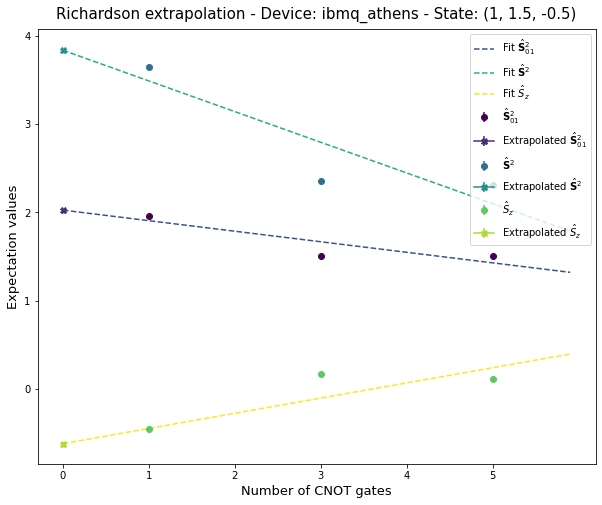

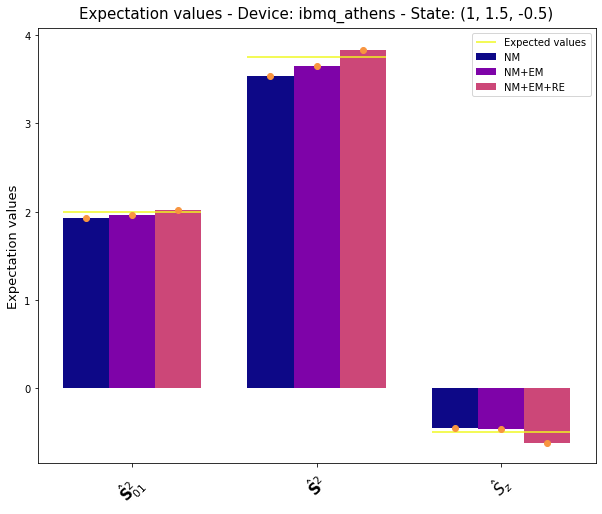

In [34]:
'''
# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]

data_re,err_re = [],[]

for j in range(3):
    plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],ls="none")

    coeff = np.polyfit([1,3,5],[data_1[j],data_3[j],data_5[j]],1)
    data_re.append(coeff[1])
    err_re.append(extr_dev_std([1,3,5],[err_1[j],err_3[j],err_5[j]]))
    
    poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.scatter([0,1,3,5],[coeff[1],data_1[j],data_3[j],data_5[j]],s=100,label=op_labels[j])
    plt.plot([1,3,5], poly1d_fn([1,3,5]), '--k')
    
plt.title("Richardson extrapolation",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=15)
plt.legend()

    
# The histograms - Plot of expectation values
l=lab_list[5]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')

rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')

rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')

ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()
'''

op_labels=[r"$\hat{\mathbf{S}}_{01}^2$",r"$\hat{\mathbf{S}}^2$",r"$\hat{S}_z$"]

# Richardson extrapolation analysis
jet = plt.get_cmap('viridis')
colors = iter(jet(np.linspace(0,1,9)))

data_re, err_re = [],[]

plt.figure(figsize=(10,8))
for j in range(3):
    # Data
    plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],marker='o',ls="none",label=op_labels[j],color=next(colors))
    # Extrapolated data
    p_ave,p_cov = curve_fit(straight_line,[1,3,5],[data_1[j],data_3[j],data_5[j]],sigma=[err_1[j],err_3[j],err_5[j]],absolute_sigma=True)                                                                                    
    plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j],color=next(colors))
    data_re.append(p_ave[1])
    err_re.append(np.sqrt(p_cov[1,1]))
    # Fit
    u = list(np.arange(0,6,0.1))
    v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
    plt.plot(u,v,'--',label='Fit '+op_labels[j], color=next(colors))                                                                                    

plt.title("Richardson extrapolation - Device: ibmq_athens - State: "+str(l),size=15,pad=10)
plt.xlabel("Number of CNOT gates",size=13)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=13)
plt.legend()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/EvolVarForm_qasm_3_RE_5.pdf")

# The histograms - Plot of expectation values
jet = plt.get_cmap('plasma')
colors = iter(jet(np.linspace(0,1,5)))

l = lab_list[5]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color=next(colors))
rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color=next(colors))
rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color=next(colors))

c = next(colors)
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color=c)
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color=c)
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color=c)

c = next(colors)
ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors=c)
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors=c)
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors=c,label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=13)
ax.set_title(r'Expectation values - Device: ibmq_athens - State: '+str(l),fontsize=15,pad=10)
ax.set_xticks(x_lab)
ax.set_xticklabels(op_labels,rotation=45,size=15)
ax.legend()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/EvolVarForm_qasm_3_5.pdf")

## `EvolVarForm5` with `reps=2`($1$ parameter for $R_{xx}$, $1$ for $R_{yy}$, $1$ for $R_{zz}$)

#### Definition of the ansatz

We are going to use the "time evolution" variational form with:
- $|\psi(0) \rangle = |\downarrow \downarrow \uparrow \rangle = |110 \rangle = |s=1,s_z=-1 \rangle_{01} |s=1/2,s_z=1/2 \rangle_2$ as initial state
- Depth equal to $2$

In [72]:
# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,-1)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm5(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of circuit with generic parameters"))
circ=var_form.construct_circuit(ParameterVector('θ',var_form.num_parameters)) 
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0. 0. 0. 1. 0. 0. 0. 0.]


Example of circuit with generic parameters

     ┌────────────┐                        ┌───┐┌─────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(-π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└─────────────┘└─┬─┘»
q_1: ┤ U(π/2,0,0) ├┤ X ├┤ U(π/2,0,0) ├┤ X ├──■───────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                      │  »
q_2: ────────────────■──────────────────■────────────────────────■──»
                                                                    »
«     ┌─────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └─────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ─────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[1]) ├»
«                                         │  │              ││              │»
«q_2: ────────────────────────────────────■──┤1             ├┤1             ├»
«                                   

## QASM simulation - Noise model, (measurement) error correction and Richardson extrapolation

### Histograms of expectation values and Richardson extrapolation

**Remark** When we use the method of the multiplication of gates to reduce the number of errors on gates $R_{xx}$, $R_{yy}$ and $R_{zz}$, we transpile those gates into simpler gates and then we use the method on them. 

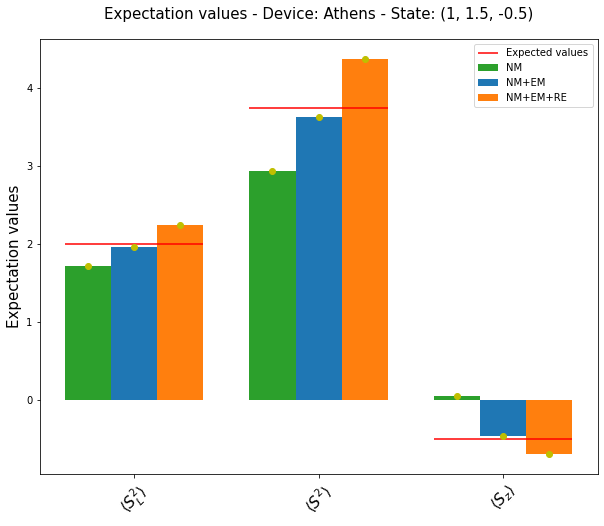

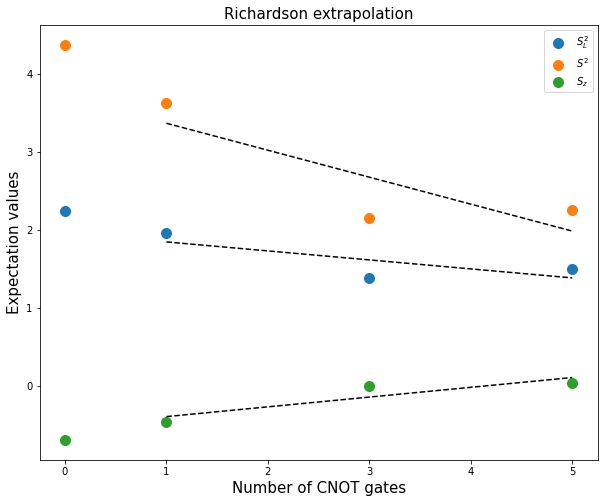

In [73]:
file=open("Results/VQE_spin_qasm_evolvarform5_lab5.out")      # Before: VQE_spin_qasm_2.out
line=file.readlines()

s= 8092     # Number of shots
cl=0        # Count lines

data_raw,err_raw=[],[]
data_1,err_1=[],[]
data_3,err_3=[],[]
data_5,err_5=[],[]
data_re,err_re=[],[]

for j in range(12):
    val=line[cl].split()
    if j<3:
        data_raw.append(float(val[0]))
        err_raw.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=3 and j<6:
        data_1.append(float(val[0]))
        err_1.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=6 and j<9:
        data_3.append(float(val[0]))
        err_3.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=9 and j<12:
        data_5.append(float(val[0]))
        err_5.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    cl+=1
    
for i in range(len(data_1)):
    data_re.append( data_1[i]+(data_1[i]-data_3[i])/2.0 )
    err_re.append(np.sqrt((err_1[i]**2+(err_1[i]**2+err_3[i]**2)/4.0)/s))
    
# The histograms - Plot of expectation values
l=lab_list[5]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')

rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')

rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')

ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()


# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]

for j in range(3):
    plt.errorbar([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],yerr=[err_re[j],err_1[j],err_3[j],err_5[j]],ls="none")

    coeff = np.polyfit([1,3,5],[data_1[j],data_3[j],data_5[j]],1)
    poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.scatter([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],s=100,label=op_labels[j])
    plt.plot([1,3,5], poly1d_fn([1,3,5]), '--k')
plt.title("Richardson extrapolation",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=15)
plt.legend()


### Histogram of expectation values with RE on values with $1$,$3$ and $5$ CNOTs

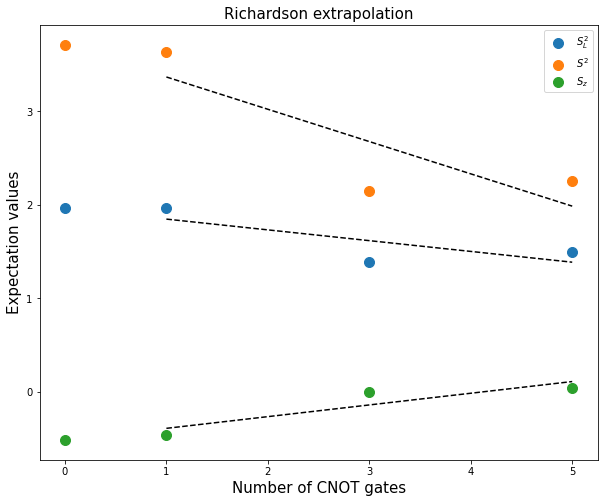

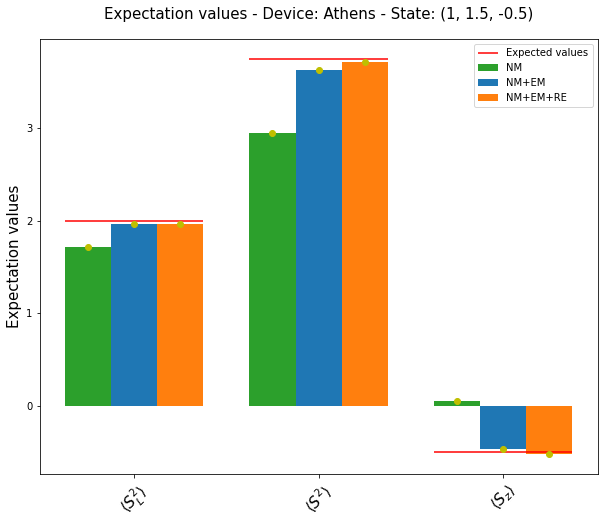

In [74]:
# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]
data_re, err_re = [],[]

for j in range(3):
    plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],ls="none")

    coeff = np.polyfit([1,3,5],[data_1[j],data_3[j],data_5[j]],1)
    data_re.append(coeff[1])
    err_re.append(extr_dev_std([1,3,5],[err_1[j],err_3[j],err_5[j]]))
    
    poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.scatter([0,1,3,5],[coeff[1],data_1[j],data_3[j],data_5[j]],s=100,label=op_labels[j])
    plt.plot([1,3,5], poly1d_fn([1,3,5]), '--k')
    
plt.title("Richardson extrapolation",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=15)
plt.legend()

    
# The histograms - Plot of expectation values
l=lab_list[5]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')

rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')

rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')

ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()

## `EvolVarForm5` with `reps=3`($1$ parameter for $R_{xx}$, $1$ for $R_{yy}$, $1$ for $R_{zz}$)

#### Definition of the ansatz

We are going to use the "time evolution" variational form with:
- $|\psi(0) \rangle = |\downarrow \downarrow \uparrow \rangle = |110 \rangle = |s=1,s_z=-1 \rangle_{01} |s=1/2,s_z=1/2 \rangle_2$ as initial state
- Depth equal to $3$

## QASM simulation - Noise model, (measurement) error correction and Richardson extrapolation

### Histograms of expectation values and Richardson extrapolation

**Remark** When we use the method of the multiplication of gates to reduce the number of errors on gates $R_{xx}$, $R_{yy}$ and $R_{zz}$, we transpile those gates into simpler gates and then we use the method on them. 

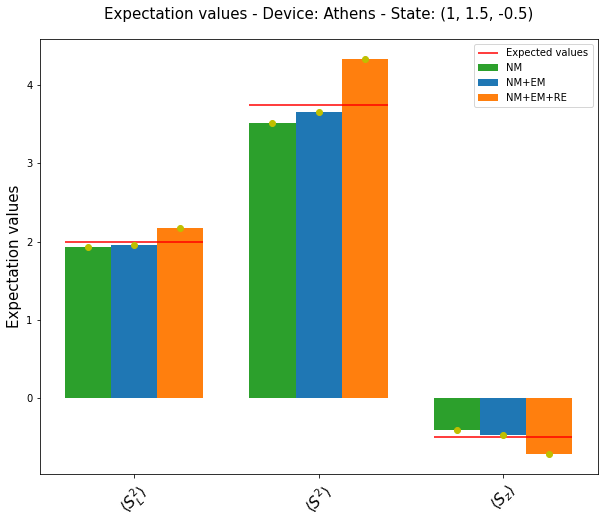

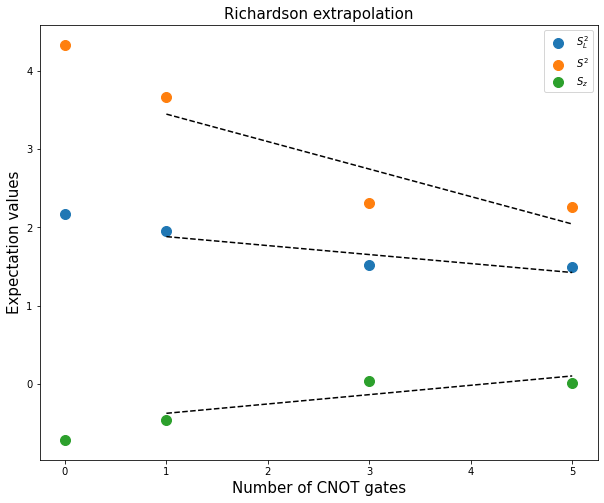

In [25]:
file=open("Results/VQE_spin_qasm_evolvarform5_r3_lab5.out")      
line=file.readlines()

s= 8092     # Number of shots
cl=0        # Count lines

data_raw,err_raw=[],[]
data_1,err_1=[],[]
data_3,err_3=[],[]
data_5,err_5=[],[]
data_re,err_re=[],[]

for j in range(12):
    val=line[cl].split()
    if j<3:
        data_raw.append(float(val[0]))
        err_raw.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=3 and j<6:
        data_1.append(float(val[0]))
        err_1.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=6 and j<9:
        data_3.append(float(val[0]))
        err_3.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=9 and j<12:
        data_5.append(float(val[0]))
        err_5.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    cl+=1
    
for i in range(len(data_1)):
    data_re.append( data_1[i]+(data_1[i]-data_3[i])/2.0 )
    err_re.append(np.sqrt((err_1[i]**2+(err_1[i]**2+err_3[i]**2)/4.0)/s))
    
# The histograms - Plot of expectation values
l=lab_list[5]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')

rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')

rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')

ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()


# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]

for j in range(3):
    plt.errorbar([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],yerr=[err_re[j],err_1[j],err_3[j],err_5[j]],ls="none")

    coeff = np.polyfit([1,3,5],[data_1[j],data_3[j],data_5[j]],1)
    poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.scatter([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],s=100,label=op_labels[j])
    plt.plot([1,3,5], poly1d_fn([1,3,5]), '--k')
plt.title("Richardson extrapolation",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=15)
plt.legend()


### Histogram of expectation values with RE on values with $1$,$3$ and $5$ CNOTs

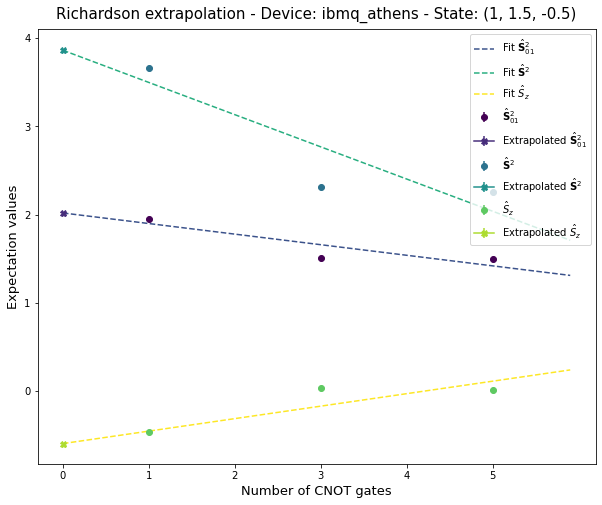

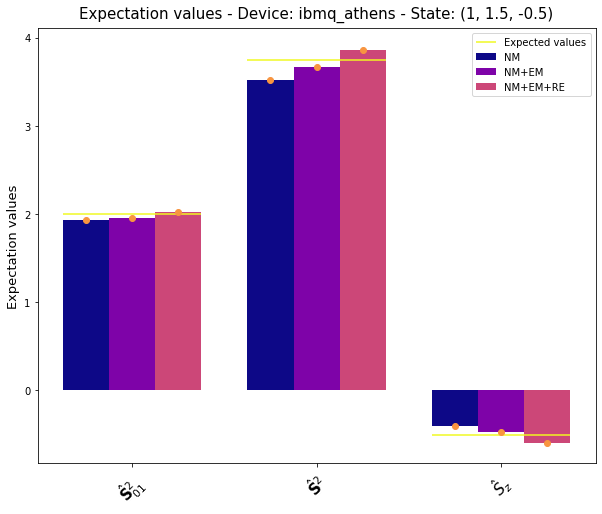

In [27]:
'''
# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]
data_re, err_re = [],[]

for j in range(3):
    plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],ls="none")

    coeff = np.polyfit([1,3,5],[data_1[j],data_3[j],data_5[j]],1)
    data_re.append(coeff[1])
    err_re.append(extr_dev_std([1,3,5],[err_1[j],err_3[j],err_5[j]]))
    
    poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.scatter([0,1,3,5],[coeff[1],data_1[j],data_3[j],data_5[j]],s=100,label=op_labels[j])
    plt.plot([1,3,5], poly1d_fn([1,3,5]), '--k')
    
plt.title("Richardson extrapolation",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=15)
plt.legend()

    
# The histograms - Plot of expectation values
l=lab_list[5]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')

rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')

rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')

ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()
'''
#'''
op_labels=[r"$\hat{\mathbf{S}}_{01}^2$",r"$\hat{\mathbf{S}}^2$",r"$\hat{S}_z$"]

# Richardson extrapolation analysis
jet = plt.get_cmap('viridis')
colors = iter(jet(np.linspace(0,1,9)))

data_re, err_re = [],[]

plt.figure(figsize=(10,8))
for j in range(3):
    # Data
    plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],marker='o',ls="none",label=op_labels[j],color=next(colors))
    # Extrapolated data
    p_ave,p_cov = curve_fit(straight_line,[1,3,5],[data_1[j],data_3[j],data_5[j]],sigma=[err_1[j],err_3[j],err_5[j]],absolute_sigma=True)                                                                                    
    plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j],color=next(colors))
    data_re.append(p_ave[1])
    err_re.append(np.sqrt(p_cov[1,1]))
    # Fit
    u = list(np.arange(0,6,0.1))
    v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
    plt.plot(u,v,'--',label='Fit '+op_labels[j], color=next(colors))                                                                                    

plt.title("Richardson extrapolation - Device: ibmq_athens - State: "+str(l),size=15,pad=10)
plt.xlabel("Number of CNOT gates",size=13)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=13)
plt.legend()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/EvolVarForm_qasm_3_RE_5.pdf")

# The histograms - Plot of expectation values
jet = plt.get_cmap('plasma')
colors = iter(jet(np.linspace(0,1,5)))

l = lab_list[5]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color=next(colors))
rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color=next(colors))
rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color=next(colors))

c = next(colors)
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color=c)
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color=c)
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color=c)

c = next(colors)
ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors=c)
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors=c)
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors=c,label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=13)
ax.set_title(r'Expectation values - Device: ibmq_athens - State: '+str(l),fontsize=15,pad=10)
ax.set_xticks(x_lab)
ax.set_xticklabels(op_labels,rotation=45,size=15)
ax.legend()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/EvolVarForm_qasm_3_5.pdf")

#'''

# $|s_L=1,s=3/2,s_z=1/2\rangle$ ($2$nd Dicke state)

If we follow the same line of reasoning shown above we find that we have to start from:

$$|\psi(0) \rangle = \frac{1}{\sqrt{2}} \Bigl(|\uparrow \downarrow \rangle_{01} + |\downarrow \uparrow  \rangle_{01} \Bigr) |\uparrow \rangle_2 =  |s=1,s_z=0 \rangle_{01} |s=1/2,s_z=1/2 \rangle_2$$

This time the evolved state will be:

$$|\psi(t) \rangle = c_1(t) |s_L=1,s=3/2,s_z=1/2 \rangle + c_2(t) |s_L=1,s=1/2,s_z=1/2 \rangle$$

## `EvolVarForm3` ($1$ parameter for each gate)
#### Definition of the ansatz

We are going to use the "time evolution" variational form `EvolVarForm3` with:
- $|\psi(0) \rangle = \frac{1}{\sqrt{2}} \Bigl(|\uparrow \downarrow \rangle_{01} + |\downarrow \uparrow  \rangle_{01} \Bigr) |\uparrow \rangle_2$
- Depth equal to $2$

In [78]:
# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,0)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm3(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of circuit with generic parameters"))
circ=var_form.construct_circuit(ParameterVector('θ',var_form.num_parameters)) 
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0.         0.70710678 0.70710678 0.         0.         0.
 0.         0.        ]


Example of circuit with generic parameters

     ┌────────────┐                        ┌───┐┌────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└────────────┘└─┬─┘»
q_1: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├──■──────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                     │  »
q_2: ────────────────■──────────────────■───────────────────────■──»
                                                                   »
«     ┌────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[1]) ├»
«                                        │  │              ││              │»
«q_2: ───────────────────────────────────■──┤1             ├┤1             ├»
«                                           └────

In [79]:

# Before using Richardson extrapolation we transpile the R_{xx}, R_{yy} and R_{zz} gates
circ2   = QuantumCircuit(QuantumRegister(nqubits,'q'))
for g in circ:
    instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
    #print(instruction.name)
    if(instruction.name=='cx'): 
        circ2.cx(qubits[0],qubits[1])
    elif(instruction.name=='x'):
        circ2.x(qubits[0])
    elif(instruction.name=='rz'):
        t1 = instruction.params[0]
        circ.rz(t1,qubits[0].index)
    elif(instruction.name=='ry'):
        t1 = instruction.params[0]
        circ2.ry(t1,qubits[0])
    elif(instruction.name=='ch'):
        circ2.ch(qubits[0],qubits[1])
    elif(instruction.name=='u'):
        t1,t2,t3 = instruction.params
        circ2.u(t1,t2,t3,qubits[0])
    elif (instruction.name=='rxx') or (instruction.name=='ryy') or (instruction.name=='rzz'):
        qc = QuantumCircuit(QuantumRegister(nqubits,'q'))
        
        if (instruction.name=='rxx'):
            qc.rxx(instruction.params[0],qubits[0],qubits[1])
        elif (instruction.name=='ryy'):
            qc.ryy(instruction.params[0],qubits[0],qubits[1])
        elif (instruction.name=='rzz'):
            qc.rzz(instruction.params[0],qubits[0],qubits[1])
            
        trans_g = transpile(qc,device,optimization_level=1,initial_layout=[0,1,2])
        # Inserting in circ2 the gates of the transpiled R_xx, R_yy and R_zz
        for g2 in trans_g:
            instruction2,qubits2,_ = g2 # extract gate info (domain: q1,q2 -- instruction)
            if(instruction2.name=='cx'):
                circ2.cx(qubits2[0].index,qubits2[1].index)
            elif(instruction2.name=='rz'):
                t1 = instruction2.params[0]
                circ2.rz(t1,qubits2[0].index)
            elif(instruction2.name=='sx'):
                circ2.sx(qubits2[0].index)
            elif(instruction2.name=='u'):
                t1,t2,t3 = instruction2.params[0]
                circ2.u(t1,t2,t3,qubits2[0].index)
    #else:
    #    print(instruction.name)
    
print("Ansatz with R_{xx}, R_{yy} and R_{zz} replaced by their transpiled gates")
print(circ2.draw())

Ansatz with R_{xx}, R_{yy} and R_{zz} replaced by their transpiled gates
     ┌────────────┐                        ┌───┐┌────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└────────────┘└─┬─┘»
q_1: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├──■──────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                     │  »
q_2: ────────────────■──────────────────■───────────────────────■──»
                                                                   »
«     ┌────────────┐┌───┐┌────────────┐┌───┐┌─────────┐┌────┐┌─────────┐»
«q_0: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├»
«     └────────────┘└─┬─┘└────────────┘└─┬─┘└─────────┘├───┬┘└─────────┘»
«q_1: ────────────────■──────────────────┼───────■─────┤ X ├──────■─────»
«                                        │     ┌─┴─┐   └─┬─┘    ┌─┴─┐   »
«q_2: ───────────────────────────────────■─────┤ X ├─────■──────┤ X ├───»


## QASM simulation - Noise model, (measurement) error correction and Richardson extrapolation

### Histograms of expectation values and Richardson extrapolation

**Remark** When we use the method of the multiplication of gates to reduce the number of errors on gates $R_{xx}$, $R_{yy}$ and $R_{zz}$, we transpile those gates into simpler gates and then we use the method on them. 

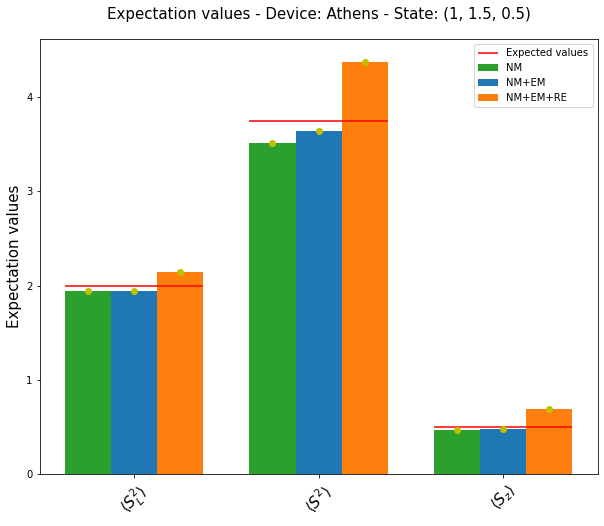

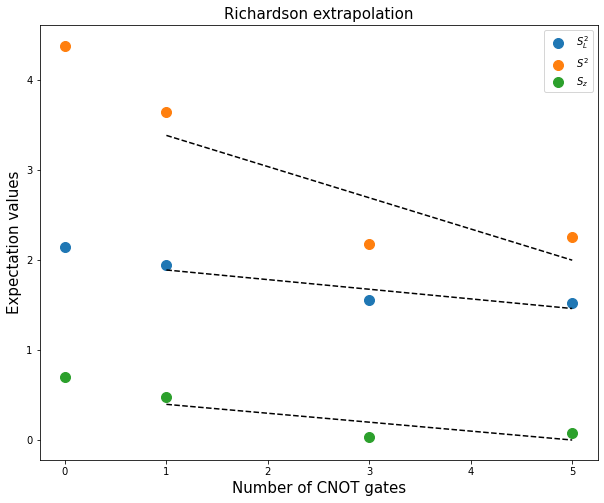

In [7]:
file=open("Results/VQE_spin_qasm_evolvarform3_lab6.out")      # Before: VQE_spin_qasm_2.out
line=file.readlines()

s= 8092     # Number of shots
cl=0        # Count lines

data_raw,err_raw=[],[]
data_1,err_1=[],[]
data_3,err_3=[],[]
data_5,err_5=[],[]
data_re,err_re=[],[]

for j in range(15):
    val=line[cl].split()
    if j<3:
        data_raw.append(float(val[0]))
        err_raw.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=3 and j<6:
        data_1.append(float(val[0]))
        err_1.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=6 and j<9:
        data_3.append(float(val[0]))
        err_3.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=9 and j<12:
        data_5.append(float(val[0]))
        err_5.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=12 and j<15:
        data_re.append(float(val[0]))
        err_re.append(np.sqrt(float(val[1])/s))    # Standard deviation!  
    cl+=1
    
# The histograms - Plot of expectation values
l=lab_list[6]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')

rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')

rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')

ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()

# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]

for j in range(3):
    plt.errorbar([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],yerr=[err_re[j],err_1[j],err_3[j],err_5[j]],ls="none")

    coeff = np.polyfit([1,3,5],[data_1[j],data_3[j],data_5[j]],1)
    poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.scatter([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],s=100,label=op_labels[j])
    plt.plot([1,3,5], poly1d_fn([1,3,5]), '--k')
plt.title("Richardson extrapolation",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=15)
plt.legend()


### Histogram of expectation values with RE on values with $1$,$3$ and $5$ CNOTs

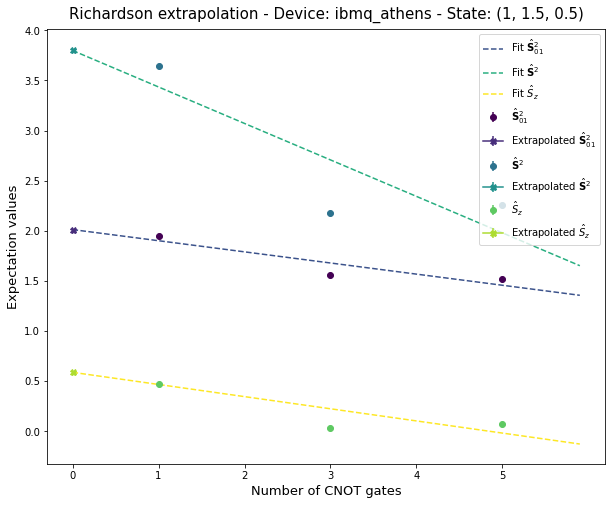

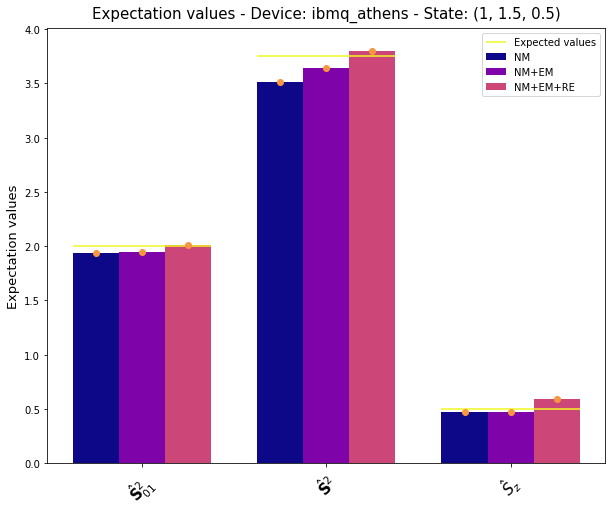

In [9]:
'''
# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]
data_re, err_re = [],[]

for j in range(3):
    plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],ls="none")

    coeff = np.polyfit([1,3,5],[data_1[j],data_3[j],data_5[j]],1)
    data_re.append(coeff[1])
    err_re.append(extr_dev_std([1,3,5],[err_1[j],err_3[j],err_5[j]]))
    
    poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.scatter([0,1,3,5],[coeff[1],data_1[j],data_3[j],data_5[j]],s=100,label=op_labels[j])
    plt.plot([1,3,5], poly1d_fn([1,3,5]), '--k')
    
plt.title("Richardson extrapolation",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=15)
plt.legend()

    
# The histograms - Plot of expectation values
l=lab_list[6]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')

rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')

rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')

ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()
'''

# Definition of straight line
def straight_line(x,m,q):
    return m*x+q

op_labels=[r"$\hat{\mathbf{S}}_{01}^2$",r"$\hat{\mathbf{S}}^2$",r"$\hat{S}_z$"]

# Richardson extrapolation analysis
jet = plt.get_cmap('viridis')
colors = iter(jet(np.linspace(0,1,9)))

data_re, err_re = [],[]

plt.figure(figsize=(10,8))
for j in range(3):
    # Data
    plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],marker='o',ls="none",label=op_labels[j],color=next(colors))
    # Extrapolated data
    p_ave,p_cov = curve_fit(straight_line,[1,3,5],[data_1[j],data_3[j],data_5[j]],sigma=[err_1[j],err_3[j],err_5[j]],absolute_sigma=True)                                                                                    
    plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j],color=next(colors))
    data_re.append(p_ave[1])
    err_re.append(np.sqrt(p_cov[1,1]))
    # Fit
    u = list(np.arange(0,6,0.1))
    v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
    plt.plot(u,v,'--',label='Fit '+op_labels[j], color=next(colors))                                                                                    

plt.title("Richardson extrapolation - Device: ibmq_athens - State: "+str(l),size=15,pad=10)
plt.xlabel("Number of CNOT gates",size=13)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=13)
plt.legend()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/EvolVarForm_qasm_3_RE_6.pdf")

# The histograms - Plot of expectation values
jet = plt.get_cmap('plasma')
colors = iter(jet(np.linspace(0,1,5)))

l = lab_list[6]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color=next(colors))
rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color=next(colors))
rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color=next(colors))

c = next(colors)
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color=c)
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color=c)
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color=c)

c = next(colors)
ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors=c)
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors=c)
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors=c,label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=13)
ax.set_title(r'Expectation values - Device: ibmq_athens - State: '+str(l),fontsize=15,pad=10)
ax.set_xticks(x_lab)
ax.set_xticklabels(op_labels,rotation=45,size=15)
ax.legend()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/EvolVarForm_qasm_3_6.pdf")

## `EvolVarForm5` with `reps=2`($1$ parameter for $R_{xx}$, $1$ for $R_{yy}$, $1$ for $R_{zz}$)

#### Definition of the ansatz

We are going to use the "time evolution" variational form `EvolVarForm5` with:
- $|\psi(0) \rangle = \frac{1}{\sqrt{2}} \Bigl(|\uparrow \downarrow \rangle_{01} + |\downarrow \uparrow  \rangle_{01} \Bigr) |\uparrow \rangle_2$ as initial state
- Depth equal to $2$


In [75]:
# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,0)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm5(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of circuit with generic parameters"))
circ=var_form.construct_circuit(ParameterVector('θ',var_form.num_parameters)) 
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0.         0.70710678 0.70710678 0.         0.         0.
 0.         0.        ]


Example of circuit with generic parameters

     ┌────────────┐                        ┌───┐┌────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└────────────┘└─┬─┘»
q_1: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├──■──────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                     │  »
q_2: ────────────────■──────────────────■───────────────────────■──»
                                                                   »
«     ┌────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[1]) ├»
«                                        │  │              ││              │»
«q_2: ───────────────────────────────────■──┤1             ├┤1             ├»
«                                           └────

## QASM simulation - Noise model, (measurement) error correction and Richardson extrapolation

### Histograms of expectation values and Richardson extrapolation

**Remark** When we use the method of the multiplication of gates to reduce the number of errors on gates $R_{xx}$, $R_{yy}$ and $R_{zz}$, we transpile those gates into simpler gates and then we use the method on them. 

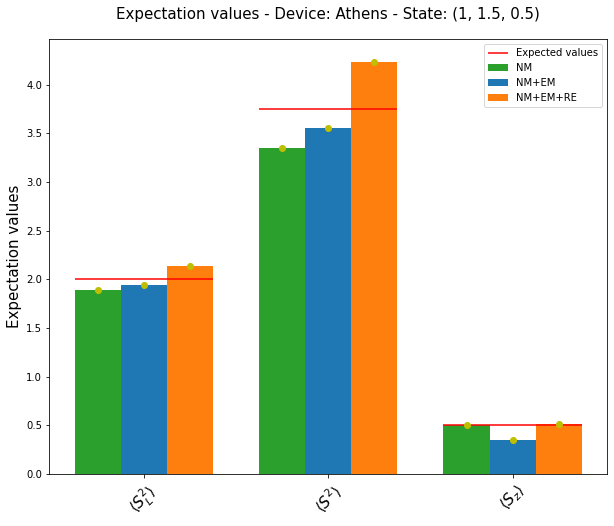

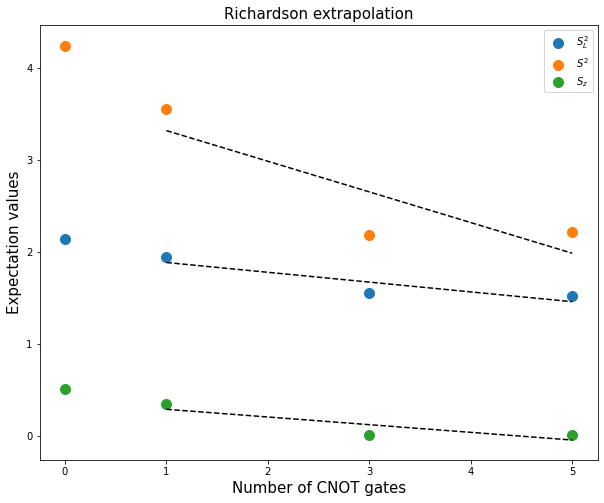

In [76]:
file=open("Results/VQE_spin_qasm_evolvarform5_lab6.out")      # Before: VQE_spin_qasm_2.out
line=file.readlines()

s= 8092     # Number of shots
cl=0        # Count lines

data_raw,err_raw=[],[]
data_1,err_1=[],[]
data_3,err_3=[],[]
data_5,err_5=[],[]
data_re,err_re=[],[]

for j in range(15):
    val=line[cl].split()
    if j<3:
        data_raw.append(float(val[0]))
        err_raw.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=3 and j<6:
        data_1.append(float(val[0]))
        err_1.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=6 and j<9:
        data_3.append(float(val[0]))
        err_3.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=9 and j<12:
        data_5.append(float(val[0]))
        err_5.append(np.sqrt(float(val[1])/s))    # Standard deviation!
    elif j>=12 and j<15:
        data_re.append(float(val[0]))
        err_re.append(np.sqrt(float(val[1])/s))    # Standard deviation!  
    cl+=1
    
# The histograms - Plot of expectation values
l=lab_list[6]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')

rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')

rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')

ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()

# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]

for j in range(3):
    plt.errorbar([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],yerr=[err_re[j],err_1[j],err_3[j],err_5[j]],ls="none")

    coeff = np.polyfit([1,3,5],[data_1[j],data_3[j],data_5[j]],1)
    poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.scatter([0,1,3,5],[data_re[j],data_1[j],data_3[j],data_5[j]],s=100,label=op_labels[j])
    plt.plot([1,3,5], poly1d_fn([1,3,5]), '--k')
plt.title("Richardson extrapolation",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=15)
plt.legend()


### Histogram of expectation values with RE on values with $1$,$3$ and $5$ CNOTs

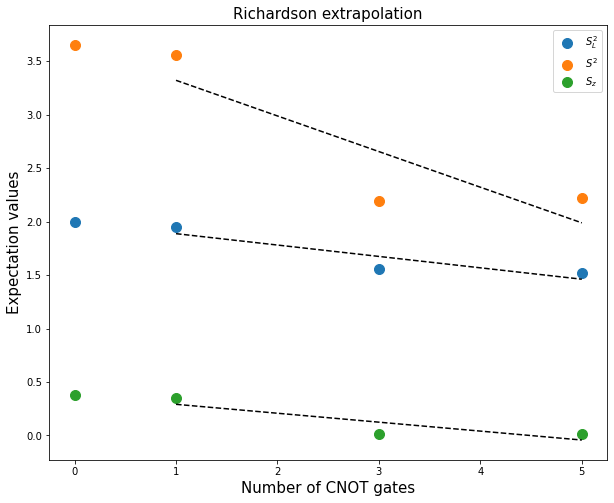

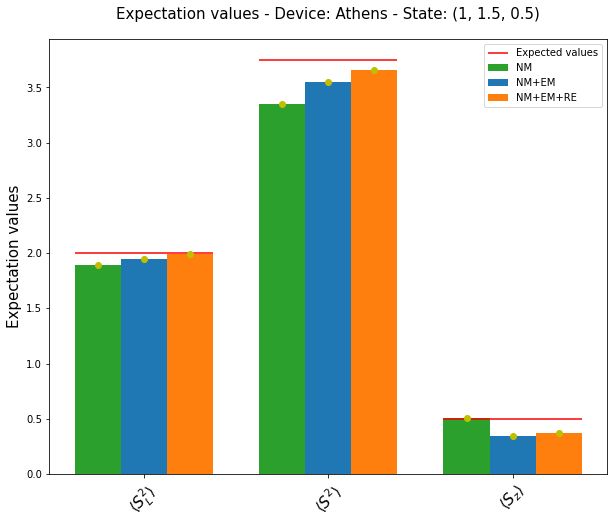

In [77]:
# Richardson extrapolation analysis
plt.figure(figsize=(10,8))
op_labels=[r"$S_L^2$",r"$S^2$",r"$S_z$"]
data_re, err_re = [],[]

for j in range(3):
    plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],ls="none")

    coeff = np.polyfit([1,3,5],[data_1[j],data_3[j],data_5[j]],1)
    data_re.append(coeff[1])
    err_re.append(extr_dev_std([1,3,5],[err_1[j],err_3[j],err_5[j]]))
    
    poly1d_fn = np.poly1d(coeff) # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.scatter([0,1,3,5],[coeff[1],data_1[j],data_3[j],data_5[j]],s=100,label=op_labels[j])
    plt.plot([1,3,5], poly1d_fn([1,3,5]), '--k')
    
plt.title("Richardson extrapolation",size=15)
plt.xlabel("Number of CNOT gates",size=15)
plt.xticks(np.arange(6))
plt.ylabel("Expectation values",size=15)
plt.legend()

    
# The histograms - Plot of expectation values
l=lab_list[6]
fig, ax = plt.subplots(figsize=(10,8))
x_lab=np.arange(3)
width=0.25

rects1 = ax.bar(x_lab - width, data_raw, width, label='NM',color='tab:green')
ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')

rects2 = ax.bar(x_lab, data_1, width, label='NM+EM',color='tab:blue')
ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')

rects3 = ax.bar(x_lab + width, data_re, width, label='NM+EM+RE',color='tab:orange')
ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')

ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Expectation values',fontsize=15)
ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
ax.legend()
plt.show()

#### Useful information

- We convert the desired matrices into `WeightedPauliOperator`s. We have to take the expectation value of those operators.

In [10]:
op1=op_converter.to_weighted_pauli_operator(MatrixOperator(mat_sl2))
op2=op_converter.to_weighted_pauli_operator(MatrixOperator(mat_s2))
op3=op_converter.to_weighted_pauli_operator(MatrixOperator(mat_sz))